<a href="https://colab.research.google.com/github/Anello92/sales_forecast_project/blob/master/projeto_previsao_vendas_rossmann_status_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Imports

In [ ]:
!pip install inflection
!pip install tabulate
!pip install --upgrade seaborn
!pip install sklearn
!pip install Ipython
!pip install boruta

In [ ]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

import inflection
import math
import datetime
import warnings
warnings.filterwarnings('ignore')

from scipy                 import stats
from IPython.display       import Image
from IPython.core.display  import HTML
from boruta                import BorutaPy

from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_log_error, chi2_contingency, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

### 0.1. Helper Functions

In [ ]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

#-----------------------------------------------------------------

def ml_error(model_name, y, yhat):
    """
    Função para calcular erros comuns em modelos de machine learning.

    Argumentos:
    model_name (str): O nome do modelo.
    y (pd.Series ou np.array): Os valores verdadeiros.
    yhat (pd.Series ou np.array): Os valores previstos pelo modelo.

    Retorna:
    DataFrame pandas com o nome do modelo e os erros calculados.
    """
    # Calcula o Mean Absolute Error
    mae = mean_absolute_error(y, yhat)

    # Calcula o Mean Absolute Percentage Error
    mape = np.mean(np.abs((y - yhat) / y)) * 100

    # Calcula o Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, yhat))

    # Retorna um DataFrame com os resultados
    return pd.DataFrame({
        'Model Name': [model_name],
        'MAE': [mae],
        'MAPE': [mape],
        'RMSE': [rmse]
    })

# -----------------------------------------------------------------

def cramer_v(x, y):
    # Cria a matriz de contigência
    contingency_matrix = pd.crosstab(x, y).values
    # Cálcula o valor total
    n = contingency_matrix.sum()
    # Obtem as dimensões da matriz
    rows, cols = contingency_matrix.shape

    # Realiza o teste qui-quadrado
    chi2 = chi2_contingency(contingency_matrix)[0]
    # Corrige o valor qui-quadrado pelo bias
    chi2corr = max(0, chi2 - (cols-1)*(rows-1)/(n-1))

    # Corrige as dimensões da matriz pelo bias
    rows_corr = rows - (rows-1)**2/(n-1)
    cols_corr = cols - (cols-1)**2/(n-1)

    # Cálcula a estatística de Cramér-V
    cramerv = np.sqrt((chi2corr/n)/(min(cols_corr-1, rows_corr-1)))

    return cramerv

# -----------------------------------------------------------------

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    # Estilos e tamanho de figuras e fontes
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 26
    plt.rcParams['legend.fontsize'] = 18
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.53

    # Configurações do Pandas
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.2f}'.format
    pd.options.display.precision = 2

    # Configurações para exibir todas as colunas e linhas
    pd.set_option('display.expand_frame_repr', False)

    # Configurações de largura do notebook
    display(HTML('<style>.container {width:100% !important;}</style>'))

    # Impede a exibição de avisos desnecessários
    import warnings
    warnings.filterwarnings('ignore')


### 0.2 Loading Data

In [ ]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)


Neste segmento, estaremos utilizando a função read_csv do pandas, que é uma poderosa biblioteca de análise e manipulação de dados em Python. A função read_csv é usada para ler dados tabulares, como um arquivo CSV, e criar um DataFrame do pandas.

O primeiro argumento para a função read_csv é o caminho para o arquivo que queremos ler. No nosso caso, o arquivo está localizado na pasta 'data' e se chama 'Train.csv'.

O segundo argumento é low_memory. Neste exemplo, estamos definindo low_memory como False, o que instrui a função read_csv a carregar todo o arquivo na memória de uma vez, em vez de ler o arquivo em pedaços. Se low_memory fosse definido como True, a função leria o arquivo em pedaços para economizar memória.

A decisão de definir low_memory como True ou False depende da capacidade de memória do seu computador. Se você tentar carregar um arquivo muito grande e seu computador tiver memória limitada, pode receber um erro ou aviso.


In [ ]:
# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')
df_raw.sample()


Carregados os arquivos, realizamos uma operação de 'merge' (fusão) em dois conjuntos de dados utilizando a função merge do pandas. Esta operação é semelhante a um 'JOIN' em SQL, onde os dados de dois (ou mais) DataFrames são combinados com base em uma coluna (ou várias colunas) em comum.

 Para fazer isso, utilizamos a função merge do pandas, que aceita vários argumentos.

O primeiro argumento é o DataFrame que servirá como referência para a operação de 'merge'. O segundo argumento é o DataFrame que será anexado ao primeiro. O argumento how especifica o tipo de 'merge' a ser realizado. No nosso caso, o valor é 'outer', o que significa que queremos um 'merge' que inclua todas as linhas de ambos os DataFrames, independentemente de haver uma correspondência entre as colunas.

O argumento on especifica a coluna (ou colunas) que serão usadas como chave para o 'merge'. No nosso caso, a coluna é 'Store', que está presente em ambos os DataFrames.

O resultado da operação de 'merge' é armazenado em uma nova variável chamada 'df'. Em resumo, a função merge é um método da classe pandas usado para combinar dois ou mais DataFrames com base em colunas em comum.

# 1.0. Descrição dos Dados

In [ ]:
df1 = df_raw.copy()

Uma sugestão é fazer cópias do DataFrame sempre que se muda de sessão de análise em um notebook. A prática é sugerida como uma medida preventiva contra a perda de dados originais durante a manipulação dos DataFrames em sessões subsequentes.

Esse procedimento pode evitar a necessidade de reexecutar o notebook do início, economizando tempo, especialmente quando se trabalha com grandes volumes de dados.

## 1.1 Rename Columns

In [ ]:
df_raw.columns

 É recomendável renomear as colunas para nomes mais intuitivos e fáceis de lembrar. Isso pode ajudar a acelerar o desenvolvimento posterior, já que os nomes das colunas serão frequentemente usados para explorar os dados, aplicar algoritmos, fazer gráficos, entre outros.

 Embora os nomes das colunas no exemplo atual sejam bastante organizados e estejam no formato 'camel case' (alternando entre letras maiúsculas e minúsculas), isso pode não ser o caso em um ambiente real, onde os nomes das colunas podem ser muito menos intuitivos.

 Portanto, é uma boa prática revisar e, se necessário, renomear as colunas no início do processo de análise de dados.

In [ ]:
cols_old = [
'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
'CompetitionDistance', 'CompetitionOpenSinceMonth',
'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
'Promo2SinceYear', 'PromoInterval']

Prosseguindo com a análise de dados, é uma boa prática cria uma coluna chamada 'cols_old' no DataFrame. Esta coluna será preenchida com os nomes originais das colunas do DataFrame.

Uma vez que esta lista de nomes de colunas originais foi criada, o ideal é realizar a alteração dos nomes das colunas para um formato chamado 'snake case', que consiste em todas as palavras em minúsculas separadas por sublinhados.


In [ ]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

Criamos a função snake_case. Para aplicá-la, utilizaremos outra função chamada map, que nos permite aplicar/mapear a função snake_case a todos os elementos de uma lista, nesse caso, a lista de nomes de colunas antigos em cols_old. O resultado dessa operação será armazenado em uma nova lista chamada 'cols_new'.

In [ ]:
df1.columns = cols_new
df1.columns

## 1.2 Data Dimensions

Um passo crucial na descrição de nossos dados é determinar as dimensões do nosso DataFrame - o número de linhas e colunas. Para isso, utilizamos o método shape que fornece essas informações.

In [ ]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Cols: {}'.format(df1.shape[1]))

Ao executar essas instruções, descobrimos que nosso DataFrame possui 1.017.209 linhas distribuídas em 18 colunas. A quantidade de dados é considerável, mas gerenciável para os nossos recursos computacionais atuais. No entanto, se for necessário lidar com conjuntos de dados maiores, existem opções como servidores AWS, Google Cloud ou Kaggle, que oferecem recursos computacionais robustos gratuitamente ou com custos associados.

## 1.3 Data Types

 O próximo passo na descrição dos dados é examinar os tipos de dados presentes no DataFrame. Para isso, utilizamos o método **dtypes**, que nos permite ver a coluna e o tipo de dado correspondente sem a necessidade de usar parênteses.

In [ ]:
df1.dtypes

 Isso nos permite identificar que colunas como 'Store' são do tipo int64 e 'Date' é do tipo objeto.

No caso da coluna 'Date', queremos alterar o formato de dados para que possamos trabalhar com ele como uma data.

In [ ]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

Para fazer isso, utilizamos o método to_datetime no pandas e aplicamos diretamente na coluna 'Date' para convertê-la para o tipo de data correto. Quando verificamos novamente o tipo de dados na coluna 'Date', confirmamos que agora é datetime64, que é o formato adequado para trabalhar com datas no pandas.

### Check NA

O próximo passo na análise é a realização de uma verificação de dados nulos (NaN), que é essencial para garantir a qualidade dos dados que estamos trabalhando.

Começamos usando o método isna() em nosso DataFrame, que nos permite ver todas as linhas que contêm pelo menos uma coluna com valor ausente ou nulo. No entanto, em vez de visualizar essas linhas individualmente, queremos a soma dessas linhas por coluna, o que é feito utilizando o método sum().

In [ ]:
df1.isna().sum()

Ao executar esses comandos, podemos ver que algumas de nossas colunas não contêm valores ausentes, enquanto outras possuem alguns. Precisamos tratar esses valores ausentes e, geralmente, existem três métodos para lidar com eles:

- Descartar as linhas: Esse método envolve simplesmente descartar qualquer linha que contenha pelo menos um valor ausente. A principal vantagem é que é rápido e fácil, mas a desvantagem significativa é que você pode estar descartando informações úteis para o algoritmo aprender padrões, o que pode prejudicar a performance do seu modelo se você não tiver muitos dados.

- Usar algoritmos de aprendizado de máquina: Há algoritmos e métodos que podem preencher valores ausentes com base no comportamento geral da coluna. Por exemplo, você pode preencher os valores ausentes com a média, mediana ou moda da coluna, ou até mesmo usar algoritmos mais avançados que estimam o que o valor poderia ser se não estivesse ausente.

- Usar conhecimento de negócio: Às vezes, os valores ausentes estão lá devido a alguma lógica de negócio definida inicialmente. Se soubermos essa regra, podemos preencher os valores ausentes de forma adequada e recuperar os dados.

## 1.5 Fillout NA
Vamos iniciar uma nova subseção, denominada 'Fill-na', com o objetivo de preencher os dados ausentes.


Começaremos lidando com a coluna 'competition_distance'. Retornando à descrição da coluna, sabemos que essa coluna indica a distância, em metros, do concorrente mais próximo.

In [ ]:
# competition_distance
# competition_open_since_month
# competition_open_since_year
# promo2_since_week
# promo2_since_year
# promo_interval

### Existem três maneiras principais de lidar com dados ausentes (NaN):

A primeira maneira é excluir todos os dados ausentes. A principal vantagem desse método é a rapidez, mas a desvantagem é a perda substancial de informações.

A segunda maneira é usar algoritmos de aprendizado de máquina para substituir dados ausentes com base no comportamento da coluna. Por exemplo, podemos calcular a mediana ou a média e substituir todos os dados ausentes por esses valores. Algoritmos mais sofisticados podem fazer agrupamentos ou até mesmo prever esses valores ausentes.

A terceira maneira, e a que vamos adotar neste tutorial, é pensar do ponto de vista do negócio. Embora não sejamos especialistas, é útil fazer esse tipo de exercício. Pensar sobre o motivo pelo qual esses dados estão ausentes pode oferecer insights valiosos.



### 1. Competition Distance
Vamos considerar a coluna 'competition_distance'. Uma maneira de interpretar a ausência de dados aqui é que a distância até o concorrente mais próximo é tão grande que é efetivamente o mesmo que não haver concorrente próximo.

In [ ]:
df1['competition_distance'].max()

Com a ausência de valores em 'competition_distance', iremos substituí-los por um número extremamente grande, que chamaremos de 'max_value'. Para definir este 'max_value', vamos primeiro procurar o valor máximo existente na coluna 'competition_distance'. No nosso caso, encontramos o valor de 75.860 metros como o mais distante concorrente.

In [ ]:
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000.0 if math.isnan(x) else x)

Vamos escolher 'max_value' como 200.000 metros, um valor bem maior que a distância máxima existente na coluna 'competition_distance'. Valores ausentes serão substituídos por 'max_value', indicando que não há concorrente próximo nesses casos.

Se um valor estiver presente, será retornado como está. Aplicaremos essa lógica ao nosso conjunto de dados usando a função lambda, que será aplicada apenas na coluna 'competition_distance'. O resultado substituirá a coluna original.

Após aplicar a função e recalcular a soma de linhas NaN, vemos que não há mais valores ausentes na coluna 'competition_distance', mostrando que lidamos com os dados ausentes com sucesso.

In [ ]:
df1.isna().sum()

Agora, a coluna 'competition_distance' não possui mais valores ausentes, e o valor máximo é 200.000 metros, como definido anteriormente.

In [ ]:
df1['competition_distance'].max()

### 2. Competition Open Since Month
Avançando, vamos analisar a coluna 'competition_open_since'. Esta coluna indica o mês e o ano aproximado em que o concorrente mais próximo foi inaugurado.

Podemos supor que os valores ausentes nesta coluna podem ser por duas razões: primeiro, a loja pode não ter um concorrente próximo, logo não existe uma data de abertura para tal concorrente. Segundo, a loja pode ter um concorrente próximo, mas desconhecemos a data de abertura deste, seja porque o concorrente abriu antes da loja ou porque abriu posteriormente.

Para substituir os valores ausentes nesta coluna, copiaremos a data de venda correspondente na linha em questão para a coluna 'competition_open_since'.

In [ ]:
df1.sample()

Agora vamos considerar a coluna 'competition_open_since' em uma linha de exemplo onde uma venda foi feita. Por exemplo, se a linha representar uma venda feita pela loja 283 em 20/05/2014, onde vendeu 7300 itens, e os dados mostram um valor ausente para 'competition_open_since', substituiremos esse valor ausente com a data da venda.

Vamos extrair apenas o mês da data da venda para preencher os valores ausentes na coluna 'competition_open_since_month'. Isso se deve à nossa previsão de que variáveis temporais podem ser cruciais na modelagem do comportamento dos dados.

A lógica é que uma loja sem concorrência tem um nível estável de vendas, que provavelmente cairá quando um concorrente abrir. Com o tempo, as vendas podem se recuperar à medida que os clientes se acostumam com ambas as lojas. Assim, o tempo desde a abertura de um concorrente pode influenciar as flutuações de vendas.

Reconhecemos uma incongruência em usar a data da venda como a data de abertura do concorrente, especialmente se supomos que o concorrente ainda não abriu. No entanto, prosseguiremos com essa abordagem para avaliar seu impacto no modelo. Se necessário, podemos ajustá-la em futuras iterações.

A forma como implementaremos essa substituição será semelhante ao que fizemos para 'competition_distance'.






In [ ]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month
                                                if np.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1)

Portanto, se a coluna 'competition_open_since_month' estiver vazia, iremos preencher com o mês da coluna 'date'.

Se essa condição não for verdadeira, iremos simplesmente retornar o valor original, pois já temos o mês em que a competição foi aberta.

Para aplicar essa lógica, vamos usar a função lambda novamente. Dentro desta função, podemos substituir 'df1' por 'x', já que tudo dentro da função é referido como 'x'.

Para aplicar isso aos nossos dados, vamos usar a função 'apply' e aplicá-la ao longo das colunas. Fazemos isso porque estamos trabalhando com mais de uma coluna - 'competition_open_since_month' e 'date'. Quando trabalhamos com mais de uma coluna, precisamos explicitamente aplicar a função ao longo das colunas.

Finalmente, o resultado dessa função será usado para substituir a coluna original 'competition_open_since_month'.






### 3. Competition Open Since Year
Vamos substituir todas as ocorrências de 'month' por 'year' na linha atual.


In [ ]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year
                                               if np.isnan(x['competition_open_since_year'])
                                               else x['competition_open_since_year'], axis=1)

### 4. Promo 2 Since Week
A coluna 'promo2' indica se uma loja está participando de uma continuação de uma promoção. Se o valor é zero, a loja não está participando; se é um, a loja está participando. Se os dados para 'promo2' são NaN, isso indica que a loja optou por não participar dessa promoção contínua, logo não há uma semana de início para essa promoção.

Para lidar com esses valores ausentes, usaremos uma abordagem semelhante à que usamos para a coluna 'competition_distance': substituir os NaNs pelo valor da data naquela linha. Quando calculamos a distância em tempo, isso permitirá ao algoritmo reconhecer que temos essa promoção ativa desde uma determinada semana.

Para implementar essa substituição, copiamos e colamos o código que usamos para 'competition_distance', fazendo algumas pequenas alterações. Em vez de 'competition', procuramos 'promo2', e em vez de extrair o mês da data, queremos extrair a semana.

In [ ]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week
                                     if np.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'], axis=1)

### 5. Promo 2 Since Year
Para implementar essa substituição, copiamos e colamos o código que usamos para 'promo2_since_week', fazendo algumas pequenas alterações para year e extrair o ano.

In [ ]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year
                                     if np.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'], axis=1)

Este código faz o seguinte:

- Usa a função apply para aplicar uma função lambda a cada linha do dataframe (df1.apply(lambda x: ..., axis=1)).
- Na função lambda, verificamos se 'promo2_since_year' é NaN para essa linha (if math.isnan(x['promo2_since_year'])).
- Se for NaN, substituímos pelo número da semana da data dessa linha (x['date'].year).
- Se não for NaN, mantemos o valor original (else x['promo2_since_year']).

### 6. Promo Interval
Promo Interval" descreve os meses em que uma promoção chamada "Promo 2" foi iniciada. Por exemplo, se os valores forem "Fevereiro, Maio, Agosto, Novembro", isso indica que a promoção foi realizada nesses meses específicos.

In [ ]:
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0
                                                             if x['promo_interval'] == 0
                                                             else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [ ]:
df1.sample(5).T

A primeira etapa na manipulação desses dados é fazer um "split" nesta coluna para criar uma lista dos meses da promoção. Em seguida, uma nova coluna chamada "month_map" será criada com base na data da promoção. Se a data da promoção estiver na lista de meses, um valor indicando que a "Promo 2" estava ativa será inserido nessa nova coluna.

Depois de criar a coluna auxiliar, os meses são convertidos de números para suas representações de string correspondentes. Por exemplo, janeiro seria representado como "1". Uma função é então aplicada para fazer a substituição direta na coluna.

Em seguida, os valores da coluna "Promo Interval" são substituídos por seus equivalentes numéricos. Para fazer isso, um dicionário é criado e aplicado à coluna. Isso cria uma coluna chamada "month_map" que contém o mês em que a promoção ocorreu.

Uma função é então aplicada para comparar se o mês de uma promoção está na lista de meses de "Promo 2". Se o mês estiver na lista, é retornado um valor de "1". Se o mês não estiver na lista, é retornado um valor de "0". Além disso, se uma loja não participou da "Promo 2" (indicado por um valor de "0" na coluna "Promo Interval"), um valor de "0" também é retornado.


In [ ]:
df1.isna().sum()

## 1.6 Change Types
Quando operações são realizadas em colunas de um conjunto de dados, é vital verificar novamente os tipos de dados dessas colunas. A razão para isso é que as operações podem inadvertidamente alterar os tipos de dados originais.

Pode haver situações em que é necessário mudar o tipo de dados de uma coluna para um diferente. Por exemplo, se quisermos converter o tipo de dados 'float' da coluna 'competition' para 'int' (um número inteiro), podemos usar o método astype().


In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics
A estatística descritiva é uma ferramenta essencial para a análise de dados, sendo particularmente útil em duas áreas: obtenção de conhecimento de negócios e detecção de erros nos dados.

Em primeiro lugar, a estatística descritiva proporciona uma visão geral dos dados, permitindo obter insights sobre os negócios. Isto é feito através de métricas de estatísticas descritivas, que se dividem em duas categorias principais: **métricas de tendência central** e **métricas de dispersão**.

As métricas de tendência central, como a média e a mediana, fornecem um resumo dos dados em um único valor. Em essência, elas permitem representar uma variedade de dados através de uma média ou mediana. No entanto, embora essas métricas possam fornecer uma visão geral, elas não revelam como os dados estão distribuídos em torno dessa referência central. É aqui que entram as métricas de dispersão.

As métricas de dispersão, que incluem variância, desvio padrão e valores mínimos e máximos, fornecem informações sobre a distribuição dos dados. Elas indicam se os dados estão concentrados próximo à média ou dispersos em torno dela. Além disso, duas outras medidas de dispersão, chamadas "skewness" (assimetria) e "kurtosis" (curtose), podem ser usadas para entender melhor a distribuição dos dados. A skewness refere-se ao grau de distorção da distribuição em relação a uma distribuição normal, enquanto a curtose descreve a concentração dos dados, indicando se os dados têm um "pico" alto (curtose positiva) ou são mais dispersos (curtose negativa).

Ao trabalhar com a estatística descritiva, é importante separar as variáveis numéricas das categóricas, pois a forma como cada tipo é tratado pode variar. Para selecionar variáveis numéricas, você pode utilizar um método de seleção em sua ferramenta de análise de dados, como select_dtypes() no pandas, uma biblioteca do Python, e passar uma lista dos tipos de dados que você deseja selecionar.

In [ ]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

Neste exemplo, 'df1' é o DataFrame original e 'num_attributes' é o novo DataFrame contendo apenas as colunas numéricas. Podemos visualizar algumas linhas aleatórias do DataFrame usando o método sample(), como mostrado abaixo

In [ ]:
num_attributes.sample(2)

Agora, 'cat_attributes' contém todas as colunas categóricas do DataFrame original. Como antes, podemos visualizar algumas linhas aleatórias do DataFrame usando o método sample().

In [ ]:
cat_attributes.sample(2)

Após separar os dados numéricos e categóricos, podemos proceder para calcular diferentes métricas relevantes para cada tipo de dado. Por exemplo, para dados numéricos, podemos calcular a média, mediana, desvio padrão, etc. Para dados categóricos, podemos contar a frequência de diferentes categorias, encontrar a categoria mais comum, etc.

### 1.7.1 Numerical Attributes
Vamos abordar o cálculo de métricas de tendência central para variáveis numéricas. As métricas de tendência central resumem o conjunto de dados em um único valor representativo, fornecendo um 'centro' em torno do qual os dados estão distribuídos. As métricas de tendência central mais comuns são a média e a mediana.

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

Depois de todas essas métricas calculadas, podemos concatená-las em um único DataFrame para facilitar a visualização. Usamos o método concat() da biblioteca pandas para isso:

In [ ]:
# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

Neste ponto, 'm' é um DataFrame que contém todas as métricas calculadas para cada coluna numérica. Cada linha representa uma métrica, e cada coluna representa uma coluna numérica do DataFrame original.

Considere uma coluna 'Sales' em um conjunto de dados. Com base nas estatísticas, o valor mínimo é zero, indicando que houve dias em que nenhuma venda foi realizada, talvez devido ao fechamento de lojas. O valor máximo é de 41.000, indicando o maior volume de vendas em um dia. O 'range', ou a diferença entre o máximo e o mínimo, é, portanto, 41.000.

Quando a média e a mediana de um conjunto de dados são semelhantes, como neste caso, **indica que a distribuição é próxima de uma distribuição normal**, sem um deslocamento significativo para a esquerda ou para a direita. Além disso, o skewness (medida da assimetria da distribuição) e kurtosis (medida da "cauda" ou outliers da distribuição) também estão próximos de zero, corroborando a suposição da normalidade.


### 1.7.2 Categorical Attributes
Para realizar uma análise descritiva dos dados categóricos, é útil usar gráficos para visualizar as informações. Um tipo de gráfico muito útil para esse propósito é o gráfico de boxplot. Este gráfico permite visualizar diversas medidas estatísticas, como medidas de tendência central e dispersão, em um único lugar, facilitando a comparação entre as categorias.

Entretanto, antes de construir o boxplot, pode ser útil verificar a quantidade de níveis ou valores únicos que cada variável categórica possui. Isso pode ser feito com o uso da função nunique do pandas em Python, que retorna o número de elementos distintos em cada coluna de um dataframe. A função nunique pode ser aplicada a todas as colunas de um dataframe utilizando o método apply.



In [ ]:
cat_attributes.apply(lambda x: x.unique().shape[0])

No exemplo fornecido, as variáveis categóricas analisadas incluem 'state_holiday', 'store_type', 'assortment, 'promot_interval' e 'month_map'. Cada uma dessas variáveis possui três níveis distintos.

In [ ]:
sns.boxplot(x = 'state_holiday', y = 'sales', data = df1)

Estamos analisando a dispersão de 'sales' em cada nível de uma variável categórica. Para isso, podemos definir 'state_holiday' como o eixo x (a categoria) e 'sales' como o eixo y (o valor a ser medido). Os dados serão extraídos do nosso DataFrame, digamos df1, que contém os dados categóricos.

No entanto, pode ser que, ao visualizar o boxplot, os dados estejam distorcidos ou difíceis de interpretar. Uma razão comum para isso é a presença de valores que não são úteis para a análise, como vendas iguais a zero correspondendo a dias em que as lojas estão fechadas.

Para resolver esse problema, podemos filtrar os dados antes de plotar o gráfico. Por exemplo, podemos querer visualizar apenas as vendas que são maiores que zero e que ocorreram em dias que não são feriados. Para fazer isso, podemos utilizar a operação de indexação booleana do pandas para criar um novo DataFrame que satisfaz essas condições:


In [ ]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(15, 6))  # Aqui, 15 representa a largura e 6 a altura.

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

plt.tight_layout()
plt.show()

Acima utilizamos a biblioteca Seaborn para criar boxplots de diferentes variáveis categóricas em relação às vendas. Por exemplo, analisamos as vendas de acordo com o tipo de feriado 'state_holiday' e o tipo de loja 'store_type'.

Para comparar visualmente todas as variáveis de uma só vez, usamos a função plt.subplot(), que nos permite traçar múltiplos gráficos lado a lado. No caso, configuramos para uma linha e três colunas, correspondendo aos três boxplots.

A mediana, indicada pela linha no meio da 'caixa' do boxplot, representa o valor do 50º percentil, ou seja, o ponto onde metade dos dados está abaixo e metade está acima. O primeiro quartil (Q1) é o 25º percentil, indicando onde 25% dos dados estão abaixo e 75% estão acima, enquanto o terceiro quartil (Q3) é o 75º percentil, marcando onde 75% dos dados estão abaixo e 25% estão acima.

Observamos que o 'state_holiday' do tipo 'B' tem uma mediana maior de vendas do que os outros tipos. Em relação aos tipos de loja em 'store_type', a loja do tipo 'B' tem mais outliers e uma mediana de vendas significativamente mais alta em comparação às outras.

Cada boxplot fornece uma rica informação sobre a distribuição das vendas para cada categoria, possibilitando identificar onde a maioria das vendas está concentrada (em torno da mediana) e como elas estão distribuídas entre o mínimo e o máximo.

Essa análise usando boxplots facilita a compreensão da relação entre diferentes variáveis categóricas e as vendas, sendo uma ferramenta poderosa para a análise exploratória de dados.

## Status Projeto Rossmann
Seguindo o nosso projeto Rossmann de previsão de vendas por loja para as próximas seis semanas em um contexto de negócio.

Inicialmente, identificou-se a causa raiz desse problema, que é a dificuldade do CEO em determinar a quantidade de investimento necessário para a reforma das lojas. Com base nessa questão, torna-se pertinente realizar uma previsão de vendas para auxiliar na tomada de decisões.

A próxima etapa é a coleta de dados, que, no caso deste projeto, envolve o download dos dados disponíveis na plataforma do Kaggle. Em situações reais, a coleta pode envolver várias fontes de dados relevantes para a criação da tabela final utilizada na análise.

Em seguida, é necessário realizar a etapa de limpeza dos dados, que consiste em garantir a correção e consistência dos tipos de dados, substituindo valores faltantes com base em critérios estabelecidos. Além disso, é importante realizar um resumo dos dados para obter uma compreensão inicial de sua dimensão e características.

No momento, estamos na etapa de exploração dos dados, que envolve três tarefas principais. A primeira é a **criação de variáveis derivadas**, ou seja, a derivação de novas variáveis com base nas existentes para **melhorar a representação dos dados** e capturar informações relevantes.

Em seguida, é necessário criar uma lista de hipóteses que serão testadas durante a exploração dos dados. Essas hipóteses podem estar relacionadas a padrões de comportamento, correlações entre variáveis ou quaisquer outras suposições relevantes para o problema em questão.

Por fim, é importante validar as hipóteses levantadas durante a exploração dos dados, utilizando técnicas estatísticas e visuais para confirmar ou refutar cada uma delas. Essa validação auxilia na compreensão do conjunto de dados e no direcionamento das próximas etapas do projeto.

Após a conclusão da etapa de exploração dos dados, restarão outras etapas a serem executadas para finalizar o primeiro ciclo da solução proposta. No entanto, com o progresso alcançado até o momento, será possível entregar a versão inicial desta solução, o que proporcionará insights para o processo de tomada de decisões no setor de varejo.

## Mindmap de Hipóteses

O mapa mental de hipóteses desempenha um papel crucial na etapa de análise exploratória de dados, fornecendo uma orientação clara e direcionada para alcançar insights valiosos de forma eficiente.

Esse mapa é essencialmente um roteiro que orienta quais análises devem ser realizadas para validar as hipóteses definidas. Além disso, o mapa indica quais **variáveis devem ser derivadas para a realização dessas análises**. Em outras palavras, o mapa mental fornece uma estrutura clara das análises necessárias e das variáveis envolvidas, permitindo direcionar a exploração dos dados de maneira eficiente.

Ao utilizar o mapa mental de hipóteses, teremos um guia que ajudará a determinar o nível de detalhamento necessário para cada ciclo do projeto. Isso significa que poderemos identificar até onde precisa aprofundar a análise durante a fase inicial. Com esse direcionamento claro, será possível conduzir a análise de maneira mais rápida e direta, trazendo insights valiosos para cada estágio do ciclo de desenvolvimento.

Antes de prosseguirmos para a criação do mapa mental de hipóteses, gostaria de destacar os três elementos que compõem esse mapa. Esses elementos são fundamentais para a compreensão e aplicação efetiva, garantindo que possamos aproveitar ao máximo essa ferramenta em nosso projeto de previsão de vendas Rossmann.







## Elementos do Mapa Mental de Hipóteses

O mapa mental é composto por três elementos-chave: o **fenômeno**, os **agentes** e os **atributos dos agentes**. Cada um desses elementos desempenha um papel fundamental na definição das hipóteses a serem exploradas e validadas durante a análise dos dados.

O primeiro elemento, o fenômeno, refere-se ao **que estamos tentando medir ou modelar**. No contexto do nosso projeto, esse fenômeno é a **previsão de vendas**. Podemos considerar outros exemplos, como detecção de objetos em uma imagem, classificação de imagens entre gato e cachorro ou clusterização de clientes para criação de personas. **O fenômeno é o aspecto central que desejamos compreender e modelar para ensinar os algoritmos de machine learning**.

O segundo elemento do mapa mental são os agentes, ou seja, as **entidades que impactam o fenômeno** de alguma forma. No caso das **vendas**, os agentes podem ser **clientes**, **lojas** e **produtos**. É importante reconhecer que esses agentes influenciam diretamente as vendas, podendo contribuir para o aumento ou diminuição das mesmas. Por exemplo, **um maior número de clientes tende a aumentar as vendas**, enquanto um aumento no **preço do produto pode resultar em vendas menores**. Portanto, é fundamental identificar e compreender todos os agentes relevantes nesse contexto.

O terceiro e último elemento são os atributos dos agentes. Cada agente pode ser descrito por uma série de atributos. Por exemplo, no caso dos clientes, podemos considerar atributos como **idade**, **escolaridade**, **estado civil**, **número de filhos**, **frequência de visitas à loja**, **salário**, **educação** e **profissão**. Esses atributos ajudam a descrever as características e peculiaridades de cada agente, fornecendo informações valiosas para análise.

O objetivo principal do mapa mental de hipóteses é derivar uma lista de hipóteses a serem testadas e validadas. Com base nessa lista, é possível priorizar as hipóteses e realizar a análise dos dados de forma direcionada.

Durante essa análise, é possível gerar insights relevantes para o projeto. Os insights podem ser gerados de duas maneiras: através de surpresas, quando uma informação desconhecida é descoberta, ou por meio da contraposição de crenças, quando uma hipótese é confrontada e os resultados obtidos desafiam as expectativas iniciais.







### Como escrever as Hipóteses?
No projeto de ciência de dados, estamos tentando entender e prever as vendas diárias das lojas da Rossmann, que é o fenômeno central que desejamos investigar. Existem diferentes agentes que impactam essas vendas, como clientes, lojas e produtos.

Os clientes são as pessoas que realizam compras nas lojas, e as lojas têm características específicas, como localização e tamanho. Os produtos também desempenham um papel importante, com atributos como preço, estoque, promoções e exposição na loja.

Além disso, consideramos aspectos temporais, como ano, mês, dia, hora, semana do ano, feriados e promoções especiais, para entender a sazonalidade e os padrões temporais das vendas. A localização das lojas também é relevante, considerando a proximidade de outros pontos de interesse.

Com base nesses elementos, podemos criar um mapa mental de hipóteses a serem testadas e validadas. Cada ramo do mapa representa uma hipótese a ser investigada. Por exemplo, podemos hipotetizar que clientes com alto volume de compras estão relacionados a vendas maiores, enquanto clientes com altos salários podem ter menos impacto nas vendas.

Esse mapa mental de hipóteses pode ser desenvolvido com base em nosso conhecimento prévio ou por meio de reuniões de brainstorming com pessoas de diferentes áreas. Cada participante contribui com suas percepções sobre as alavancas que impactam as vendas.

O objetivo final desse mapa mental é gerar uma lista de hipóteses que serão testadas durante a análise dos dados. Durante essa análise, buscamos insights relevantes que podem confirmar ou refutar as hipóteses. Esses insights podem surgir por meio de descobertas surpreendentes ou quando os resultados contradizem as crenças iniciais.

O mapa mental de hipóteses nos guia durante o projeto de ciência de dados, permitindo uma abordagem estruturada e focada na compreensão e previsão das vendas das lojas da Rossmann.

# 2.0 Feature Engineering

Ao escrever as hipóteses, é importante entender que elas são basicamente apostas ou suposições sobre algo em relação ao fenômeno que estamos modelando. Por exemplo, uma hipótese pode ser: "Lojas de maior porte deveriam vender mais". Vamos analisar essa sentença de aposta. Primeiramente, é fundamental reconhecer que essa é apenas uma aposta, não sabemos se é verdadeira ou não. Precisamos validar essa hipótese com base nos dados disponíveis.

Observando a hipótese, podemos destacar os elementos importantes. No exemplo citado, o atributo é o tamanho da loja. "Vender" é a variável resposta, ou seja, o fenômeno que estamos tentando modelar, que são as vendas das lojas. As palavras "Maior" e "Mais" representam a aposta em si. Neste caso, a aposta é que lojas de maior porte deveriam vender mais.

Uma abordagem interessante é relacionar cada atributo do conjunto de dados com a variável resposta, fazendo uma aposta com base em nossa intuição. Por exemplo, acredita-se que se um determinado atributo aumenta, a variável resposta também aumenta, ou se o atributo diminui, a variável resposta também diminui. Essas hipóteses guiarão nossa investigação, permitindo que façamos apostas em relação aos atributos e sua relação com a variável resposta.

É importante mencionar que essa relação entre atributos e variável resposta não é de causa e efeito. Por exemplo, não podemos afirmar categoricamente que lojas de maior porte vendem mais simplesmente porque aumentamos o tamanho da loja. As vendas podem aumentar devido a outros fatores, como um maior número de clientes, que por sua vez é impulsionado pelo tamanho da loja. Portanto, devemos entender que essas hipóteses representam uma correlação entre os atributos e a variável resposta.

A seguir, apresentaremos mais exemplos de hipóteses derivadas do mapa mental. Por exemplo:
- "Lojas com maior sortimento deveriam vender mais" - "Sortimento" é um atributo do agente loja, "vender" é a variável resposta e "maior" é a aposta.
- "Lojas com mais competidores próximos deveriam vender menos" - "Competidores" é um atributo das lojas, "vender" é a variável resposta e "mais" e "menos" são as apostas.

## 2.1 Mapa Mental de Hipóteses

## 2.1.1. Hipóteses Loja
Na subseção 2.1.1, que trata das hipóteses relacionadas às lojas, iremos criar nossas hipóteses. Podemos utilizar um formato marcado para facilitar a visualização. A primeira hipótese será sobre o número de funcionários nas lojas. Baseando-se no mapa mental, podemos criar as hipóteses:
1. Lojas com maior quadro de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com menor porte deveriam vender menos.
5. Lojas com maior sortimento deveriam vender mais.
6. Lojas com competidores mais próximos deveriam vender menos.
7. Lojas com competidores há mais tempo deveriam vender mais.

É importante destacar que essas hipóteses serão validadas durante a etapa de análise exploratória de dados. Cada uma delas será analisada com base nos dados disponíveis, permitindo confirmar ou refutar sua influência nas vendas.

## 2.1.2. Hipóteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com mais produtos expostos nas vitrines deveriam vender mais.
3. Lojas com produtos com preços menores deveriam vender mais.
4. Lojas que têm preço menores por mais tempo nos produtos deveriam vender mais.
5. Lojas com promoções mais agressivas deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

## 2.1.3. Hipóteses Tempo
1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois dos dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deverim vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipóteses
Uma etapa importante é a **priorização das hipóteses** que iremos utilizar durante a análise de dados. Para isso, utilizamos um critério simples e eficaz: a **disponibilidade dos dados necessários no momento**.

Algumas hipóteses podem ser comprovadas ou refutadas utilizando os dados já disponíveis, enquanto outras exigem tempo para coletar, organizar e preparar os dados para análise. Portanto, **priorizamos as hipóteses que podem ser validadas de imediato**, caso sejam relevantes para o modelo em questão:

1. Lojas com maior sortimento deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores há mais tempo deveriam vender mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.  
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos fins de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

Entre as hipóteses relacionadas às **lojas**, podemos considerar que lojas com um maior número de funcionários tendem a ter um maior volume de vendas. No entanto, essa hipótese depende de dados específicos sobre o número de funcionários, que não estão disponíveis atualmente. Da mesma forma, a hipótese de que lojas com uma capacidade de estoque maior vendem mais também requer informações sobre o estoque, que não temos no momento. Por outro lado, podemos considerar a hipótese de que lojas de maior porte tendem a ter um maior volume de vendas, uma vez que esse atributo já está presente em nosso conjunto de dados.

Em relação aos **produtos**, podemos explorar a hipótese de que lojas que investem mais em marketing têm um maior volume de vendas, pois o marketing eficaz pode atrair mais clientes. No entanto, não temos informações específicas sobre investimentos em marketing no momento. Além disso, podemos considerar a hipótese de que lojas que expõem mais seus produtos nas vitrines têm um maior volume de vendas, pois uma exposição visível pode chamar a atenção dos clientes.

Quanto aos **preços** dos produtos, podemos considerar a hipótese de que lojas com preços mais baixos têm um maior volume de vendas, refletindo a preferência dos consumidores por preços acessíveis. No entanto, não temos informações específicas sobre os preços dos produtos atualmente. Da mesma forma, a hipótese de que lojas com promoções mais agressivas e descontos maiores têm um maior volume de vendas requer dados sobre as promoções, que não estão disponíveis no momento.

Por fim, nas hipóteses relacionadas ao tempo, podemos considerar a hipótese de que as lojas têm um maior volume de vendas durante o feriado de Natal, utilizando os registros dos feriados presentes em nosso conjunto de dados. Além disso, podemos explorar a hipótese de que as lojas têm um maior volume de vendas no segundo semestre do ano, após o dia 10 de cada mês, durante os finais de semana e períodos escolares, com base nas informações temporais disponíveis, como a data, o mês e o ano.

Essas são as hipóteses que podemos avaliar no momento, considerando a disponibilidade dos dados. Cada uma delas será analisada e testada durante o processo de análise de dados, buscando compreender a correlação e a força dessas relações com o fenômeno das vendas.

## 2.3. Feature Engineering
Após finalizarmos a lista final de hipóteses, avançamos para a próxima etapa do projeto, que é a criação das variáveis. Nessa subseção, iremos derivar as variáveis necessárias para o nosso modelo de previsão de vendas.

Dentre as variáveis que iremos derivar, incluem-se o ano, o mês, o dia, a semana do ano, a semana do mês e o dia da semana. Essas variáveis temporais serão utilizadas para análises e comparações ao longo do tempo. Além disso, iremos derivar uma variável chamada  e 'promo_since' desde quando temos a promoção ativa e "competition_since" que indicará o tempo decorrido desde a ocorrência de uma competição no mercado. Essa variável será útil para avaliar como a competição impacta nas vendas. Também derivaremos uma variável relacionada aos feriados 'state_holiday', que informará quanto tempo se passou desde o último feriado, a fim de avaliar se os feriados influenciam nas vendas.

A derivação das variáveis é uma etapa simples, mas essencial, para a análise dos dados. Com base nas informações de data disponíveis, calcularemos essas variáveis para enriquecer nosso conjunto de dados e permitir análises mais precisas.






In [ ]:
df2 = df1.copy()

### Derivação de Datas
Vamos transformar a coluna "date" em formato de data utilizando o método "to_datetime". Em seguida, extrairemos o ano, mês e semana do ano usando o método "dt" e copiaremos essas informações para as colunas "year", "month" e "week_of_year", respectivamente.

Também criaremos a coluna "day" para extrair o dia da semana utilizando o método "dayofweek" e formatá-lo adequadamente usando o método "strftime".

Após executar essas operações, verificaremos os resultados usando a função "head()" para visualizar as novas colunas criadas e confirmar se o processo foi realizado corretamente. Essas novas variáveis serão úteis para análises futuras no projeto de previsão de vendas.

In [ ]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
df2['week_of_year'] = df2['date'].dt.weekofyear

# Year Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

### Competition Since

ara calcular o tempo entre duas datas no contexto do nosso projeto de previsão de vendas, precisamos ter as duas datas disponíveis. No caso, já possuímos a data do "date". No entanto, também temos a informação de "competition", que está dividida em ano, mês e dia. Para que possamos calcular o tempo entre essas duas datas, precisamos juntar essas informações em uma única data e realizar a subtração entre elas.

Para fazer isso, utilizaremos o método "datetime" da classe correspondente. Faremos uso dos dados de ano, mês e dia da coluna "competition" e criaremos uma nova coluna chamada "competition_open_since...". Utilizaremos o método "apply" em conjunto com a função lambda para aplicar essa operação em todas as linhas da coluna.

O resultado dessa operação será uma nova data que representa a combinação do ano, mês e dia da coluna "competition_since".

In [ ]:
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
    year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1,), axis=1)

Em seguida, dividiremos esse resultado por 30, com o objetivo de manter a unidade de tempo em meses. Isso ocorre porque queremos manter a granularidade mensal nesse caso específico.

O resultado dessa operação será uma nova data que representa o tempo de competição em meses.Em seguida, dividiremos esse resultado por 30, com o objetivo de manter a unidade de tempo em meses. Isso ocorre porque queremos manter a granularidade mensal nesse caso específico.

In [ ]:
df2['competition_time_month'] = (
    (df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

O valor resultante será armazenado em uma nova coluna chamada "competition_time_month". Essa coluna conterá o tempo transcorrido em meses desde o início da competição. Para converter os valores para formato numérico, utilizaremos o método "astype(int)".

Esse é o procedimento para calcular o tempo em meses desde o início da competição, utilizando as informações disponíveis em nosso conjunto de dados.

### Competition Since


Primeiro, criamos uma nova coluna chamada "promo_since" no DataFrame "df2". Essa coluna é formada pela concatenação das colunas "promo2_since_year" e "promo2_since_week", convertidas para o formato de string (texto). O resultado é uma representação da data de início da promoção.

In [ ]:
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

Em seguida, utilizamos a função "apply" juntamente com a expressão lambda para aplicar uma operação em cada valor da coluna "promo_since". Essa operação é responsável por transformar a string em uma data válida. É utilizado o método "strptime" da biblioteca "datetime" para realizar essa conversão. A parte "+ '-1'" é adicionada para especificar o primeiro dia da semana correspondente à semana do ano indicada. O resultado é subtraído de um período de sete dias (datetime.timedelta(days=7)) para ajustar corretamente a data.

Por fim, criamos uma nova coluna chamada "promo_time_week" no DataFrame "df2". Essa coluna é obtida calculando a diferença em semanas entre a coluna "date" (data da venda) e a coluna "promo_since" (data de início da promoção). Primeiro, subtraímos as duas datas e dividimos o resultado por sete para obter o número de semanas. Em seguida, utilizamos a função "apply" com a expressão lambda para extrair o número de dias a partir do objeto timedelta resultante. Por fim, convertemos o resultado para o tipo inteiro (int) e armazenamos na coluna "promo_time_week".

In [ ]:
df2.head().T

### Assortment

Utilizamos a função "apply" juntamente com uma expressão lambda para aplicar uma lógica condicional em cada valor da coluna "assortment". Essa lógica condicional verifica o valor de cada elemento: se o valor for igual a 'a', atribuímos o valor 'basic'; se for igual a 'b', atribuímos o valor 'extra'; caso contrário, atribuímos o valor 'extended'.

Dessa forma, estamos mapeando os diferentes valores presentes na coluna "assortment" para categorias mais descritivas e compreensíveis: 'basic', 'extra' e 'extended'.

In [ ]:
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a'
                                            else 'extra' if x == 'b'
                                            else 'extended')

### State Holiday

Aqui aplicamos a mesma lógica anterior de Assortment para State Holiday:

In [ ]:
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                            else 'easter_holiday' if x == 'b'
                                            else 'christmas' if x == 'c'
                                            else 'regular_day')

## Status do Projeto
Vamos recapitular brevemente o que já foi realizado até agora.

No primeiro passo, realizamos a descrição dos dados, resumindo as informações por meio de medidas de análise descritiva. Além disso, substituímos valores ausentes e trabalhamos com diferentes formas de dados.

Em seguida, no segundo passo, trabalhamos na identificação das características relevantes, criando o mapa mental de hipóteses. Definimos o fenômeno que queremos modelar, identificamos os agentes envolvidos e seus atributos, e elaboramos uma lista de hipóteses. Priorizamos essas hipóteses com base nos dados disponíveis no momento.

Agora, estamos adentrando o terceiro passo, que trata da filtragem de variáveis. É importante entender a diferença entre filtrar e selecionar variáveis.

A filtragem de variáveis envolve a exclusão ou retenção de variáveis com base em critérios específicos, como relevância, qualidade dos dados, correlações, entre outros. Por outro lado, a seleção de variáveis refere-se à escolha das variáveis mais importantes para a análise ou modelo preditivo, visando a redução da dimensionalidade e o aumento da eficiência computacional.

Nas etapas anteriores, realizamos o treinamento com os dados, fazendo o download dos mesmos da plataforma do Kaggle. Em seguida, passamos pela etapa de limpeza dos dados, onde fizemos a descrição dos dados e tratamos possíveis problemas de qualidade. Prosseguindo, chegamos à etapa de exploração dos dados, que realizamos no passo 2, passaremos ainda pelas etapas de Modelagem dos Dados, Algoritmos de Machine Learning, Avaliação do algoritmo e finalmente colocar o Modelo Em Produção.


# 3.0 Filtragem de Variáveis

### • Filtragem
A motivação por trás da filtragem de variáveis é lidar com as restrições impostas pelo contexto de negócio. Em outras palavras, é garantir que o modelo desenvolvido possa ser implementado com sucesso e atender às necessidades da empresa.

Muitas vezes, ao iniciar um projeto de ciência de dados, todas as etapas são realizadas, mas no final, descobre-se que o modelo não pode ser colocado em produção. Isso ocorre principalmente quando as **restrições de negócio não foram consideradas desde o início do projeto**.

Uma solução para evitar essa situação é **pensar nas restrições de negócio logo no início do projeto**, antes mesmo de começar a explorar os dados. É por isso que incluímos essa etapa em nosso processo.

### • Seleção
A seleção de variáveis está estritamente relacionada às **variáveis mais relevantes para o modelo**. Nesse processo, o algoritmo analisa as correlações entre as variáveis de entrada e a variável resposta, bem como as relações entre as próprias variáveis de entrada. Com base nessa análise, o algoritmo decide quais variáveis são mais relevantes para o modelo.

No entanto, é importante destacar que a **seleção de variáveis não leva em consideração as restrições do negócio**. Essa responsabilidade cabe ao cientista de dados, que deve compreender os processos e as restrições enfrentadas pelas equipes de negócio. É fundamental identificar quais restrições e problemas de dados são relevantes para o contexto específico e incorporá-los no modelo.

Portanto, a filtragem de variáveis neste projeto de previsão de vendas Rossmann, considera tanto a seleção de variáveis relevantes para o modelo quanto as restrições e problemas específicos enfrentados pelas equipes de negócio. Essa abordagem permite desenvolver um modelo mais preciso e alinhado às necessidades da empresa.

In [ ]:
df3 = df2.copy()

## 3.1 Filtragem Linhas
A coluna "Customers" indica o número de clientes que estiveram presentes na loja no dia em que as vendas foram registradas. No entanto, para o contexto do nosso projeto, não temos essa informação disponível para as próximas seis semanas, pois não sabemos quantos clientes estarão presentes nesse período. Portanto, não podemos utilizar essa coluna como variável de entrada em nossa previsão de vendas.

Outra coluna que consideramos é a coluna "Open", que indica se a loja estava aberta ou fechada no dia correspondente. Quando a loja está fechada, as vendas são registradas como zero. Nesse caso, não há aprendizado relevante, pois é esperado que as vendas sejam zero quando a loja está fechada. Por isso, optamos por excluir as linhas em que a coluna "Open" é igual a zero, indicando que a loja estava fechada. Dessa forma, estamos filtrando apenas as vendas em que as lojas estavam abertas, eliminando as vendas registradas quando a loja estava fechada.

Com essas considerações, selecionamos as colunas relevantes para o nosso modelo de previsão de vendas, excluindo as informações que não estão disponíveis no momento da predição e filtrando apenas as vendas ocorridas quando as lojas estavam abertas. Essa abordagem garante que estamos utilizando os dados disponíveis de maneira adequada e alinhada às restrições de negócio do projeto.

In [ ]:
df3 = df3[(df3['open'] != 0)  & (df3['sales'] > 0)]

Aqui estamos filtrando o DataFrame df3. Estamos selecionando apenas as linhas em que a coluna "open" é diferente de zero (ou seja, apenas as linhas em que a loja estava aberta) e a coluna "sales" é maior que zero (ou seja, apenas as linhas em que as vendas foram registradas). Dessa forma, estamos removendo as linhas em que a loja estava fechada ou as vendas foram igual a zero.






## 3.2 Seleção Colunas


Criamos uma lista chamada "cols_drop" que contém os nomes das colunas que desejamos remover, como 'customers', 'open', 'promo_interval' e 'month_map'.

Em seguida, utilizamos o método "drop" do pandas no DataFrame df3, passando como parâmetros a lista de colunas a serem excluídas (cols_drop) e o argumento "axis=1" para indicar que estamos excluindo colunas.

In [ ]:
cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

print(df3.columns)

## 4.0 Análise Exploratória de Dados
### • 3 Objetivos da EDA

O objetivo de uma Análise Exploratória de Dados pode ser resumido em três pontos principais. Primeiramente, busca-se **obter experiência sobre o negócio**, compreendendo o seu funcionamento e comportamento por meio dos dados. Isso é importante para adquirir habilidades que permitam dialogar e trocar informações com a equipe de negócios, compreendendo suas métricas e medidas.

Em segundo lugar, a EDA tem como objetivo **validar as hipóteses de negócio criadas** anteriormente. Utilizando o mapa de hipóteses, busca-se **gerar insights e surpresas** a partir dos dados analisados. Essa etapa envolve fornecer informações que as pessoas ainda não sabiam, causando surpresa, ou **desafiar crenças já existentes**. Ao apresentar resultados que contrariam expectativas ou quebram crenças, cria-se um ambiente propício para a geração de insights.

Por fim, a terceira finalidade da EDA é **identificar as variáveis relevantes para o modelo** de análise. Durante a análise, desenvolve-se uma sensibilidade para compreender quais variáveis impactam o fenômeno em estudo. No treinamento, será apresentado um passo em que um algoritmo é utilizado para identificar as variáveis mais relevantes. No entanto, é importante ressaltar que esse algoritmo não é suficiente por si só, sendo **necessário o conhecimento prévio obtido durante a análise para complementar** as sugestões do algoritmo.

Em resumo, a EDA busca proporcionar uma compreensão aprofundada do negócio por meio dos dados, validar hipóteses, gerar insights surpreendentes e identificar as variáveis mais relevantes para o modelo de análise. Essa abordagem é fundamental para embasar decisões estratégicas e obter resultados mais precisos e significativos.

### • 3 Tipos de Análise
A análise exploratória é composta por três tipos de análise: **univariada, bivariada e multivariada**.

Na análise univariada, nos concentramos em uma única variável, buscando compreender suas características, como valores mínimo e máximo, distribuição e variação. É uma forma de **estudar isoladamente cada variável**, compreendendo seu comportamento e características.

A análise bivariada explora o **impacto de uma variável sobre outra**. Nesse caso, estamos interessados em entender a relação entre duas variáveis e **avaliar se existe correlação** ou se é possível validar hipóteses. Utilizamos gráficos e medidas de correlação para descrever o impacto e avaliar sua força.

Por fim, na análise multivariada, consideramos a **relação entre múltiplas variáveis em relação à variável resposta**. Aqui, estamos interessados em compreender como diferentes variáveis se relacionam entre si e com a variável resposta. Em algumas situações, a combinação de variáveis pode resultar em um impacto maior do que quando analisadas individualmente. Portanto, na análise multivariada, buscamos compreender essas interações e seus efeitos.

Em resumo, a EDA abrange a análise univariada para entender cada variável isoladamente, a análise bivariada para avaliar o impacto de uma variável sobre outra e a análise multivariada para investigar as relações entre múltiplas variáveis em relação à variável resposta.






In [ ]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1. Response Variable

 Na análise univariada vamos focar na nossa variável resposta, que é "vendas", e iremos plotar a distribuição dessa variável usando o método "displot" da biblioteca Seaborn, que chamamos de "sns".


In [ ]:
sns.distplot(df4['sales'])

Ao rodar esse método, esperamos obter um gráfico de distribuição que nos mostrará informações sobre a forma da distribuição dos dados. Analisando o gráfico, podemos observar a curtose e a assimetria da distribuição. Nesse caso, a distribuição apresenta uma assimetria positiva, com a cauda da distribuição mais inclinada para a esquerda. Embora a distribuição não seja perfeitamente simétrica ou normal, ainda é considerada próxima o suficiente de uma distribuição normal para a maioria das técnicas de machine learning.

É importante se importar com a normalidade dos dados, pois muitos algoritmos de machine learning são desenvolvidos com base na premissa de que os dados são independentes e seguem uma distribuição normal. Quanto mais próxima de uma distribuição normal a variável resposta estiver, melhor será o desempenho dos modelos de machine learning. Em alguns casos, pode ser necessário aplicar técnicas de transformação, como a transformação logarítmica, para aproximar a variável resposta de uma distribuição normal.

In [ ]:
sns.distplot(np.log1p(df4['sales']))

Aqui está sendo realizado o plot de um gráfico de distribuição da variável 'sales', porém antes disso, a função logarítmica natural (np.log1p) é aplicada a essa variável. Essa transformação logarítmica é usada para lidar com distribuições assimétricas ou enviesadas positivamente, que são comuns em conjuntos de dados de vendas.

Essa técnica de transformação é utilizada para obter uma distribuição mais próxima de uma distribuição normal, que é desejável em muitos modelos de análise de dados e machine learning. O gráfico gerado a partir desse código ajuda a visualizar a forma da distribuição resultante após a transformação logarítmica, possibilitando uma melhor compreensão dos dados e facilitando a escolha de técnicas adequadas de modelagem.

### 4.1.2. Numerical Variable

Neste trecho, está sendo realizada uma análise das variáveis numéricas presentes no conjunto de dados. É feita a seleção de todas as colunas numéricas disponíveis em num_attributes e,  em seguida,  é utilizado o método chamado "hist" para plotar um histograma dessas variáveis.

O histograma é uma representação gráfica que mostra a distribuição dos valores de uma variável numérica. Ele é dividido em intervalos (bins) e em cada intervalo é contabilizada a quantidade de ocorrências dos valores da variável. Assim, é possível observar a concentração ou dispersão dos valores, bem como identificar padrões ou tendências na distribuição.

Ao plotar o histograma das variáveis numéricas, podemos ter uma visão geral das características dessas variáveis, como a presença de valores atípicos (outliers), a simetria da distribuição e a concentração dos valores em determinados intervalos. Essa análise ajuda a compreender a natureza dos dados e a identificar possíveis padrões ou tendências que podem ser relevantes para a análise ou modelagem dos dados.






In [ ]:
num_attributes.hist(bins=25, figsize=(14, 12), grid=False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

Ao observar a variável "competition_distance", podemos notar uma concentração maior de competidores, ou seja, a maioria dos competidores está mais próximo em termos de localização e proximidade.

Também podemos observar a distância de competidores que iniciariam suas atividades em meses, e perceber que há alguns competidores que abriram há apenas um mês, outros há dois meses, três meses, e assim por diante. Podemos notar um pico de vendas para competidores que abriram há 4 meses, seguido por uma queda, e depois um aumento no sétimo mês de competição. Esse comportamento variado ao longo do tempo é importante, pois quanto mais variável uma variável é, mais ela consegue explicar o fenômeno em análise. Por outro lado, a variável "day_of_week" possui uma variação quase nula, o que significa que, independentemente do dia da semana, as vendas são quase as mesmas. Portanto, essa variável tem pouca informação relevante para o aprendizado do modelo, a menos que seja comparada com outras variáveis.

Outro exemplo interessante é a variável "is_promo", onde mostra que há muito mais vendas quando não há promoção em "0.0", do que quando há promoção "1.0". Isso pode ser um insight ou padrão incomum e vale e explorarmos mais esse caso para ver se faz sentido

Além disso, em "promo2_since_year", também interessante observar que em 2013 há um pico de vendas e posteriomente as vendas voltam a cair. Em resumo, a análise dessas variáveis nos permite obter insights sobre o comportamento das vendas e identificar padrões ou tendências que podem ser explorados em nosso projeto de previsão de vendas.

### 4.1.3 Categorical Variable

Neste trecho, estamos realizando uma análise das variáveis categóricas relacionadas a feriados. A ideia é transformar essas variáveis categóricas em numéricas para que possamos analisá-las de forma mais completa.


In [ ]:
# Níveis da variável 'state_holiday'
df4['state_holiday'].drop_duplicates()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)

plt.subplot(1, 2, 2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)

plt.tight_layout()
plt.show()

Neste código, estamos criando três gráficos para analisar as vendas em relação aos diferentes tipos de feriados: 'public_holiday', 'easter_holiday' e 'christmas'.

No primeiro gráfico, utilizamos a função countplot do Seaborn para contar o número de ocorrências de cada tipo de feriado na coluna 'state_holiday' do dataframe df4, excluindo o feriado 'regular_day'. O gráfico resultante mostra a contagem de ocorrências para cada tipo de feriado.

Nos outros dois gráficos, utilizamos a função kdeplot do Seaborn para plotar gráficos de densidade das vendas para cada tipo de feriado específico. Cada gráfico tem uma curva de densidade que representa a distribuição das vendas durante o feriado correspondente. Utilizamos os parâmetros 'label' para adicionar as legendas de cada tipo de feriado e 'shade' para preencher a área sob as curvas com uma cor suave.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)

plt.subplot(1, 2, 2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

plt.tight_layout()
plt.show()

Temos que o 'public_holiday' tem um volume muito maior de vendas, seguido de 'christmas' e 'easter_holiday'. Aqui conseguimos extrair uma informação interessante, onde ao tentar prever no modelo, se estivermos passando em um período de christmas ou easter, o modelo saberá dimensionar esse volume.

A variável 'state_holiday' será muito importante para as nossas análises e para o aprendizado do modelo.

### Store Type

In [ ]:
# Níveis da variável 'store_type'
df4['store_type'].drop_duplicates()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Gráfico 1 - state_holiday
plt.subplot(2, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)

# Gráfico 2 - state_holiday
plt.subplot(2, 2, 2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# Gráfico 3 - store_type
plt.subplot(2, 2, 3)
sns.countplot(x='store_type', data=df4)

# Gráfico 4 - store_type
plt.subplot(2, 2, 4)
sns.kdeplot(data=df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

plt.tight_layout()
plt.show()


Nesta plotagem, podemos observar o volume de vendas de diferentes tipos de lojas. O tipo 'a' apresenta um volume significativamente maior, porém sem um pico de vendas tão expressivo quanto o tipo 'd'. Por outro lado, o tipo 'b' possui um volume considerável, mas também não registra um pico de vendas tão elevado.

### Assortment

In [ ]:
# Níveis da variável 'assortment'
df4['assortment'].drop_duplicates()

In [ ]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 2, 1)
sns.countplot(data=df4[df4['state_holiday'] != 'regular_day'], x='state_holiday')

plt.subplot(3, 2, 2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

plt.subplot(3, 2, 3)
sns.countplot(data=df4, x='store_type')

plt.subplot(3, 2, 4)
sns.kdeplot(data=df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

plt.subplot(3, 2, 5)
sns.countplot(data=df4, x='assortment')

plt.subplot(3, 2, 6)
sns.kdeplot(data=df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(data=df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(data=df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

plt.tight_layout()

Temos que os tipos de assortment que vendem mais são básico, extended e extra, onde este tem um pico menor, mas uma distribuição bem mais considerável. '

## 4.2 Análise Bivariada
Nesta seção, vamos realizar a análise bivariada para validar as hipóteses definidas no Passo 2 de feature engineering. Vamos revisar as hipóteses selecionadas com base nos dados disponíveis até o momento e analisá-las em detalhes.

---

### H1. Lojas com maior sortimento vendem mais.
A primeira hipótese a ser validada é a de que lojas com maior sortimento tendem a ter um volume de vendas superior. Para explorar essa relação, vamos investigar a variável resposta em relação ao tamanho do sortimento das lojas.

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

Para essa análise, precisamos das colunas "assortment" e "sales".

Agrupamento por Sortimento: Vamos agrupar os dados com base na variável "assortment", que representa o mix de produtos em cada loja.

Cálculo das Vendas: Para cada grupo de sortimento, iremos somar as vendas totais.

Interpretação dos Resultados: Com as vendas totais por sortimento, poderemos analisar se há diferenças significativas entre as categorias de sortimento em relação ao volume de vendas.

A primeira barra são lojas de sortimento básico, seguido de extendido que possuem vendas muito maiores do que as possuem um sortimento extra.

### • Interpretação
Ao examinar os dados, verificamos que lojas com maior sortimento, especificamente o "Extra" nesse caso, na verdade vendem menos em comparação com outras categorias de sortimento. É importante ressaltar que estamos assumindo que o "Extra" representa uma categoria de sortimento maior, pois temos informações limitadas sobre a descrição dos dados.

Portanto, podemos concluir que essa hipótese é falsa com base no gráfico apresentado, onde o sortimento "Extra" mostra vendas menores em relação às outras categorias.

### • Possíveis Explicações
Uma questão que surge é se houve uma mudança de comportamento ao longo do tempo. É possível que o "Extra" tenha sido um tipo de sortimento que teve um desempenho melhor no passado, mas atualmente está vendendo menos. Para verificar essa possibilidade, precisamos analisar não apenas as vendas por categoria de sortimento, mas também as vendas totais por dia.

Ao obter a soma de todas as vendas para cada categoria de sortimento e por dia, poderemos avaliar se houve alguma mudança significativa ao longo do tempo.

### • Próximos Passos
Para validar essa hipótese e investigar possíveis mudanças de comportamento ao longo do tempo, faremos uma cópia dos dados e prosseguiremos com a análise. Essa análise mais aprofundada permitirá uma compreensão mais completa da relação entre o sortimento das lojas e as vendas ao longo do tempo.

Expandiremos os dados incluindo a variável "year_week". Realizaremos a soma das vendas por categoria de sortimento, semana do ano e dia para identificar possíveis mudanças ao longo do tempo.

Após essa análise, geraremos gráficos para visualizar as tendências e mudanças de comportamento ao longo do tempo. Continuaremos a validar as hipóteses restantes e obter insights precisos para a tomada de decisões.

In [ ]:
plt.figure(figsize=(12, 18))
aux2 = df4[['year_week','assortment', 'sales']].groupby(['assortment', 'year_week']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()
plt.tight_layout()

Comportamento Similar: Podemos observar que as categorias "Basic" e "Extende" possuem um comportamento muito semelhante. Embora a categoria "Basic" seja ligeiramente maior em termos de volume de vendas, ambas seguem um padrão parecido.

Diferença Significativa: Por outro lado, a categoria "Extra" tem um volume de vendas muito menor em comparação com as outras categorias. Isso ocorre devido ao alto volume de vendas das outras categorias, que distorcem a escala do gráfico, fazendo com que a linha da categoria "Extra" pareça pequena em relação às demais.


In [ ]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

### • Filtragem
Filtramos os dados para obter apenas as informações relacionadas à categoria "Extra" e realizamos um pivô para visualizar as vendas.

### • Comportamento Não Linear
Observamos que o comportamento das vendas para a categoria "Extra" não é linear, como evidenciado no gráfico. É importante atentar para o eixo Y do gráfico, pois as magnitudes dos valores podem variar significativamente. Se houver valores muito mais frequentes que outros, pode ser necessário separá-los para uma melhor visualização.

### • Validação da Hipótese
 Com base na análise dos dados, **constatamos que lojas com maior sortimento vendem menos**. Essa conclusão é corroborada pelos resultados obtidos, demonstrando um comportamento diferente para a categoria "Extra" em relação às demais.

---

### H2.  Lojas com concorrentes mais próximos vendem menos.
Para validar essa hipótese, faremos uma análise das vendas em relação à distância dos competidores.

Seleção de Dados: Selecionamos as colunas relevantes, "competition_distance" e "sales", para realizar a análise.

Agrupamento por Distância: Agrupamos os dados pela distância dos competidores e somamos as vendas correspondentes.

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.barplot(x = 'competition_distance', y = 'sales', data = aux1)

Ao analisar o gráfico, percebemos que a granularidade dos dados torna difícil identificar qualquer padrão. Para melhorar a visualização, o ideal seria criar grupos de distância, por exemplo, agrupando em intervalos de 10 unidades, para agregar as vendas em cada grupo de distância.

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux1.sample(5)

Por vezes, necessitamos de categorizar variáveis contínuas em intervalos distintos, processo conhecido como "binning". No exemplo mencionado, o binning será aplicado em uma variável chamada "competition_distance".

Primeiramente, é necessário definir os intervalos ou "bins" que serão utilizados. Neste caso, optou-se por um array que varia de 0 a 20.000, com um passo de 1.000. Ou seja, os dados serão divididos em grupos de 1.000. É importante ressaltar que esses valores são arbitrários e podem ser alterados conforme as necessidades do projeto. Poderíamos usar grupos de 10.000, 15.000, 6.000, etc.

O resultado desse processo é uma nova variável que indica a que grupo (ou bin) cada valor original pertence. No exemplo citado, a nova variável será chamada "competition_distance_binned". Assim, em vez de termos a distância exata em "competition_distance", agora temos em qual grupo de 1.000 essa distância se encaixa na nova coluna "competition_distance_binned".

Por exemplo, se o valor da "competition_distance" original é 20, ele é categorizado dentro do grupo de 0 a 1.000 na nova variável "competition_distance_binned". Isso se repete para outros valores. Se temos um valor de 14.600 na competição original, ele é mapeado para o grupo de 14.000 a 15.000 na nova variável. Do mesmo modo, um valor original de 18.010 é mapeado para o grupo de 18.000 a 19.000, e assim por diante.

 Agora, ao visualizar o gráfico do conjunto de dados "aux2", será mais fácil perceber as tendências e padrões nos dados. Esse tipo de visualização facilita a compreensão da distribuição dos dados de vendas em relação aos grupos de competição.


In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux1)

Ao analisar os dados após a aplicação do binning, verifica-se que o maior volume de vendas de "competition_distance" está no bin de 0 a 1.000!

Observando esses dados, confronta-se uma hipótese comum: a de que lojas com competidores mais próximos teriam menor volume de vendas devido à competição intensificada. No entanto, os dados indicam o oposto. Lojas com competidores mais próximos parecem vender mais, não menos.

Pode existir um fator macroeconômico envolvido, como:

- Concorrência de Preço: Quando várias lojas estão próximas umas das outras, pode haver uma concorrência de preço mais acirrada. Isso pode resultar em preços mais baixos, o que atrai mais clientes e, consequentemente, aumenta as vendas.

- Variedade de Produtos: A presença de mais competidores próximos pode aumentar a variedade de produtos disponíveis para os consumidores, o que pode atrair um público maior e, consequentemente, aumentar as vendas.

- Conveniência: Com muitos competidores próximos, os consumidores têm a conveniência de comparar produtos e preços em várias lojas sem ter que se deslocar muito. Isso pode incentivar mais compras e, portanto, aumentar as vendas.

- Serviço ao Cliente: A presença de concorrentes próximos pode motivar cada loja a melhorar seu serviço ao cliente para se diferenciar das outras. Um melhor serviço ao cliente pode levar a um aumento das vendas.

- Estratégias de Marketing: Quando há muitos concorrentes próximos, as lojas podem investir mais em estratégias de marketing para atrair clientes. Isso também pode resultar em um aumento das vendas.

- Efeitos de Aglomeração: Em algumas áreas, a presença de várias lojas pode criar um "destino de compras", atraindo mais consumidores para a área e aumentando o potencial de vendas de todas as lojas.


In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

A visualização por scatter plot revela a concentração das vendas: vê-se que as lojas com competidores mais próximos são as que têm maior volume de vendas. Há também uma pequena quantidade de vendas associada a uma loja cujo competidor mais próximo está a 200 mil metros de distância - o ponto de substituição que aplicamos durante a análise descritiva dos dados. Porém, a maioria das vendas está concentrada em lojas com competidores mais próximos.

Montaremos um grid de gráficos com uma linha e três colunas. Na primeira coluna (posição 1), vamos inserir o scatter plot anteriormente mencionado. Na segunda coluna (posição 2), inseriremos um gráfico de barras, usando os dados do gráfico anterior.

Por fim, na terceira coluna (posição 3), queremos criar um heatmap (mapa de calor) que representa a força da correlação entre as variáveis. Para isso, utilizaremos o método 'corr' (que calcula a correlação) do dataframe 'aux1'. Em seguida, usamos o método 'heatmap' para visualizar esta correlação em um gráfico. Como queremos visualizar os valores da correlação, acrescentamos a opção 'annot=True' na função 'heatmap'.

Este conjunto de gráficos fornece uma análise detalhada sobre a correlação entre a proximidade da competição e o volume de vendas.

In [ ]:
# Aumentar o tamanho da fonte
plt.rcParams['font.size'] = 14

# Define o tamanho da figura
plt.figure(figsize=(20, 10))

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Subplot 1
plt.subplot(2, 2, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)
plt.title('Scatterplot: Distância da Competição vs Vendas')

# Cria 'bins' para a distância da competição
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)

# Agrupa os dados de acordo com os bins
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

# Subplot 2
plt.subplot(2, 2, 2)
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2)
plt.title('Barplot: Bins da Distância da Competição vs Vendas')
plt.xticks(rotation=90)

# Subplot 3
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)
plt.title('Heatmap: Correlação de Pearson')

# Ajusta os subplots para evitar sobreposição
plt.tight_layout()
plt.show()

### • Validação da Hipótese
A análise revelou uma correlação de -0.23. Este valor, embora não seja extremamente alto, indica uma relação inversa moderada entre as duas variáveis. Ou seja, quanto mais distante está o concorrente, menores são as vendas. Este resultado é contra-intuitivo, pois geralmente esperaríamos que a presença de competidores próximos diminuísse as vendas, já que os clientes teriam mais opções à sua disposição.

---

### H3. Lojas com competidores há mais tempo vendem mais.

Aqui buscamos entender a relação entre o tempo desde o início da competição e seu impacto nas vendas. Para isso, utilizamos duas colunas de interesse de nosso conjunto de dados: "competition_open_since_month" (indicando quando a competição começou) e "sales" (vendas).

Primeiro, agrupamos todas as vendas de acordo com a data de início da competição e somamos todos os valores para cada data.

In [ ]:
aux1 = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').sum().reset_index()
sns.barplot(x = 'competition_open_since_month', y = 'sales', data = aux1)

 Por exemplo, a competição que começou no mês 9, mostra um maior volume de vendas. No entanto, este gráfico inicial não oferece as informações necessárias, uma vez que estamos interessados em entender a relação entre o tempo que a competição está aberta e as vendas.

Portanto, precisamos considerar o 'tempo de competição', que é a duração da competição em meses. Se a competição começou no mês 9 e estamos vendendo no mês 10, significa que a competição está em andamento há um mês.


In [ ]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

Aqui nos concentramos nos primeiros 120 meses de competição. Do nosso conjunto de dados inicial, selecionamos apenas as linhas que representam este período.






Ao calcular a variável "competition_time_month", subtraímos a data da venda atual da data da abertura da competição. Se a venda ocorresse após a abertura do competidor, o valor seria positivo. Por outro lado, se a venda ocorresse antes da abertura do competidor, o valor seria negativo.

Observamos que quando os valores da competição se aproximam de zero, ou seja, quando a competição é mais recente, a quantidade de vendas tende a aumentar. Isso é contraditório, pois geralmente acredita-se que a competição recente leva a uma diminuição das vendas, devido à agitação do mercado e às pessoas comprando em diferentes lojas.

A expectativa comum é que as vendas diminuam inicialmente com a introdução de novos competidores e, em seguida, se estabilizem uma vez que os clientes se acostumem a comprar nas novas lojas. No entanto, os dados sugerem um padrão diferente. Segundo eles, quanto mais recente a competição, maior é o volume de vendas.

In [ ]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2)


Usamos "regplot" para traçar uma tendência, ajudando-nos a entender melhor o comportamento das variáveis.

No primeiro plot, aplicamos "regplot", que além de plotar os pontos, ajusta uma linha de tendência para destacar o comportamento geral dos dados. Isso é feito na primeira coluna da grade.

Por fim, para uma análise mais conclusiva, criamos um "heatmap" de correlação. Este passo é crucial para entender a força e a direção do relacionamento entre as variáveis.



In [ ]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot = True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5)

### • Validação Hipótese
A correlação entre o tempo em que o concorrente iniciou (em meses) e a variável de resposta é -0.1. Embora isso seja algo, ainda está bem distante de -1. Portanto, temos duas conclusões importantes aqui. Em termos de validação de hipóteses, invalidamos a ideia original: na realidade, as lojas com concorrência há mais tempo vendem menos, não mais.

Portanto, a hipótese de que competidores há mais tempo vendem mais, essa hipótese é falsa. As lojas com concorrência mais antiga vendem menos, conforme mostram os dados. Não há como alguém questionar isso, já que os dados mostram claramente essa tendência.

---

### 4. Lojas com Períodos Prolongados de Promoções Registram Mais Vendas
Aqui procuramos validar a hipótese de que lojas com promoções mais duradouras têm um volume maior de vendas. A análise se foca no impacto da duração da promoção (uma variável derivada a partir da diferença entre a data de venda e a data do início da promoção estendida) sobre as vendas.

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1)

Este trecho busca avaliar o comportamento das vendas ao longo de dois períodos: o período tradicional de promoção e o período de promoção estendido. Para entender melhor a dinâmica das vendas, é realizado um estudo de vendas retrospectivas e futuras com base no dia em que a promoção foi iniciada. No entanto, ao visualizar os dados brutos, a grande quantidade de informações torna difícil discernir qualquer padrão ou tendência.

Uma estratégia para lidar com essa dificuldade é realizar um corte na base de dados, ou seja, focar em um subconjunto específico dos dados, similar a dar um zoom em uma determinada seção. A decisão sobre onde fazer o corte ou zoom é guiada pela experiência e conhecimento específico do problema em questão.

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2, 1, 1)
aux2 = aux1[aux1['promo_time_week'] > 0] # promoção extendida
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(2, 1, 2)
aux3 = aux1[aux1['promo_time_week'] < 0] # promoção regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks(rotation = 90)

Os dois gráficos de barras mostram as vendas durante promoções regulares e estendidas.

No gráfico superior, representando a promoção estendida (valores positivos de 'promo_time_week'), as vendas se mantêm estáveis por algumas semanas antes de começar a declinar, indicando a efemeridade do efeito de uma promoção estendida.

No gráfico inferior, correspondendo ao período regular de promoção (valores negativos de 'promo_time_week'), quando a promoção é muito futura, as vendas são baixas. Contudo, com a aproximação da data promocional, as vendas aumentam, sugerindo uma antecipação de compras pelos consumidores em resposta a anúncios de futuras promoções.

A hipótese inicial, "lojas com promoções ativas por mais tempo deveriam vender mais", é parcialmente confirmada. O tempo de duração da promoção influencia as vendas, mas não linearmente. Em promoções estendidas, as vendas são constantes e depois declinam. Para promoções regulares, as vendas aumentam com a proximidade da promoção. Portanto, o tempo de ativação da promoção impacta as vendas de maneira mais complexa do que o inicialmente proposto.

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2, 2, 1)
aux2 = aux1[aux1['promo_time_week'] > 0] # promoção extendida
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(2, 2, 2)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2)

plt.subplot(2, 2, 3)
aux3 = aux1[aux1['promo_time_week'] < 0] # promoção regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks(rotation = 90)

plt.subplot(2, 2, 4)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)

O gráfico em análise demonstra uma tendência decrescente, provavelmente impulsionada por um período expressivo de queda. Simultaneamente, notamos uma tendência crescente com picos evidentes. Portanto, o gráfico confirma estas tendências.

Na próximo gráfico, para quantificar a força da correlação entre estas tendências, vamos utilizar um Heatmap, uma técnica de visualização de dados que permite a exploração de correlações de forma clara e intuitiva.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Criar dados
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Definir o tamanho geral da figura
plt.figure(figsize=(20, 15))

# Criar grades para os subplots
grid = gridspec.GridSpec(2, 3)

# Ajustar o espaço entre os subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Plotar os gráficos
plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # promoção extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # promoção regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

# Mostrar o plot
plt.show()

### • Validação da Hipótese
O Heatmap revela uma correlação de 0,02, que é extremamente baixa, provavelmente porque o período de estabilidade é muito maior do que o período de declínio. Isso significa que a força da correlação é fraca, não havendo um comportamento de subida acentuada. Portanto, no nosso modelo de previsão, essa característica pode não ter muita relevância e talvez nem seja considerada.

No entanto, é importante notar que este fator pode ter relevância quando combinado com outros. Em análises de dados, não olhamos apenas para as variáveis isoladamente, mas também como elas interagem entre si.

Quando treinamos modelos de aprendizado de máquina, normalmente não dividimos as variáveis como feito com "aux". Em vez disso, o modelo percebe a variável como um todo "promo_time_week". A divisão foi realizada nesse caso apenas para nos permitir visualizar melhor os dados e identificar tendências ou padrões específicos.

Portanto, a hipótese inicial de que "lojas com promoções ativas por mais tempo vendem mais" foi invalidada. Na verdade, os dados sugerem o contrário: depois de um certo período de promoção, as vendas tendem a diminuir. Portanto, esta hipótese é considerada falsa.

### 5. Promoções prolongadas geram mais vendas. HOLD

---

### 6. Promoções consecutivas geram mais vendas.
Definimos "promoção consecutiva" como a ocorrência de um período no qual a loja realiza promoções contínuas.

Para esta análise, utilizamos duas variáveis: 'promo', que indica se a loja está em um período tradicional de promoções, e 'promo2', que sinaliza se a loja participa de uma promoção estendida. Nosso objetivo é comparar as vendas das lojas que realizam promoções consecutivas com as que não o fazem.

Primeiro, agrupamos nossos dados por 'promo' e 'promo2', permitindo-nos analisar a média das vendas para cada combinação de estados de promoção. Em seguida, ordenamos essas médias do menor para o maior valor de vendas.

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

As lojas que participaram apenas da promoção estendida (promo2) registraram o menor volume de vendas. Surpreendentemente, as lojas que participaram de ambas as promoções - tradicional e estendida - não obtiveram um desempenho significativamente melhor. No entanto, as que se saíram melhor foram as lojas que participaram somente da promoção tradicional "promo".

Esses resultados sugerem que a participação na promoção estendida não apresenta uma vantagem substancial em termos de vendas.

Esse padrão se manteve constante ao longo do tempo? Em outras palavras, houve alguma mudança de comportamento nas vendas das lojas que apenas participaram da promoção tradicional quando começaram a participar da promoção estendida? Para explorar isso, vamos criar um gráfico para visualizar esses dados ao longo do tempo.

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1.plot()

Para entender melhor o comportamento das vendas ao longo do tempo para lojas que participaram tanto do período de promoção tradicional quanto estendido, filtramos esses dados específicos.

Primeiro, vamos focar nas lojas que estiveram em um plano de promoção tradicional "promo" =1.  Além disso, filtramos essas lojas para incluir apenas aquelas que também participaram da promoção estendida "promo2" = 1. Estamos interessados na variável 'year_week', pois queremos analisar a mudança ao longo do tempo, e também nas 'sales' para quantificar o volume de vendas.



In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Tradicional & Extendida', 'Extendida'])

Neste caso, queremos filtrar nossos dados para incluir apenas as lojas que não no plano de promoção "promo" = 1, mas que não estenderam a promoção "promo2" = 0.

Analisando nosso gráfico, vemos duas curvas representando diferentes conjuntos de dados. A linha laranja mostra o comportamento das vendas para lojas que apenas estenderam a promoção, enquanto a linha azul representa lojas que participaram do período de promoção tradicional e também estenderam a promoção.

Em geral, os dois conjuntos de dados exibem um comportamento semelhante, subindo e descendo ao mesmo tempo. No entanto, durante um determinado período, observamos uma queda acentuada nas vendas para lojas que estenderam a promoção após participar do período de promoção tradicional. Apesar dessa queda, o volume de vendas para lojas que apenas estenderam a promoção ainda era menor do que o das lojas que participaram dos dois períodos de promoção.
### • Validação da Hipótese
Dessa forma, podemos concluir que a hipótese inicial - de que lojas com promoções consecutivas deveriam vender mais - não se sustenta. Embora exista um comportamento de queda durante um certo período, isso é pontual e não altera o fato de que, em geral, o volume de vendas para lojas que apenas estenderam a promoção é menor. Portanto, é provável que essa variável não seja muito relevante para o nosso modelo.



---

### 7. Lojas abertas durante o feriado de Natal geram mais vendas.

In [ ]:
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)

Para validar a hipótese de que as lojas deveriam vender mais durante o feriado de Natal, as variáveis essenciais são "state_holiday", que identifica qual feriado, e "sales", que denota as vendas.

Iniciamos a análise somando todas as vendas feitas durante os diferentes períodos de feriados. Para isso, agrupamos os dados pelo "state_holiday" e somamos as vendas.

Contudo, ao analisar o gráfico, fica evidente que os dias normais superam em muito os feriados em termos de volume de vendas. Isso ocorre porque existem muito mais dias normais do que feriados ao longo do ano.

Para ajustar a análise, criaremos um novo conjunto de dados chamado "aux1", que isola os dias normais e considera apenas os feriados. Realizamos novamente a contagem e a plotagem dos dados para uma visão mais clara.

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)

Na visualização, fica evidente que as vendas durante o Natal não superam as dos demais feriados. Fica claro que o feriado de Natal, Páscoa e feriados públicos apresentam padrões de venda distintos. Portanto, a princípio, podemos concluir que a hipótese original é falsa: as lojas não vendem mais durante o Natal.

A questão agora é investigar se já houve um momento em que as vendas durante o Natal ultrapassaram as de outros feriados. Esse processo envolve a análise de mudanças nas vendas ao longo do tempo, o que em ciência de dados é frequentemente chamado de "shift". Para isso, precisamos realizar uma análise mais detalhada.

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2)

Focamos em três feriados principais: Natal ("Christmas"), Páscoa ("Easter") e feriados públicos ("Public Holiday").

Em todos os anos analisados (2013-2015), as vendas durante o Natal foram consistentemente mais baixas em comparação aos outros feriados. Esta observação contradiz nossa hipótese inicial de que as vendas seriam mais altas durante o Natal.

Deve-se notar que os dados para 2015 ainda estão incompletos (até agosto), portanto, não há informações sobre as vendas de Natal para esse ano.

### • Validação Hipótese

Portanto, a partir desta análise, podemos concluir que nossa hipótese inicial era falsa: as lojas não vendem mais durante o feriado de Natal. Este resultado é importante para informar nossas estratégias futuras e ajustar nossas expectativas para as vendas de feriados.


---

### 8. Lojas registram mais vendas ao londo dos anos
Estamos interessados em analisar como as vendas se comportaram ao longo dos anos. Para fazer isso, selecionamos as colunas 'Year' e 'Sales' do nosso dataframe. Em seguida, agrupamos as vendas por ano e somamos todos os valores de venda para cada ano. Essas etapas nos fornecem a soma total das vendas para cada ano.

In [ ]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1)

Para identificar a tendência, substituímos o gráfico de barras por um gráfico de regressão. Este gráfico nos ajuda a visualizar se há uma tendência geral de aumento ou diminuição nas vendas ao longo do tempo.

Em seguida, usamos o método 'heatmap' para calcular e visualizar a correlação. Para este cálculo, usamos o método de Pearson, que é um método padrão para calcular a correlação linear entre variáveis.

In [ ]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

 Observamos uma tendência decrescente nas vendas ao longo do tempo, como mostrado pelo gráfico de regressão. Este decréscimo está fortemente correlacionado com o passar dos anos, com um coeficiente de correlação de -0.92, o que é bastante significativo. Isso indica que à medida que os anos avançam, as vendas tendem a diminuir.

Vale ressaltar que a análise do ano de 2015 pode estar distorcida, já que os dados estão incompletos para esse ano, chegando apenas até meados do ano. Na prática, ao fazer uma análise como esta, é importante usar períodos fechados (anos completos, meses completos, etc.) para evitar distorções.

Embora a correlação seja forte, é possível que a variável 'year' não seja surpreendente para muitos, pois é comum as empresas acompanharem as métricas de crescimento ao longo do tempo. Assim, mesmo que essa seja uma descoberta importante, não necessariamente representa um insight novo ou inesperado.

### • Validação Hipótese (FALSA)
Com base nesses resultados, podemos concluir que a hipótese de que "lojas deveriam vender mais ao longo dos anos" é falsa, já que observamos que as vendas tendem a diminuir ao longo do tempo.

---

### 9. Lojas Registram Mais Vendas no 2° Semestre do Ano
Nossa análise dos dados mensais revelou que as vendas são relativamente altas do mês 1 (janeiro) ao mês 6 (junho), com uma queda significativa observada a partir do mês 7 (julho).


In [ ]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)


A tendência de queda é confirmada pelo gráfico de tendências e a força dessa relação é confirmada pela análise de correlação, que revela uma correlação negativa muito forte de -0.75. Portanto, no segundo semestre de cada ano, as vendas diminuem.

Isso indica que o 'mês' é uma variável importante para nosso modelo. O modelo irá reconhecer que se as vendas estão ocorrendo no segundo semestre de um determinado ano, a previsão é de que as vendas serão menores.

### • Validação Hipótese
Com base nesses resultados, podemos refutar a hipótese de que "lojas deveriam vender mais no segundo semestre do ano". A análise mostra o contrário - as lojas vendem menos no segundo semestre do ano. Vamos então passar para a próxima hipótese.

---

### 10. Lojas registram mais vendas depois do dia 10 de cada mês.
Buscamos avaliar se "Lojas deveriam vender mais depois do dia 10 de cada mês". Para isso, vamos usar a mesma abordagem analítica usada anteriormente para os anos e meses.

Substituimos a variável 'year' pela variável 'day' no nosso código para gerar um novo conjunto de três gráficos. Vamos analisar os resultados obtidos para verificar se as vendas realmente aumentam após o dia 10 de cada mês.

In [ ]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'day', y  = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr('pearson'), annot = True)

Para nos aprofundarmos na hipótese, precisamos segmentar nossos dados em dois grupos: os dias antes e depois do dia 10 de cada mês. Usamos a função 'apply' no conjunto de dados, com uma função lambda para criar uma nova coluna chamada 'before_after' classificando aos dias em 'before_10_days' e 'after_10_days.







In [ ]:
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

Dessa forma, estamos segmentando nossos dados de acordo com a hipótese que queremos testar. A seguir, vamos avaliar o comportamento das vendas para esses dois grupos de dias.


In [ ]:
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

plt.subplot(2, 2, 4)
sns.barplot(x = 'before_after', y = 'sales', data = aux2)


Isso pode ser uma informação valiosa, pois contraria a crença comum de que as pessoas gastam mais nos primeiros dias após receberem seus salários. Essa informação pode ser utilizada para implementar estratégias de marketing mais eficazes, por exemplo, ao programar promoções e campanhas publicitárias para o período do mês em que se espera um maior volume de vendas.

### • Validação Hipótese
a hipótese de que as lojas venderiam mais depois do dia 10 de cada mês é verdadeira. Apesar de haver um maior número de dias no segmento "After10", a análise dos dados sugere que há de fato um aumento nas vendas nesse período.


---

### 11. Lojas registram menos vendas aos finais de semana (VERDADEIRA)
Estamos explorando a hipótese de que as lojas têm menor volume de vendas nos finais de semana. Para tanto, analisamos a distribuição das vendas por dia da semana.






In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### • Validação Hipótese

Os resultados da análise mostraram que a hipótese é verdadeira. Os volumes de venda são significativamente menores no final de semana, especialmente aos domingos. Observamos também uma correlação negativa, indicando que à medida que avançamos na semana, as vendas tendem a diminuir.





---

### 12. Lojas registram menos vendas durante os feriados escolares (VERDADEIRA)
A próxima hipótese que investigamos está relacionada às férias escolares e o impacto que elas podem ter sobre o volume de vendas. Para isso, utilizamos a coluna 'school_holiday' de nosso conjunto de dados.

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'school_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

Notamos que o volume de vendas é consideravelmente maior nos dias que não são férias escolares 'school_holiday' = 0, comparativamente aos dias de férias escolares 'school_holiday' = 1. Isso pode parecer óbvio, uma vez que há mais dias disponíveis para vendas que não são férias escolares.

Para isso, acrescentamos o mês 'month' como uma segunda variável. Essa análise permitirá ver se existem meses específicos onde as vendas durante as férias escolares se equiparam ou superam as vendas em dias regulares de aula.

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2, 1, 2)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2)

### • Validação Hipótese
Observamos uma interessante mudança de comportamento das vendas ao longo do ano em relação aos feriados escolares. Inicialmente, nos primeiros meses do ano as vendas em dias não-escolares eram substancialmente mais altas do que nos dias de férias escolares. Esta tendência permaneceu constante até chegarmos ao mês de julho.

Em julho, uma mudança significativa ocorre: as vendas durante os feriados escolares quase se equiparam às vendas em dias regulares de aula. Esta alteração pode ser atribuída ao fato de que julho é um mês de férias escolares, o que faz com que praticamente todas as vendas ocorram durante este período.

No entanto, o ponto mais interessante foi observado em agosto. Neste mês, as vendas durante os feriados superaram significativamente as vendas em dias regulares de aula. Após agosto, o padrão de vendas retornou ao normal, com vendas em dias regulares novamente superando os feriados.

---

## Resumo Hipóteses Analisadas
Lojas com maior sortimento deveriam vender mais: Esta hipótese é falsa. Lojas com maior sortimento tendem a vender menos. Isso contraria a intuição comum e, portanto, pode gerar insights relevantes.

Lojas com competidores mais próximos deveriam vender menos: Novamente, a hipótese é contraintuitiva e falsa. Nossos dados indicam que lojas com competidores mais próximos tendem a vender mais.

Lojas com competidores a mais tempo deveriam vender mais: Essa hipótese também é falsa. De acordo com a análise, lojas com competidores a mais tempo tendem a vender menos.

Lojas com promoções ativas por mais tempo deveriam vender mais: Esta hipótese é falsa. Em vez disso, lojas com promoções ativas por mais tempo tendem a vender menos.

Lojas com mais promoções consecutivas deveriam vender mais: Contrariando a suposição inicial, lojas com mais promoções consecutivas vendem menos.

Lojas abertas durante o feriado de Natal deveriam vender mais: Esta hipótese é falsa. Lojas abertas durante o Natal tendem a vender menos.

Lojas deveriam vender mais ao longo dos anos: Esta hipótese é falsa. As vendas tendem a diminuir ao longo dos anos.

Lojas deveriam vender mais no segundo semestre do ano: Esta hipótese também é falsa. As lojas tendem a vender menos no segundo semestre do ano.

Depois do dia 10 de cada mês, as lojas deveriam vender mais: Esta é uma hipótese verdadeira. De fato, as lojas vendem mais após o décimo dia de cada mês.

Lojas deveriam vender menos aos finais de semana: Esta hipótese é verdadeira. As lojas geralmente vendem menos nos finais de semana.

Lojas deveriam vender menos durante os feriados escolares: Esta hipótese é verdadeira. As lojas geralmente vendem menos durante os feriados escolares, exceto nos meses de julho e agosto.

O estudo dessas hipóteses revelou várias tendências não intuitivas que podem ser úteis na formulação de estratégias de negócios e tomada de decisões. No entanto, é essencial validar esses insights com um entendimento do contexto do negócio e dados adicionais. É vital manter uma mentalidade aberta e explorar todas as possíveis anomalias e surpresas que os dados podem revelar.

In [ ]:
from tabulate import tabulate

tab = [
['Hipóteses', 'Conclusão', 'Relevância'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Média'],
['H3', 'Falsa', 'Média'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Média'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print(tabulate(tab, headers='firstrow'))

## 4.3 Análise Multivariada
Análise Exploratória de Dados (EDA) é um processo que envolve a análise de várias variáveis simultaneamente. Antes de explicar a importância da análise multivariada, vamos recapitular os estágios anteriores: a análise univariada, que examina individualmente cada variável, e a análise bivariada, que busca entender o impacto de uma variável em relação à variável resposta.

Agora, na análise multivariada, nosso objetivo é não apenas identificar correlações ou impactos entre a variável resposta e as demais variáveis, mas também examinar as relações entre as próprias variáveis. Essa etapa é essencial para a tomada de decisões e ajustes nos modelos de Machine Learning.

Uma motivação importante para a análise multivariada é a "Navalha de Occam" ou "Princípio da Parsimônia", que sustenta que, ao escolher entre vários modelos, devemos optar pelo de menor complexidade, pois ele tende a generalizar melhor o aprendizado. A dimensionalidade é um fator que influencia na complexidade dos modelos, e ela está relacionada ao número de colunas (variáveis) nos dados.

A redução da dimensionalidade pode ser alcançada ao eliminar variáveis que carregam informações redundantes ou similares. Por exemplo, se duas colunas contêm a mesma informação, podemos remover uma delas sem perda de dados.

Nesse contexto, a análise multivariada nos ajuda a identificar quais variáveis estão correlacionadas entre si, permitindo a remoção das redundâncias e a diminuição da complexidade do modelo. Embora existam técnicas avançadas para isso, a análise visual e manual ainda é relevante para compreender a relação entre as variáveis.

Em suma, a análise multivariada é uma etapa crucial na exploração de dados, pois nos auxilia a identificar quais variáveis estão correlacionadas e, consequentemente, quais podem ser removidas para reduzir a dimensionalidade e melhorar o desempenho dos modelos de Machine Learning. É uma prática essencial para obter insights valiosos e tomar decisões embasadas em dados.

### 4.3.1. Numerical Attributes


In [ ]:
list(num_attributes)

In [ ]:
# Calculando a matriz de correlação
correlation_num = num_attributes.corr(method='pearson')

# Configurações para melhorar a visualização
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_num, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": 0.75}, annot_kws={"size": 8})
plt.title('Matriz de Correlação Atributos Numéricos', fontsize=16)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.show()


A matriz de correlação apresenta uma escala de cores, na qual a cor azul escuro indica correlação negativa mais forte e vermelho indica correlação positiva mais forte. Os tons intermediários não são tão relevantes. A matriz é simétrica, ou seja, a parte de baixo é o espelho da parte de cima, já que estamos comparando as mesmas variáveis.

Por exemplo, a correlação entre as variáveis "store" e "is_promo" é de 0.0046, e essa mesma correlação é encontrada na parte oposta da matriz para as variáveis "expomo" e "loja". A diagonal principal é composta por quadrados brancos, representando a correlação das variáveis consigo mesmas, que é sempre 1.


### 4.3.2. Categorical Attributes


In [ ]:
a = df4.select_dtypes(include = 'object')
a.head()

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    return np.sqrt((chi2/n) / (min(k-1, r-1)))

O V de Kramer, ou Coeficiente de V de Cramer, é uma medida de correlação categórica que quantifica a relação entre duas variáveis categóricas em uma tabela de contingência. Ele é uma extensão normalizada do coeficiente qui-quadrado (χ²), levando em conta o tamanho da amostra e o número de categorias das variáveis. Seu valor varia de 0 a 1, onde:

- 0 indica nenhuma associação entre as variáveis categóricas
- 1 indica uma forte associação entre as variáveis.

In [ ]:
resultado_cramer_v = cramer_v(cat_attributes['state_holiday'], cat_attributes['store_type'])
print(resultado_cramer_v)

vamos corrigir o método de cálculo do V de Kramer para mitigar o viés ou erro de estimativa. Conforme mencionado na Wikipédia, para a correção do viés, devemos utilizar a fórmula do coeficiente C, que é uma forma corrigida do V de Kramer.

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

---

# 5. Preparação dos Dados
Nesta etapa do projeto de ciência de dados, estamos nos concentrando na modelagem dos dados para treinamento dos algoritmos de aprendizado de máquina. No entanto, antes de mergulharmos nesse tópico, é crucial atualizarmos o progresso do nosso projeto, que será compartilhado com os stakeholders.

Até agora, no projeto de previsão de vendas Rossman, a demanda inicial veio dos gerentes das lojas, que buscavam uma previsão de vendas para as próximas seis semanas. Esse pedido foi tratado de forma estratégica, conduzindo-nos à próxima etapa: entender o negócio.

Identificamos que a motivação para essa previsão era a necessidade de planejar uma reforma nas lojas. Para isso, é necessário saber a receita esperada para cada loja, permitindo um cálculo preciso do investimento necessário. Portanto, a previsão de vendas para as próximas seis semanas se tornou relevante.

O próximo passo no processo foi a coleta de dados. Neste caso, os dados foram obtidos de uma plataforma online. No cenário real, seria o momento de extrair todos os dados necessários do banco de dados da empresa.

Após a coleta dos dados, foi realizada a limpeza dos mesmos. Durante este processo, também lidamos com dados ausentes e fizemos substituições, além de ter aplicado restrições do negócio e filtrado os dados para ficarmos apenas com aqueles relevantes para nossa análise.

Finalmente, conduzimos a análise exploratória de dados, que foi, até agora, a etapa mais extensa do projeto. Aqui, elaboramos diversas hipóteses e aprendemos como preparar os dados para o treinamento dos algoritmos.

Ainda restam algumas etapas para concluirmos o primeiro ciclo do projeto e apresentarmos a primeira versão da nossa solução. Entretanto, já estamos proporcionando valor para o negócio através do progresso que fizemos até aqui. Agora, prosseguiremos para a próxima fase do projeto: **a modelagem de dados**.

In [ ]:
df5 = df4.copy()

### Motivação da Preparação dos Dados

In [ ]:
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

A preparação dos dados é uma etapa fundamental no processo de aprendizado de máquina. Se eu tivesse que resumir o motivo para a preparação dos dados em uma frase, diria que a maioria dos **algoritmos de aprendizado de máquina são facilitados por dados numéricos e na mesma escala**. Portanto, a preparação de dados envolve duas tarefas principais: a **conversão de dados categóricos em numéricos** e a **normalização das escalas** de dados.

Os algoritmos de aprendizado de máquina, em sua maioria, foram desenvolvidos considerando dados numéricos. Isso ocorre porque esses **algoritmos trabalham com métodos de otimização que frequentemente se baseiam em operações matemáticas**, como somas e multiplicações. Os métodos de otimização buscam **encontrar os melhores parâmetros para o conjunto** de dados e, para isso, **eles usam derivadas**, que são definidas **apenas para variáveis numéricas**. Portanto, variáveis categóricas precisam ser convertidas em numéricas sem perder a informação essencial.

Outra questão importante é a normalização das escalas de dados. Por exemplo, se considerarmos duas variáveis, "day_of_week" variando de 1 a 7 e "competition_distance" variando de 20 metros a 200 mil metros, vemos que as **escalas são drasticamente diferentes**. Isso pode influenciar o aprendizado do modelo, já que métodos de otimização, como o gradiente descendente, tendem a favorecer variáveis com maior amplitude. Assim, **o modelo pode dar uma importância excessiva a variáveis com escalas maiores**. Para evitar esse problema, **precisamos normalizar os dado**s, garantindo que todas as variáveis estejam na mesma escala.

Portanto, para preparar os dados para o aprendizado de máquina, precisamos lidar com duas tarefas principais: **codificar variáveis categóricas** (transformá-las em variáveis numéricas) e **normalizar as escalas**.

### Tipos de Preparação de Dados
Existem basicamente três tipos de preparação de dados: Normalização, Escalonamento e Codificação numérica.

- **Normalização**: Essa técnica reescala os dados de modo que eles tenham uma **média zero e um desvio padrão igual a um**. Por exemplo, considere uma variável 'competition_distance' com média de 100 metros e desvio padrão de 20 metros. A normalização desloca essa variável para um novo intervalo de valores, onde a média é 0 e o desvio padrão é 1. Isso significa que todos os valores são ajustados para o mesmo intervalo, que vai de -1 a 1. A normalização é particularmente eficaz quando os dados seguem uma distribuição normal.

- **Escalonamento**: Essa técnica é semelhante à normalização, mas é mais adequada para dados que não seguem uma distribuição normal. Assim como a normalização, o escalonamento ajusta os valores para um intervalo comum, mas ao contrário da normalização, ele não pressupõe que os dados seguem uma distribuição normal.

- **Encoding**: Esta técnica é usada para converter variáveis categóricas em numéricas, como mencionado anteriormente.

Além dessas três técnicas, pode ser necessário aplicar outras transformações dependendo da natureza dos dados. Por exemplo, variáveis cíclicas como os meses do ano, que se repetem em um ciclo fixo, podem precisar ser transformadas de uma maneira que reflita essa natureza cíclica.

## 5.2 [Normalização](https://www.kaggle.com/code/discdiver/guide-to-scaling-and-standardizing/notebook)
Para começar com a normalização, precisamos entender a fórmula básica que a define. A fórmula é:

Z = (X - μ) / σ

Onde:

- Z é a variável normalizada.
- X é a variável original.
- μ é a média dos valores da variável original.
- σ é o desvio padrão dos valores da variável original.

O processo de normalização consiste em subtrair a média de cada valor e depois dividir pelo desvio padrão. Essa operação ajusta os valores para uma nova escala onde a média é 0 e o desvio padrão é 1.

Apesar de poder ser feita manualmente, existem bibliotecas como o Scikit-Learn que possuem funções prontas para aplicar a normalização diretamente.

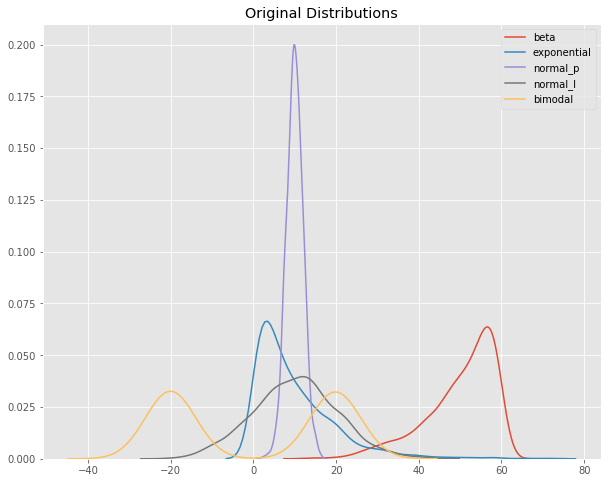

No entanto, é importante observar que a normalização pode afetar a natureza da distribuição dos dados. Por exemplo, se tivermos várias distribuições diferentes, como Beta (vermelha), exponencial (azul) e duas normais (roxa e verde), a aplicação da normalização fará com que todas essas distribuições se movam para uma média de 0 e um desvio padrão de 1.



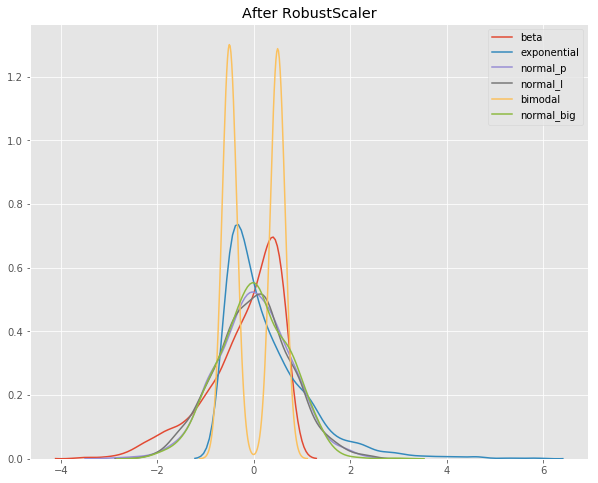

## 5.2 Normalização
Para começar a normalização, primeiro **precisamos avaliar quais variáveis devem ser normalizadas**. Isso é feito ao observar a distribuição dessas variáveis, que foram analisadas anteriormente durante a fase de análise exploratória de dados. A organização do notebook ou ambiente de programação é crucial para facilitar esse processo.

Portanto, voltamos à "Análise Univarida" no notebook, onde as distribuições de todas as variáveis foram analisadas.

Especificamente, queremos focar nas variáveis numéricas, então vamos abrir a subseção "Análise Univarida - Variáveis Numéricas".

Agora, nossa missão é identificar as variáveis que seguem uma distribuição normal. Lembre-se, a normalização é mais eficaz quando aplicada a variáveis que já têm uma distribuição normal. Portanto, o objetivo aqui é identificar quais variáveis têm essa característica:

In [ ]:
# 'num_attributes' é o seu DataFrame
num_attributes.hist(bins=25, figsize=(20, 15), grid=False);  # Aumente o tamanho do gráfico

plt.xticks(fontsize=10);  # Reduza o tamanho das fontes dos ticks do eixo x
plt.yticks(fontsize=10);  # Reduza o tamanho das fontes dos ticks do eixo y

plt.tight_layout()  # Ajusta o layout para que os gráficos não se sobreponham
plt.show()  # Exibe o gráfico


Embora se possa argumentar que algumas variáveis, como a "sales", esteja ligeiramente mais próxima de uma distribuição normal, essas ainda não é verdadeiramente uma distribuição normal. Portanto, considerando a qualidade e as características dos nossos dados, é ideal não aplicar a normalização, evitando assim forçar um ajuste que poderia não ser adequado.

Dessa forma, o próximo passo que vamos seguir será a aplicação da técnica de Rescaling para todas as variáveis. Este método nos ajudará a trazer todas as variáveis para um mesmo intervalo, facilitando assim o trabalho dos algoritmos de aprendizado de máquina na próxima fase do projeto.


## 5.3 Rescaling
Antes de mergulhar diretamente nesse processo, é importante revisitar brevemente a motivação por trás da preparação de dados em projetos de ciência de dados.

Nosso conjunto de dados contém dois tipos principais de variáveis que exigem modificações:

- **Variáveis categóricas**: temos três dessas variáveis em nosso conjunto de dados, que precisam ser convertidas em variáveis numéricas. A razão para isso é que os algoritmos de aprendizado de máquina requerem entradas numéricas para realizar operações de aprendizado. Assim, **a conversão de variáveis categóricas em numéricas é uma etapa fundamental** na preparação de dados.

- **Variáveis numéricas**: muitas variáveis em nosso conjunto de dados **possuem intervalos bastante distintos**. Os algoritmos de aprendizado de máquina tendem a atribuir mais importância às variáveis com valores maiores, o que nem sempre é apropriado. Por exemplo, embora a variável "competition_distance" possua valores significativamente mais altos do que a variável "day_of_week", isso não implica que a primeira seja mais importante que a segunda. Portanto, precisamos equalizar essas diferenças de intervalos para que o algoritmo possa aprender a importância real de cada variável.

Assim, a aplicação da técnica de Rescaling ajuda a colocar todas as variáveis em um intervalo comum, permitindo que os algoritmos de aprendizado de máquina trabalhem de forma mais eficiente.

### 5.3.1. Min-Max Scaler
Temos a técnica de escalonamento conhecida como Min-Max Scaler, especialmente **útil para variáveis que não seguem uma distribuição normal**.

Primeiro, é crucial entender a formulação por trás do Min-Max Scaler. Consideremos uma nova variável numa nova escala, X_scaled. A fórmula que define X_scaled é a seguinte:

X_scaled = (X_i - X_min) / (X_max - X_min)

Onde X_i é o valor original da variável, e X_max e X_min são, respectivamente, os valores máximo e mínimo da variável em questão.

Na prática, o processo envolve as seguintes etapas:

- Escolha a variável numérica para a qual você deseja aplicar o Min-Max Scaler.
- Calcule o valor mínimo (X_min) e o valor máximo (X_max) da variável escolhida.
- Subtraia o valor mínimo de cada valor original da variável (X_i - X_min).
- Divida o resultado pelo intervalo, que é a diferença entre o valor máximo e o valor mínimo (X_max - X_min).
- O resultado dessa operação será o novo valor na nova escala.

Aplicando este cálculo a todos os valores na coluna original, você obterá uma nova coluna de valores numa nova escala.
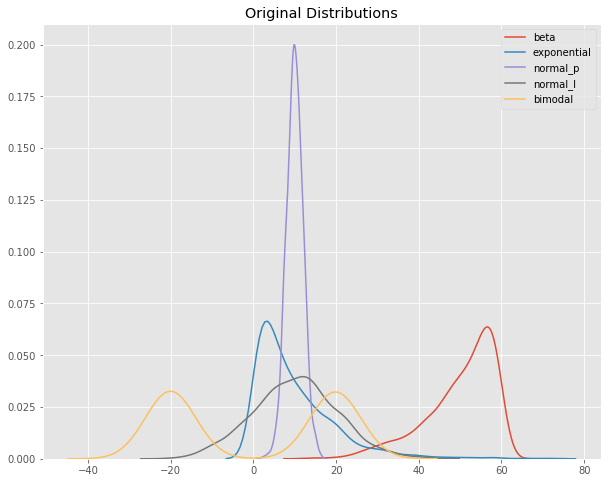

Depois da aplicação de MinMaxScaler:

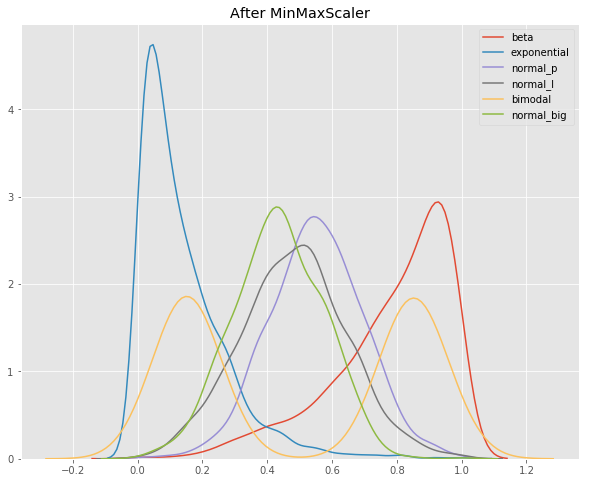

### 5.3.2. Robust Scaler
Vamos explorar outra técnica chamada "Robust Scaler", que, assim como a Min-Max Scaler, é usada para escalonar variáveis, porém, é **menos sensível a outliers**.

O Min-Max Scaler, embora útil, tem uma limitação importante: é altamente sensível a outliers. Isso ocorre porque **se baseia nos valores mínimos e máximos para escalonar os dados**. Portanto, se houver outliers significativos, **esses extremos distorcem a escala**, aglomerando muitos valores próximos ao zero na nova escala. Isso pode, consequentemente, **alterar a distribuição original dos dados**.

Para lidar com esse problema, usamos o Robust Scaler. A ideia por trás dessa técnica é semelhante à Min-Max Scaler, mas **em vez de usar o valor mínimo e máximo, usamos os quartis, que são menos influenciados pelos outliers**.

A fórmula para o Robust Scaler é:

X_scaled = (X_i - Q1) / (Q3 - Q1)

Onde Q1 é o primeiro quartil (25º percentil) e Q3 é o terceiro quartil (75º percentil).

**Aplicamos o Robust Scaler a todas as variáveis que apresentam outliers significativos**. Isso nos permite manter a distribuição original dos dados, sem deixar que os outliers distorçam a nova escala.

No entanto, deve-se ter em mente que embora o Robust Scaler seja menos sensível a outliers, ele pode comprimir os dados de maneira a alterar a natureza da distribuição original.

### Aplicação
O primeiro passo para a aplicação de técnicas de escalonamento é **identificar as variáveis que serão escalonadas**. Fazemos isso selecionando as variáveis numéricas em nossos dados. No Python, podemos utilizar a função **select_dtypes**, que permite selecionar colunas de um DataFrame com base em seus tipos de dados.

In [ ]:
a = df5.select_dtypes(include = ['int64', 'float64'])
a.head()

Nesse código, estamos solicitando que o pandas selecione todas as colunas cujo tipo de dados seja 'int64' ou 'float64', que são os tipos de dados numéricos típicos em pandas. Em seguida, visualizamos as primeiras linhas dessas variáveis para confirmar que as colunas corretas foram selecionadas.

A decisão sobre quais variáveis aplicar o MinMaxScaler ou o RobustScaler depende da natureza dos dados. Decidimos aplicar estas técnicas nas variáveis 'day_of_week', 'competition_distance', 'year', 'month', 'day', 'week_of_year', 'competition_time_month' e 'promo_time_week'.

### Variáveis Cíclicas
Ao preparar os dados para modelagem, é essencial considerar a natureza das variáveis que estamos trabalhando. Identifiamos certas variáveis cíclicas como 'month', 'day', 'week_of_year' e 'day_of_week'. Estas variáveis, por natureza, repetem-se ao longo do tempo, portanto, seria mais apropriado aplicar uma transformação cíclica nelas.

### Variáveis Não Cíclicas

Entretanto, possuímos algumas variáveis que não são cíclicas como 'competition_distance', 'year', 'competitition_time_month', promo_time_week. A questão agora é decidir  aplicar a técnica de escala **MinMaxScaler** ou a técnica **RobustScaler** nessas variáveis. A decisão entre estas duas técnicas geralmente **depende da presença de outliers** nos dados.



Analisar visualmente os dados é uma etapa crucial para determinar a presença de outliers. Ao usar um boxplot para a variável 'competition_distance', por exemplo, podemos identificar se existem outliers significativos:



### 1. **Robust Scaler** em 'competition_distance'

In [ ]:
plt.subplot(1, 2, 1)
sns.boxplot(df5['competition_distance'])

plt.subplot(1, 2, 2)
sns.distplot(df4['competition_distance'])

Neste cenário, como identificamos outliers bem definidos na variável 'competition_distance', a melhor opção é usar o RobustScaler para reescalar essa variável. O RobustScaler é menos sensível a outliers, tornando-o apropriado neste contexto.

Para utilizar o RobustScaler, primeiro precisamos importá-lo da biblioteca Scikit-learn em Python.

In [ ]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']])

Para aplicar o RobustScaler aos dados, usamos método fit_transform(), que ajusta o transformador aos dados e então aplica a transformação. A ideia aqui é que o método fit_transform() irá calcular os parâmetros da fórmula (os quartis neste caso) e então aplicá-los para reescalar os dados.

Agora, a coluna 'Competition distance' tem os mesmos valores, mas numa nova escala. Os outliers que identificamos anteriormente agora terão menos influência no restante dos dados.

In [ ]:
plt.subplot(1, 2, 1)
sns.boxplot(df5['competition_distance'])

plt.subplot(1, 2, 2)
sns.distplot(df4['competition_distance'])

Ao analisar o gráfico da variável 'competition distance', percebemos que a nova distribuição varia de 0 a 30 aproximadamente, com os valores reescalados para um intervalo entre 0 e 1. Esta reescala, realizada através da técnica MinMax Scaler, é um passo fundamental na preparação de nossos dados para a modelagem.

Ao observar a distribuição original da 'Competition distance', vemos que os valores variavam de 0 a 200 mil, com um número significativo de exemplos por volta de 80 mil. Após a aplicação do escalonamento MinMax, a visualização da distribuição com o distplot mantém o mesmo formato, contudo, o intervalo de valores é agora de 0 a 1.

É importante destacar que a transformação MinMax Scaler não altera a distribuição dos dados, mas sim, ajusta a escala para um intervalo comum, o que permite que todas as variáveis tenham a mesma importância na modelagem. A distribuição dos dados permanece a mesma - ou seja, mantém-se o "shape" - mas agora no novo intervalo de valores, de 0 a 1.

Esta é a essência e o poder da técnica de escalonamento MinMax: garantir que todas as variáveis estejam em um intervalo comum, preservando a forma original da distribuição de dados e permitindo comparações adequadas entre diferentes variáveis para a utilização no modelo.

### 2. **Robust Scaler** em 'competition_time_month'
O mesmo aplicaremos à variável'competition_time_month'.


In [ ]:
plt.subplot(1, 2, 1)
sns.boxplot(df5['competition_time_month'])

plt.subplot(1, 2, 2)
sns.distplot(df4['competition_time_month'])

In [ ]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']])

In [ ]:
plt.subplot(1, 2, 1)
sns.boxplot(df5['competition_time_month'])

plt.subplot(1, 2, 2)
sns.distplot(df4['competition_time_month'])

---

### 3. **MinMaxScaler** em 'promo_time_week'


In [ ]:
plt.subplot(1, 2, 1)
sns.boxplot(df5['promo_time_week'])

plt.subplot(1, 2, 2)
sns.distplot(df4['promo_time_week'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']])

In [ ]:
plt.subplot(1, 2, 1)
sns.boxplot(df5['promo_time_week'])

plt.subplot(1, 2, 2)
sns.distplot(df4['promo_time_week'])

### 4. MinMaxScaler em 'year'


In [ ]:
plt.subplot(1, 2, 1)
sns.boxplot(df5['year'])

plt.subplot(1, 2, 2)
sns.distplot(df4['year'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
df5['year'] = mms.fit_transform(df5[['year']])

In [ ]:
plt.subplot(1, 2, 1)
sns.boxplot(df5['year'])

plt.subplot(1, 2, 2)
sns.distplot(df4['year'])

## 5.4 Encoding
Nesta etapa do projeto, discutiremos a transformação de recursos, especificamente a codificação (encoding) de variáveis. A codificação é um processo que **converte variáveis categóricas em numéricas**, mantendo a informação essencial. Este é um passo crucial na preparação dos dados para modelos de aprendizado de máquina, pois **a maioria desses modelos requer entradas numéricas**.

Há uma variedade de métodos de codificação disponíveis, cada um adequado a diferentes tipos de dados categóricos e situações. Embora possa ser comum encontrar referências a apenas dois ou três desses métodos em blogs ou vídeos, na realidade existem mais de dez tipos de codificação para variáveis categóricas.

Com uma infinidade de opções, é natural questionar qual é o "melhor" método de codificação. Infelizmente, a resposta não é direta e **depende em grande parte dos dados específicos com os quais estamos trabalhando**. Aqui estão duas dicas para auxiliar na escolha do método de codificação adequado:

- **Conheça os dados:** Através da análise exploratória, podemos ganhar uma compreensão dos valores únicos (ou "níveis") que as variáveis categóricas podem assumir. Por exemplo, uma variável categórica "cor" pode ter níveis como "preto", "amarelo", "vermelho", "laranja", etc. Ao analisar esses níveis em relação ao objetivo (por exemplo, vendas), podemos obter insights sobre qual método de codificação pode ser o mais adequado.

- **Experimentar diferentes métodos:** Não há substituto para a experimentação. Aprenda e aplique diferentes métodos de codificação aos seus dados e compare os resultados. Novos métodos de codificação estão sendo constantemente desenvolvidos, por isso, é sempre bom estar aberto a novas técnicas.


### Tipos de Encoding
Exploraremos seis dos mais comuns e eficazes métodos de codificação de variáveis categóricas, cada um com suas características distintas:

- **One-Hot Encoding:** Este método, provavelmente o mais conhecido, cria uma nova coluna para cada categoria única na variável original. Cada uma dessas **colunas contém valores binários (0 e 1), representando a presença (1) ou ausência (0)** dessa categoria específica na observação.

- **Label Encoding:** O método de codificação de rótulos **atribui a cada categoria única um número inteiro**. Isso é especialmente útil quando a variável categórica tem muitos valores únicos, o que poderia tornar o One-Hot Encoding ineficiente.

- **Ordinal Encoding:** Muito semelhante ao Label Encoding, este método também atribui um número inteiro a cada categoria única. A diferença é que o Ordinal Encoding **leva em conta a ordem das categorias, sendo adequado para variáveis categóricas ordinais**, onde as categorias têm uma ordem inerente.

- **Target Encoding:** Este método de codificação** usa a média do valor alvo (target)** para uma categoria específica como seu valor codificado. Este método é particularmente útil quando há uma correlação entre a categoria e o valor alvo.

- **Frequency Encoding:** Semelhante ao Target Encoding, mas **em vez de usar a média do valor alvo, usa a frequência da categoria** na base de dados.

- **Binary Encoding:** Este é um método de codificação interessante que **converte cada categoria em um código binário**, sendo uma solução e**ficiente para lidar com variáveis categóricas com muitas categorias**.

Existem muitos recursos excelentes disponíveis para aprender mais sobre esses métodos de codificação. Um desses recursos é um post de [blog](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02#:~:text=Thermometer%20Encoder%20is%20used%20to,form%20a%20new%20numerical%20variable.) escrito por um respeitado profissional da área de ciência de dados. O post cobre cada um desses métodos de codificação em detalhes, ilustrando como cada um funciona com gráficos e desenhos. Além disso, recomendo o pacote [Python category_encoders](https://contrib.scikit-learn.org/category_encoders/), que implementa muitos desses métodos de codificação e pode economizar tempo ao evitarmos escrever tudo manualmente.

### 5.4.1. One-Hot Encoding
Esse enconding converte cada categoria de uma variável categórica em uma nova coluna binária.

Para ilustrar essa técnica, vamos usar a variável categórica 'Temperatura' com os níveis 'Cold', 'Warm', 'Hot' e 'Very Hot'. Ao aplicar o One-Hot Encoding, cada um desses níveis se torna uma nova coluna. Em cada linha, a coluna correspondente ao valor original da variável será marcada com '1' e as demais colunas serão marcadas com '0'.

Aqui, a variável original 'Temperatura' é 'Hot', então na coluna correspondente 'Hot', colocamos '1', e as demais colunas (Cold, Warm, Very Hot) são preenchidas com '0'.



In [ ]:
data = {'Temperatura': ['Hot'], 'Cold': [0], 'Warm': [0], 'Hot': [1], 'Very Hot': [0] }
df = pd.DataFrame(data); print(df)

Essa técnica tem vantagens e desvantagens. Uma grande vantagem é que ela é** simples de aplicar e transforma efetivamente variáveis categóricas em numéricas**. No entanto, ela também **pode aumentar significativamente a dimensionalidade dos dados**, especialmente se a variável categórica tiver muitos níveis. Isso pode ser problemático, pois **pode tornar o aprendizado do modelo mais complexo e ineficiente**.

Apesar dessa desvantagem, o One-Hot Encoding pode ser particularmente útil em determinadas circunstâncias. Por exemplo, ao codificar uma variável categórica que representa um 'estado', como 'feriado'. Um feriado pode ser visto como um estado diferente de um dia regular. Nesses dois estados diferentes, pode haver diferenças significativas de comportamento que podem ser capturadas através do One-Hot Encoding. Isso pode, portanto, melhorar o desempenho de um modelo de aprendizado de máquina ao prever fenômenos que ocorrem em dias regulares versus feriados.

### 5.4.2 Label Encoding
O Label Encoding é outra técnica frequentemente utilizada para transformar variáveis categóricas em numéricas. Este método **associa a cada categoria de uma variável categórica um valor numérico único**. Os números atribuídos não têm necessariamente uma relação ordinal ou significado inerente - eles simplesmente servem para representar as categorias de forma numérica.

Usando o exemplo da variável categórica 'Temperatura' com os níveis 'Cold', 'Warm', 'Hot' e 'Very Hot', o processo de Label Encoding poderia resultar no seguinte:

In [ ]:
data = {'Temperatura': ['Hot', 'Cold', 'Very Hot', 'Warm'], 'Label Encoding': [1, 2, 3, 4]}
df = pd.DataFrame(data); df

Aqui, cada categoria de 'Temperatura' foi substituída por um número único. Não há uma relação ordinal entre esses números; eles simplesmente servem para representar as diferentes categorias.

O Label Encoding é particularmente útil quando se lida com variáveis categóricas que representam entidades nominalmente diferentes sem uma relação ordenada explícita, como nomes de lojas ou marcas de produtos. Embora simples e eficiente, é importante ressaltar que essa técnica pode levar a interpretações errôneas do modelo se a variável categórica tiver uma natureza ordinal. Isso ocorre porque o Label Encoding trata todas as categorias como numericamente equivalentes, independentemente da sua ordem.

### 5.4.3 Ordinal Encoding
O método Ordinal Encoding é uma técnica de codificação de variáveis categóricas que considera a ordem ou a hierarquia às categorias. Esta técnica é útil quando os valores categóricos têm um significado de ordem (como 'baixo', 'médio', 'alto', ou 'frio', 'morno', 'quente', 'muito quente').

Por exemplo, considere a variável categórica 'Temperatura' com os níveis 'Cold', 'Warm', 'Hot', 'Very Hot'. Ao contrário do Label Encoding, que atribui valores numéricos arbitrários, o Ordinal Encoding consideraria a ordem natural dessas categorias. Ou seja, 'Cold' (Frio) é inferior a 'Warm' (Morno), que é inferior a 'Hot' (Quente), que por sua vez é inferior a 'Very Hot' (Muito quente).

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Dados de exemplo
data = {'Temperatura': ['Cold', 'Warm', 'Hot', 'Very Hot']}

# Criação do DataFrame
df = pd.DataFrame(data)

# Aplicação do Ordinal Encoding
encoder = OrdinalEncoder(categories=[['Cold', 'Warm', 'Hot', 'Very Hot']])
df['Temperatura_encoded'] = encoder.fit_transform(df[['Temperatura']])

print(df)


Desta forma, o Ordinal Encoding transfere a ordem natural da variável categórica para a representação numérica, criando assim uma representação mais significativa dos dados para certos algoritmos de aprendizado de máquina.

No entanto, deve-se ter cuidado ao utilizar o Ordinal Encoding com variáveis que não possuem uma relação explícita de ordem, pois isso poderia introduzir uma suposição de ordem onde não existe, possivelmente levando a um modelo de aprendizado de máquina impreciso.

### 5.4.4 Target Encoding

A codificação target funciona calculando a média do valor alvo (target) para cada categoria da variável categórica e substituindo a categoria por esse valor médio.

Para ilustrar, suponha que temos uma variável categórica chamada "Temperatura" com categorias como 'Hot', 'Cold', 'Very Hot' e 'Warm', e uma variável de destino que representa as vendas.

Se aplicarmos a codificação target à variável "Temperatura", cada categoria (nível) será substituída pela média de vendas correspondente a essa categoria.

In [ ]:
data = {
    'temperature': ['hot', 'cold', 'very hot', 'warm', 'hot', 'warm', 'warm', 'hot', 'hot', 'cold'],
    'temp_target': [0.7, 0.5, 0.2, 0.3, 0.7, 0.3, 0.3, 0.7, 0.7, 0.5]}; df = pd.DataFrame(data); df

Este método é particularmente útil para variáveis categóricas com muitos níveis, pois pode lidar com a alta dimensionalidade de forma eficiente, sem a necessidade de criar muitas novas colunas (como no caso da codificação one-hot).

### 5.4.5 Frequency Encoding
A Frequency Encoding é um método útil para tratar variáveis categóricas com muitos níveis. Esse método substitui cada valor categórico pela frequência (contagem) ou proporção de ocorrências desse valor no conjunto de dados.

Para exemplificar, consideremos uma variável categórica "temperatura" com níveis 'Hot', 'Cold', 'Very Hot', e 'Warm'. A codificação de frequência substituiria cada ocorrência de 'Hot' pela contagem total ou proporção de 'Hot' no conjunto de dados.

In [ ]:
data = {
    'temperature': ['hot', 'cold', 'very hot', 'warm', 'hot', 'warm', 'warm', 'hot', 'hot', 'cold'],
    'temp_target': [0.4, 0.2, 0.1, 0.3, 0.4, 0.3, 0.3, 0.4, 0.4, 0.2]}; df = pd.DataFrame(data); df

A codificação de frequência pode ser particularmente útil em casos onde a variável categórica é representativa de um "nome" sem qualquer relação intrínseca entre os níveis. Por exemplo, em um projeto envolvendo marcas de carros, a codificação de frequência poderia ser usada para substituir cada marca ('Chevrolet', 'Ford', etc.) pela frequência de ocorrência dessa marca no conjunto de dados.


### 5.4.6 Embeding Encoding
O encoding de incorporação (Embedding Encoding) é uma técnica muito usada em aprendizado profundo, particularmente em tarefas de Processamento de Linguagem Natural (NLP). Ela permite transformar dados categóricos em vetores numéricos densos de dimensão fixa, onde as palavras ou categorias semelhantes são mapeadas para vetores próximos no espaço de vetores.

Suponha que tenhamos um vocabulário de palavras com "hot", "cold", "very hot", "warm". Em uma representação de incorporação de dimensão 2 (apenas para facilitar a visualização), as palavras podem ser representadas por vetores bidimensionais:

- "hot": [0.1, 0.3]
- "cold": [-0.2, -0.1]
- "very hot": [0.2, 0.4]
- "warm": [0, 0.2]

A chave aqui é que esses vetores não são arbitrários, mas são aprendidos durante o treinamento do modelo, com base em como as palavras ou categorias co-ocorrem no conjunto de dados.

## 5.5 Encoding na Prática
Temos o nosso DataFrame "df5", que inclui uma variável categórica chamada "state_holiday". Esta variável pode assumir diferentes estados, como 'dias regulares', 'Páscoa', 'Natal' e assim por diante.

A codificação One-hot cria novas colunas binárias para cada categoria única presente na variável original. Assim, cada observação recebe um '1' na coluna correspondente ao seu estado e '0' nas demais colunas.

No Pandas, a função get_dummies() pode ser usada para realizar essa transformação de forma simples e eficaz. Por exemplo:

In [ ]:
df6 = df5.copy()

### 5.5.1 state_holiday

In [ ]:
# state_holiday - One-Hot Encoding
df6 = pd.get_dummies(df6, columns=['state_holiday'], prefix='state_holiday');df6

Neste exemplo, o argumento columns especifica a coluna a ser codificada, enquanto o argumento prefix indica o prefixo a ser adicionado ao nome de cada nova coluna.

### 5.5.2 store_type
O pacote sklearn fornece a classe LabelEncoder, que pode ser usada para transformar variáveis categóricas em números. Temos a variável categórica chamada "store_type", com categorias do tipo 'A', 'B' ou 'C'.

O LabelEncoder substitui cada categoria única por um número inteiro. Esta transformação é útil quando as categorias têm uma ordem natural (por exemplo, 'baixo', 'médio', 'alto'), mas também pode ser usada em casos em que a ordem não está clara.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df6['store_type'] = le.fit_transform(df6['store_type'])

Nesse código, o método fit_transform é usado para ajustar o LabelEncoder à variável 'store_type' e, em seguida, transformar essa variável. Em seguida, o resultado é armazenado na mesma coluna 'store_type' no DataFrame original.

Se chamarmos fit_transform nos dados de treinamento, tudo está bem: o LabelEncoder aprende o mapeamento com base nas categorias presentes no conjunto de treinamento e então aplica esse mapeamento ao conjunto de treinamento.

No entanto, se também chamarmos fit_transform nos dados de teste, teremos um problema: o LabelEncoder aprenderá um novo mapeamento, que pode ser diferente do mapeamento aprendido nos dados de treinamento. Isso significa que a mesma categoria pode ser mapeada para números diferentes nos conjuntos de treinamento e teste, o que é confuso para o modelo.

### 5.5.3 assortment
Temos a variável categórica 'Assortment', que contém três categorias: 'Basic', 'Extra' e 'Extended'. Estas categorias têm uma ordem inerente, ou seja, 'Basic' é menor que 'Extra', que por sua vez é menor que 'Extended'.

Nesses casos, é útil mapear essas categorias para números que refletem essa ordem. Para isso, utilizamos o método de codificação ordinal.

Para aplicar a codificação ordinal, primeiro definimos um dicionário que mapeia cada categoria para um número que reflete a sua posição na escala.

Este mapeamento é implementado com o seguinte dicionário:

In [ ]:
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df6['assortment'] = df6['assortment'].map(assortment_dict)
df6.sample()

## 5.6 Transformação dos Dados
A transformação de dados é uma técnica comum em ciência de dados que ajuda a melhorar a interpretabilidade do modelo, a precisão da previsão e a aderência às premissas dos algoritmos de aprendizado de máquina. Existem dois tipos principais de transformações:

- **Transformação de Grandeza:** O objetivo dessa transformação é **aproximar a distribuição da variável resposta de uma distribuição normal**. Muitos algoritmos de aprendizado de máquina, especialmente os baseados em métodos estatísticos, têm como **premissa que os dados seguem uma distribuição normal**. Quando a distribuição da **variável resposta é mais próxima de uma normal, a performance do algoritmo tende a melhorar**. Ou seja, essa transformação ajuda a aumentar a precisão dos modelos, aproximando a distribuição dos dados das premissas dos algoritmos usados.

- **Transformação de Natureza:** Essa transformação tem como objetivo capturar a natureza inerente dos dados dentro do conjunto de dados. Por exemplo, em uma variável que representa os meses do ano, numerados de 1 (Janeiro) a 12 (Dezembro), a proximidade entre os números não reflete a realidade de que Dezembro (12) e Janeiro (1) são meses sucessivos, ou seja, estão próximos. **Quando tratamos essa variável como numérica, perdemos a noção cíclica inerente aos meses do ano**. A transformação de natureza permite que capturemos essa característica cíclica, fazendo com que Dezembro seja considerado próximo a Janeiro, como é na realidade.

### 5.6.1 Tipos de Transformação
Transformações de dados são técnicas usadas para **mudar a escala ou a distribuição dos dados**, e existem várias abordagens para realizá-las. As transformações mais comuns incluem a transformação logarítmica, a transformação Box-Cox, a extração de raiz cúbica, e a extração de raiz quadrada. Essas transformações são particularmente úteis para lidar com dados assimétricos.

- **Transformação Logarítmica:** Uma das transformações mais comuns, a transformação logarítmica, é aplicada tomando o logaritmo de todos os valores da variável. Isso pode ajudar a **tornar as distribuições enviesadas mais semelhantes a uma distribuição normal**.

- **Transformação Box-Cox:** Esta é uma família de transformações parametrizadas que inclui a transformação logarítmica, raiz quadrada, inversa, entre outras, e é usada para criar uma versão mais normal da variável. A transformação Box-Cox tem uma fórmula específica e pacotes de software que automatizam esse processo.

- **Extração de Raiz Cúbica:** Esta transformação envolve tomar a raiz cúbica de todos os valores na variável. É útil quando os dados têm uma assimetria positiva.

- **Extração de Raiz Quadrada:** Similar à extração de raiz cúbica, mas neste caso, estamos tomando a raiz quadrada dos valores.

Essas transformações ajudam a moldar os dados para que se tornem mais compatíveis com as premissas do algoritmo que será usado, aumentando assim a precisão do modelo. No entanto, é importante ressaltar que nem

### Transformação Logarítmica da Variável Resposta 'sales'
O processo para aplicar a transformação logarítmica na variável de resposta é simples. Em nosso exemplo, utilizaremos a função log1p do pacote NumPy, uma função que aplica o logaritmo natural mais 1, para transformar a variável resposta, denominada neste caso como sales.

In [ ]:
plt.subplot(1, 2, 1)
sns.distplot(df6['sales'])

plt.subplot(1, 2, 2)
df6['sales'] = np.log1p(df6['sales'])
sns.distplot(df6['sales'])

Ao visualizar o histograma à direita, esperamos ver uma distribuição que se assemelha mais à forma de um sino, característica de uma distribuição normal. Isso indica que a transformação logarítmica foi bem-sucedida em tornar a distribuição dos dados mais próxima da normalidade.






### Transformação Cíclica Temporal
A transformação de natureza tem como objetivo capturar a "verdadeira natureza" dos dados. Vamos usar um exemplo de dados temporais para esclarecer isso. Se você tem dados mensais que se repetem a cada ano (de Janeiro a Dezembro), isso constitui um ciclo. O desafio é representar essa natureza cíclica nos dados.

Suponha que estejamos no ano de 2023 com meses de Janeiro a Dezembro e o mesmo se repete para 2024. Notamos que há um ciclo: a cada ano que passa, os mesmos meses se repetem.

Imagine um círculo onde cada mês é um ponto ao longo da borda. Agora, a distância entre Janeiro e Fevereiro é a mesma que a distância de Dezembro a Janeiro. Isso porque os dados são cíclicos, onde Janeiro (do próximo ano) segue Dezembro. Se usássemos uma representação linear (por exemplo, números de 1 a 12 para representar os meses), perderíamos essa informação cíclica. O número 1 (Janeiro) estaria distante do número 12 (Dezembro), mas na verdade, eles estão muito próximos em termos de tempo.

Para resolver este problema, podemos usar uma técnica chamada "codificação cíclica", que **se baseia no círculo trigonométrico**. Nessa técnica, cada mês é representado por duas coordenadas: **o seno e o cosseno do ângulo que corresponde a esse mês no círculo**.

Supondo que dividimos nosso círculo em 12 partes iguais (para os 12 meses), Janeiro (representado por 1) teria um seno de 0 e cosseno de 1. Fevereiro, sendo o segundo mês, teria um seno de 0.92 e cosseno de 0.4, e assim por diante para os outros meses.

Assim, cada mês é agora representado por dois valores - seno e cosseno - que juntos capturam sua natureza cíclica. Embora isso possa parecer que estamos aumentando a dimensionalidade dos dados (criando uma coluna adicional), a informação adicional que capturamos **(a natureza cíclica dos dados) supera o aumento da dimensionalidade**.

In [ ]:
df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

Vamos descrever essa etapa de forma mais técnica e concisa:

Selecionando a coluna de meses: A primeira coisa a se fazer é selecionar a coluna 'month' no DataFrame df5. Esta é a coluna que será transformada.

Definindo a função de transformação: Em seguida, definimos a função de transformação que será aplicada a cada valor na coluna de meses. Essa função usa a função seno para transformar cada valor. O valor é multiplicado por 2 * π / ciclo, onde ciclo é a duração do ciclo (neste caso, 12 meses).

A função de transformação é aplicada a cada valor na coluna de meses usando o método apply, que aplica uma função a cada elemento de uma série ou um dataframe. O resultado é armazenado em uma nova coluna chamada 'month_sin'.

Repetindo o processo com a função cosseno: O processo é então repetido, mas desta vez usando a função cosseno. O resultado é armazenado em outra nova coluna chamada 'month_cos'.

Agora faremos o mesmo para as demais varíaveis cíclicas e seus respectivos períodos:

In [ ]:
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

In [ ]:
df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

In [ ]:
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

- **Transformação cíclica para Dias da Semana:** Reconhecemos que o ciclo de um dia da semana é de sete dias, pois uma semana contém sete dias. Portanto, ao aplicar as funções seno e cosseno, utilizamos o número sete como período do ciclo.

- **Transformação cíclica para Mês:** Em seguida, assumimos que um mês, em média, dura 30 dias. Portanto, ao realizar a transformação cíclica para a variável mês, utilizamos o número 30 como o período do ciclo.

- **Transformação cíclica para Semana do Ano:** Finalmente,  um ano tem aproximadamente 52 semanas. Então, ao realizar a transformação cíclica para a variável semana do ano, utilizamos o número 52 como o período do ciclo.

Porém, não se deve aplicar essa transformação cíclica à variável ano, pois ela é considerada uma variável linear e não cíclica, a menos que se possa retroceder no tempo.

---
## Update do Projeto
Aqui está uma descrição passo a passo do nosso projeto de projeção de vendas seguindo a metodologia CRISP-DM:

- **Definição do Problema de Negócio:** A etapa inicial foi entender a demanda do nosso cliente, neste caso, os gerentes de lojas que solicitaram uma previsão de vendas para os próximos seis meses. Essa etapa é crucial para estabelecer os objetivos e limites do nosso projeto.

- **Entendimento do Negócio:** Antes de mergulharmos de cabeça na solução, realizamos um trabalho de investigação para entender melhor o "porquê" dessa solicitação. Descobrimos que **o objetivo final era estipular um orçamento para reforma das lojas**. O valor destinado para as reformas depende do quanto cada loja poderá gerar em faturamento. Portanto, **a previsão de vendas é fundamental para planejar as reformas**.

- **Coleta de Dados:** Uma vez entendido o problema, passamos para a coleta de dados. Para o nosso projeto, os dados foram baixados a partir de uma plataforma Kaggle. No entanto, na prática, coletar dados pode envolver diversas fontes e métodos, desde consultas em bancos de dados até a solicitação de dados através de interfaces de programação (API's).

- **Limpeza de Dados:** Com os dados em mãos, fizemos um "check-up" neles. Primeiro, observamos de maneira geral para entender a extensão e natureza do conjunto de dados. Em seguida, realizamos o "feature engineering", para criar novas variáveis (features) a partir dos dados brutos que temos. Por último, filtramos as variáveis com base em restrições de negócio, ou seja, levamos em conta as regras e limitações que existem no mundo real.

- **Exploração de Dados:** Depois da limpeza, partimos para uma análise mais aprofundada dos dados. Isso envolveu buscar correlações entre as variáveis e gerar hipóteses para entender melhor como os dados se relacionam e como podem nos ajudar a fazer a previsão de vendas.

- **Modelagem de Dados:** Na modelagem, preparamos nossos dados para alimentar um modelo de aprendizado de máquina. Isso incluiu a seleção das variáveis mais relevantes, ou seja, aquelas que acreditamos que o modelo pode aprender melhor para fazer a previsão de vendas.
---

## 6. Feature Selection

### 6.1 Motivação da Seleção de Atributos
A seleção de variáveis é uma etapa crucial em projetos de ciência de dados. Ela se alinha a um dos princípios da aprendizagem estatística, conhecido como princípio da Navalha de Occam, que indica que a explicação mais simples para um fenômeno observado deve ser preferida sobre explicações mais complexas.

Para ilustrar, consideremos o exemplo de descrever um carro. Uma descrição simples pode incluir quatro rodas, dois faróis, uma placa, lanternas e um retrovisor. Essa descrição forma um "modelo", uma representação simplificada de um fenômeno observado (neste caso, um carro).

Alguém pode nos fornecer uma descrição mais complexa, incluindo Bluetooth, wi-fi, quatro portas, câmbio automático, entre outros. Este é também um modelo, mas mais detalhado e complexo. No entanto, nem todos os carros possuem esses recursos. Portanto, esse modelo mais complexo não se aplica a todos os carros e é, por isso, menos generalizável.

Assim, segundo o princípio da Navalha de Occam, **deve-se dar preferência ao modelo mais simples**, pois é mais provável que generalize melhor o fenômeno em questão. Este princípio guia a seleção de variáveis em um projeto de ciência de dados.

Em aprendizagem de máquina, o objetivo é simplificar a aprendizagem usando modelos mais simples, ou seja, modelos com menos variáveis para ajustar. A simplicidade do conjunto de dados está na quantidade de colunas ou variáveis (também chamadas de características ou 'features') que ele contém. Algumas destas variáveis podem ser redundantes ou 'colineares', ou seja, elas explicam a mesma parte do fenômeno observado.

A identificação e remoção de variáveis colineares simplifica o modelo, tornando-o mais eficiente. No exemplo do carro, "quatro rodas" e "quatro pneus" são variáveis colineares que descrevem a mesma coisa. Da mesma forma, "lanternas" e "faróis", e "para-brisa dianteiro" e "janela frontal" são pares de variáveis colineares.

Portanto, a seleção de variáveis envolve identificar e remover variáveis colineares, resultando em um modelo mais simples que pode ser aprendido mais facilmente por algoritmos de aprendizagem de máquina. Existem diversas técnicas para a seleção de variáveis, que serão discutidas e implementadas em estágios posteriores do nosso projeto.


### 6.1.2. Métodos de Seleção de Atributos
- **Seleção Univariada (Filter Methods):** Avalia cada variável individualmente com relação à variável alvo ou variável resposta. Ela verifica a relação estatística entre cada variável de entrada e a variável de saída. As variáveis que apresentam uma relação forte (alta correlação, por exemplo) são selecionadas, enquanto aquelas que apresentam uma relação fraca (baixa correlação) são descartadas.

- **Seleção por Importância (Embedded Methods):** Este método **prioriza variáveis com base na sua relevância estatística** dentro do conjunto de dados. As variáveis são classificadas de acordo com sua importância, ou seja, o impacto que têm sobre a variável de saída ou resultado.

- **Seleção por Subset (Wrapper Methods):** Este método avalia conjuntos de variáveis como um todo para **identificar subconjuntos de variáveis que, em conjunto, fornecem o melhor desempenho**. Este método é especialmente útil quando as variáveis estão correlacionadas entre si.

Cada método utiliza um mecanismo específico para classificar as variáveis como relevantes ou não para o aprendizado do modelo. Além disso, cada abordagem possui suas próprias vantagens e desvantagens, e a escolha do método ideal geralmente depende do conjunto de dados específico e dos objetivos do projeto.

Em ciência de dados, a relevância de uma variável é definida pelo quanto essa variável consegue explicar de um fenômeno que ocorre no mundo real. No contexto de um modelo de aprendizado de máquina, a relevância é uma medida de quão influente uma variável é na previsão do resultado desejado.

Tomemos o exemplo de um projeto que objetiva entender as vendas de um produto. Podemos ter várias variáveis, como preço, ano, promoção e feriados. Cada uma dessas variáveis pode explicar uma porção do fenômeno das vendas. No entanto, **nem todas têm o mesmo grau de influência**. Por exemplo,** a promoção pode explicar uma grande parte do fenômeno** de venda, **enquanto o feriado pode explicar apenas uma pequena parte**. Nesse caso, a promoção é mais relevante do que o feriado para o modelo.

### • Coeficiente de Correlação em Variáveis Numéricas
Para quantificar matematicamente essa relevância, **utilizamos o coeficiente de correlação**, que mede a intensidade da relação entre duas variáveis. O valor deste coeficiente vai de -1 a 1. Se for próximo de 1, indica uma correlação positiva forte, ou seja, quando uma variável aumenta, a outra também tende a aumentar. Se for próximo de -1, indica uma correlação negativa forte, ou seja, quando uma variável aumenta, a outra tende a diminuir. Se for próximo de zero, indica uma correlação fraca, ou seja, as duas variáveis têm pouca relação entre si.

Por exemplo, se plotarmos as vendas em relação ao preço, podemos ver que quanto maior o preço, menor é a venda. Portanto, há uma correlação negativa forte. Se plotarmos as vendas em relação aos anos, podemos ver que quanto mais anos passam, mais vendemos. Portanto, há uma correlação positiva forte. Se plotarmos as vendas em relação à distância até os concorrentes, podemos ver que não há um comportamento claro. Portanto, há uma correlação fraca.

### • Coeficiente de Correlação em Variáveis Categóricas
Em todos esses exemplos, estávamos lidando com variáveis numéricas. Mas e se tivermos variáveis categóricas? Ainda podemos calcular a correlação. Dependendo do tipo de variável (numérica ou categórica), usamos diferentes métodos para calcular a correlação:

- **Entre duas variáveis contínuas:** correlação de Pearson.
- **Entre duas variáveis categóricas:** Cramér's V ou Chi-Square.
- **Entre preditora categórica e alvo contínua:** Análise de Variância (ANOVA).
- **Entre preditora contínua e alvo categórica:** Linear Discriminant Analysis (LDA).

### • Método de Seleção Univariada
O método de seleção univariada envolve a análise da correlação entre cada variável individual ou "univariada" e a variável resposta. Em outras palavras, avalia-se a **relação direta entre cada variável de entrada e a variável que estamos tentando prever** ou classificar.

Entre as vantagens da seleção univariada estão sua simplicidade e eficiência. Isso pode parecer óbvio, mas nem todos os métodos de seleção de variáveis são fáceis de entender ou rápidos de aplicar. A seleção univariada, por sua natureza, é facilmente compreensível e pode ser realizada de maneira relativamente rápida.

No entanto, a seleção univariada tem uma desvantagem significativa: **ela não considera a influência conjunta de múltiplas variáveis na variável resposta**. As variáveis em um conjunto de dados **muitas vezes não operam isoladamente**; elas **podem influenciar umas às outras** e essa interação pode ter um impacto considerável na variável resposta.

Por exemplo, pode haver uma situação em que uma variável individual tenha uma correlação fraca com a variável resposta e, portanto, seria descartada na seleção univariada. No entanto, essa mesma variável, **quando combinada com outra, pode ter uma correlação forte com a variável resposta**.

Portanto, ao usar o método de seleção univariada, **há o risco de excluir variáveis que, quando combinadas com outras**, podem ter uma forte correlação com a variável resposta. Este é um aspecto crítico a ser considerado ao escolher o método de seleção de variáveis a ser utilizado.

Para superar esta limitação, outras técnicas de seleção de variáveis mais sofisticadas e avançadas são usadas, que levam em conta a influência combinada das variáveis.







### 6.1.3. Seleção de Variáveis pelo Método de Importância
A seleção de variáveis pelo método de importância é uma abordagem integral na ciência de dados, diferente do método univariado que se concentra principalmente na correlação entre as variáveis. Esta abordagem é **conhecida também como método embutido**. Sua nomeação deve-se ao fato de que a seleção de variáveis de importância é frequentemente um subproduto do processo de aprendizado de alguns modelos de algoritmos.

Por exemplo, o algoritmo de aprendizado, conhecido como "Random Forest", que é utilizado tanto para classificação quanto para regressão, cria uma "floresta" de árvores de decisão durante o processo de aprendizado. **Para construir uma árvore ótima, o algoritmo seleciona as variáveis mais relevantes**. Logo, a própria ideia de aprendizado do modelo já está embutida na seleção de variáveis por importância. Desta forma, podemos usar o algoritmo não apenas para classificação ou regressão, mas também para identificar as variáveis mais relevantes para o modelo.

Outro exemplo são os algoritmos de regressão regularizados, como o Lasso (Least Absolute Shrinkage and Selection Operator) e o Ridge. **Na regressão regularizada, é atribuído um peso a cada variável**, que é definido por meio do algoritmo de aprendizado. **As variáveis que recebem pesos mais altos geralmente são mais importantes** para o aprendizado do modelo, enquanto as variáveis com pesos menores tendem a ser menos relevantes.

Portanto, **o método de seleção de variáveis por importância é uma ferramenta poderosa**, que permite identificar as variáveis mais relevantes para o aprendizado de modelos complexos, como os utilizados em algoritmos de machine learning. Essa seleção de variáveis é feita como parte integral do processo de aprendizado do modelo, o que a torna um método muito eficiente e eficaz para a seleção de variáveis.

### 6.1.4. Seleção de Variáveis com Gini Impurity
O algoritmo Random Forest utiliza um critério de impureza, especificamente a impureza de Gini, para selecionar variáveis. A impureza de Gini é uma métrica de homogeneidade: a seleção de variáveis se baseia em **dividir o conjunto de dados original em dois subconjuntos o mais homogêneos (ou similares) possíveis**. Se uma variável consegue realizar essa divisão de forma eficaz, ela é considerada importante.

Por exemplo, suponha que temos um conjunto de dados de vendas e decidimos dividir esse conjunto usando a variável "preço". As vendas com preço baixo formam um subconjunto e as vendas com preço alto formam outro. Se os dois subconjuntos resultantes forem homogêneos (ou seja, as vendas em cada grupo são bastante similares), então o "preço" é uma variável importante.

Agora, suponha que decidimos dividir ainda mais o subconjunto de vendas de preço baixo usando a variável "promoção". As vendas a preço baixo fora do período promocional formam um grupo e as vendas a preço baixo durante o período promocional formam outro. Se a variabilidade dentro de cada subconjunto aumentar (ou seja, as vendas em cada grupo não são tão similares), então "promoção" é uma variável menos importante.

A ideia geral, portanto, é que o algoritmo Random Forest seleciona variáveis que dividem o conjunto de dados de forma que os subconjuntos resultantes sejam o mais homogêneos possível. Esse processo ajuda a determinar a importância de cada variável.

Na prática, **treinamos um modelo Random Forest no nosso conjunto de dados de treinamento, e o resultado inclui a importância de cada variável**. Podemos então plotar essas importâncias, o que nos ajuda a entender quais variáveis são mais relevantes para o modelo. Em resumo, a seleção de variáveis com base na impureza de Gini é um método poderoso para identificar as variáveis mais importantes em um conjunto de dados, permitindo-nos criar modelos mais simples e eficazes.

### 6.1.5 Seleção de Variávies com Regressão Lasso
A Regressão Lasso é um método de regressão que pode ser usado para a seleção de variáveis. Ela funciona **impondo uma penalidade aos coeficientes do modelo**, de tal forma que **alguns deles são forçados a ser exatamente zero**. Esse processo é chamado de **regularização**.

A regressão Lasso funciona da seguinte maneira: primeiro, ajustamos o modelo aos nossos dados, que consistem em várias características mais a variável de resposta. Em seguida, examinamos os pesos (ou coeficientes) que o modelo atribuiu a cada variável. Variáveis com um peso significativamente maior ou menor que zero são consideradas importantes, enquanto as que têm um peso próximo de zero podem ser consideradas menos importantes ou irrelevantes.

Por exemplo, se treinamos um modelo Lasso e descobrimos que três variáveis têm os maiores pesos positivos e outras três têm os maiores pesos negativos, podemos considerar essas seis variáveis como as mais importantes. Se tínhamos originalmente 15 ou 16 variáveis, agora reduzimos nosso modelo para apenas seis variáveis, mantendo uma grande parte da explicabilidade do fenômeno que estamos estudando.

### 6.1.6 Seleção de Variávies por Subset (Wrapper Method)
A Seleção por Subconjuntos é um processo iterativo para determinar quais variáveis em um conjunto de dados são mais relevantes para o modelo de aprendizado. A ideia é **examinar todas as combinações possíveis de recursos e selecionar a combinação que resulta no melhor desempenho do modelo**.

Em contraste com os outros dois métodos mencionados anteriormente (seleção univariada e seleção por importância), a **seleção por subconjuntos não depende da correlação entre as variáveis e a variável de resposta**, ou do nível de importância atribuído pelo modelo de aprendizado.

Aqui estão os passos que normalmente são seguidos no processo de seleção por subconjuntos:

- **Seleção Inicial:** Primeiramente, uma única variável é escolhida aleatoriamente do conjunto de dados. Juntamente com a variável alvo (ou variável de resposta), essa variável selecionada é usada para treinar um algoritmo de aprendizado de máquina - como Random Forest ou Gradient Boosting. O desempenho deste modelo inicial é calculado, comumente em termos de acurácia ou erro.

- **Adição e Avaliação de Variáveis:** A seguir, uma nova variável é adicionada aleatoriamente ao modelo. O algoritmo é treinado novamente e o desempenho do modelo é recalculado. Se o desempenho do modelo melhora com a adição desta nova variável (por exemplo, a acurácia aumenta de 62% para 65%), essa variável é mantida no modelo. Esta variável adicionada é considerada informativa, pois traz nova luz ao fenômeno em estudo.

- **Remoção de Variáveis Não-Informativas:** Se a adição de uma nova variável não melhora o desempenho do modelo (por exemplo, a acurácia permanece em 65%), a variável é removida. Essa variável é considerada não informativa, já que não contribui para a compreensão do fenômeno que está sendo modelado.

- **Iteração:** O processo de adição de variáveis, treinamento do modelo e avaliação do desempenho é repetido até que todas as variáveis do conjunto de dados original tenham sido testadas.

- **Resultado Final:** Ao final deste processo, o resultado é um subconjunto de variáveis do conjunto de dados original - apenas as variáveis que são mais relevantes para o fenômeno em estudo.


## 6.2 Seleção de Variáveis com Algoritmo Boruta
O Boruta é um algoritmo utilizado na seleção de variáveis importantes em um conjunto de dados, **baseado no algoritmo Random Forest**. Este método se destaca pela forma como trata a seleção de características, usando o conceito de "variáveis shadow" (ou variáveis sombra).

Em primeiro lugar, o algoritmo **seleciona duas variáveis aleatórias** de seu conjunto de dados original, que serão nomeadas de V1 e V2. Em seguida, cria-se **cópias dessas variáveis, chamadas de "shadow"**, nas quais as linhas são embaralhadas. Esta etapa de embaralhamento é feita para eliminar qualquer correlação entre as variáveis shadow e as originais.

Após essa etapa, o novo conjunto de dados, contendo as variáveis originais e as shadow, é usado para treinar um modelo, geralmente uma Random Forest. Uma vez treinado o modelo, calcula-se a importância de cada uma das variáveis, tanto originais quanto shadow.

A partir daqui, o algoritmo Boruta foca-se nas variáveis shadow. Ele **determina qual variável shadow tem a maior importância e compara essa importância com cada uma das variáveis originais**. Se a importância da variável original for maior do que a variável shadow mais importante, é atribuído o valor 1 a essa variável em uma tabela. Caso contrário, atribui-se o valor 0.

Este processo é repetido várias vezes, com diferentes embaralhamentos das variáveis shadow, resultando em uma tabela que contabiliza a quantidade de vezes que cada variável original superou a importância da variável shadow mais importante.

Uma vez obtida a tabela, é possível **aplicar uma distribuição binomial para calcular o p-valor de cada variável original**. O p-valor é um conceito estatístico usado para determinar se uma hipótese é aceita ou rejeitada. Neste caso, ele ajuda a determinar se uma variável é relevante ou não.

Para finalizar o processo, é estabelecido um limite para o p-valor. Se o p-valor de uma variável for menor do que esse limite, a variável é considerada importante. Caso contrário, é descartada.

Este ciclo é repetido para todas as variáveis do conjunto de dados. No final, o resultado é um conjunto de dados reduzido contendo apenas as variáveis consideradas importantes pelo algoritmo Boruta.

### 6.2.1. Split DataFrame into Training and Test Dataset
Nesta etapa do projeto de ciência de dados, abordaremos a implementação do algoritmo Boruta e a preparação do DataFrame para esse processo.

Inicialmente, é importante compreender que precisamos separar o DataFrame original em duas partes. Antes de proceder com essa divisão, vamos excluir algumas variáveis. O motivo desta exclusão está na etapa de seleção de recursos (feature selection), onde criamos novas variáveis a partir das originais. Para evitar redundâncias, é necessário remover as variáveis originais que deram origem às novas.

Por exemplo, a variável "week_of_year" foi usada para gerar "week_of_year_sin' e 'week_of_yer_cos". Neste caso, a variável original "week_of_year" deve ser eliminada, pois suas informações já estão representadas nas novas variáveis.

Para realizar essa tarefa, criamos uma lista chamada "cols_drop" para anotar as variáveis que precisam ser excluídas.

Depois de identificar essas variáveis, utilizamos o método 'drop' do pandas para excluí-las do DataFrame. Fazemos isso ao redefinir o DataFrame (neste caso, 'df6') para conter apenas as variáveis que não foram excluídas.

In [ ]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis =1)

O argumento 'axis=1' no método drop significa que queremos excluir colunas. Quando o drop é executado, a coluna inteira, com todas as suas linhas, é excluída.

Em suma, o preparo do DataFrame envolve a remoção de variáveis originais que foram usadas para derivar novas variáveis, garantindo assim a limpeza e eficácia dos dados ao implementar o algoritmo Boruta.

### • Split Dataset

Nesta etapa, vamos discutir como dividir nosso conjunto de dados em conjuntos de treinamento e teste.

O objetivo é treinar o modelo com uma parte do conjunto de dados e então usar os dados de teste para medir a precisão do modelo. Para um problema de séries temporais, como o que estamos lidando, é essencial considerar a ordem temporal dos dados ao realizar essa divisão.

Não podemos selecionar aleatoriamente as linhas que pertencerão ao conjunto de treinamento e de teste, pois isso poderia envolver a mistura de dados futuros e passados em ambos os conjuntos. Esta prática pode resultar em "overfitting", onde o modelo simplesmente memoriza os dados de treinamento em vez de aprender com eles.

No nosso caso, estamos lidando com dados de vendas diárias por loja e queremos prever as próximas seis semanas de vendas. Assim, dividiremos nosso conjunto de dados de forma que as últimas seis semanas de vendas sejam usadas como conjunto de teste e o restante seja usado como conjunto de treinamento.

Para realizar isso, primeiro agrupamos nossos dados por loja e calculamos a data mínima e máxima de cada venda. Isso nos ajudará a entender o intervalo de tempo do nosso conjunto de dados.

In [ ]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)



Depois, identificamos a data que é seis semanas antes da data máxima de venda usando o método "timedelta" da classe "datetime". Esta data será o ponto de corte entre nossos dados de treinamento e teste.

Por exemplo, se a data máxima é 31/07/2015, subtraímos seis semanas (ou 42 dias) para obter a data de 19/06/2015. Portanto, usaremos os dados do primeiro dia de venda até 18/06/2015 para treinamento e os dados de 19/06/2015 até a última data para teste.

In [ ]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >=  '2015-06-19']
y_test = X_test['sales']

Finalmente, verificamos se nossa divisão de dados está correta, imprimindo as datas mínimas e máximas de ambos os conjuntos de dados de treinamento e teste. Isso deve confirmar que a data máxima do conjunto de treinamento é um dia antes da data mínima do conjunto de teste e a última data de venda é a data máxima do conjunto de teste. Isso garante que temos um intervalo contínuo de datas e um método de divisão de dados que leva em consideração a natureza temporal dos dados.

In [ ]:
print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

## 6.3 Boruta as Feature Selector
No que diz respeito à divisão de dados para treinamento e teste, já concluímos essa parte. Agora, o que precisamos fazer é implementar o Boruta para seleção de características (ou features).

A classe BorutaPy no Python é usada para implementar a seleção de atributos. Esta classe possui vários argumentos, o primeiro dos quais é o modelo que será utilizado para a seleção de atributos. Neste caso, utilizaremos o modelo RandomForestRegressor.

Outro argumento importante é o número de estimadores. Neste caso, optamos por uma abordagem em que deixamos o algoritmo escolher o melhor número de árvores para a ramificação em 'auto'. Além disso, definimos a saída do log de verbosidade como 2 para que possamos monitorar o progresso do algoritmo, já que este pode demorar algum tempo.

Uma consideração importante é a definição do estado aleatório, ou 'random state'. O Boruta seleciona as variáveis de forma aleatória para gerar o modelo. Para garantir que o algoritmo comece do mesmo ponto sempre que for executado, definimos o estado aleatório como 42.

Para treinar o modelo, utilizamos o método 'fit'. Neste ponto, é crucial lembrar que este método não aceita dataframes como entrada. Portanto, teremos que transformar nossos dados em um vetor de números.

Abaixo, primeiro importamos as classes necessárias. Em seguida, instanciamos o RandomForestRegressor e o Boruta. No processo de preparação dos dados para o Boruta, removemos as colunas 'date' e 'sales' do conjunto de treinamento (X_train) e transformamos o restante em um vetor de valores. Da mesma forma, transformamos o vetor alvo de treinamento (y_train) em um vetor de valores. Finalmente, ajustamos o Boruta com o conjunto de treinamento preparado.


In [ ]:
#from boruta import BorutaPy
#from sklearn.ensemble import RandomForestRegressor

# Definindo RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# Definindo Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# Preparando os conjuntos de treino e teste para o Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Treinando o modelo Boruta
boruta.fit(X_train_n, y_train_n)

### Interpretação Seleção de Variáveis com Boruta
Analisando os resultados do algoritmo Boruta para seleção de recursos, observamos que a ferramenta gera várias informações durante sua execução. Estes são organizados em diferentes categorias, nomeadamente 'Iteration', 'Confirmed', 'Tentative' e 'Rejected'.

'Iteration' é uma representação da iteração atual do algoritmo de um total de 100. Em nosso projeto, o Boruta passou por nove iterações. Este é um valor padrão, já que Boruta executa um máximo de 100 iterações para decidir sobre cada variável. Se atingir a centésima iteração e não puder tomar uma decisão, o algoritmo para.

'Confirmed' indica o número de variáveis que Boruta confirmou como sendo relevantes para o modelo. Neste caso, o algoritmo confirmou 18 variáveis como importantes ou relevantes.

'Tentative' se refere às variáveis sobre as quais Boruta tem dúvidas. Neste estágio, o algoritmo não conseguiu classificar estas variáveis como irrelevantes ou não.

Por fim, 'Rejected' são as variáveis que Boruta rejeitou e considerou não serem relevantes para o modelo. O algoritmo rejeitou nove variáveis em nosso projeto.

Portanto, através da utilização do algoritmo Boruta, fomos capazes de identificar e selecionar as variáveis mais relevantes para o nosso modelo. Também pudemos descartar as variáveis que não contribuem significativamente para a modelagem dos dados, melhorando assim a eficiência e precisão do nosso modelo.


In [ ]:
from numpy import setdiff1d

# Cria uma lista com as colunas selecionadas por Boruta
cols_selected = boruta.support_.tolist()

# Melhores features
X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
cols_selected_boruta = X_train_fs.columns[cols_selected].to_list()

# Colunas não selecionadas pelo Boruta
cols_not_selected_boruta = list(setdiff1d(X_train_fs.columns, cols_selected_boruta))

O método Boruta seleciona e classifica variáveis com base em sua relevância, atribuindo a cada variável um ranking. Para identificar as variáveis selecionadas, usamos o atributo support_ do Boruta, que retorna um vetor booleano indicando quais variáveis foram selecionadas.

Vamos criar uma lista chamada cols_selected que irá armazenar os índices das colunas que foram selecionadas pelo Boruta. Em seguida, para facilitar a visualização e interpretação dos resultados, vamos transformar esses índices em nomes de colunas.

Lembre-se de que nosso conjunto de dados ainda inclui as colunas 'date' e 'sales', que precisam ser removidas antes de continuar com a análise. Como agora estamos trabalhando com índices, não nomes de colunas, vamos criar um novo conjunto de dados chamado X_train_fs, que será uma cópia do X_train original, mas sem as colunas 'date' e 'sales'.

Agora podemos criar um novo conjunto de dados chamado cols_selected_boruta, que conterá apenas as colunas selecionadas pelo Boruta em X_train_fs.

Além disso, é interessante saber quais colunas não foram selecionadas pelo Boruta. Para isso, precisamos comparar as colunas em X_train_fs com as colunas em cols_selected_boruta. Vamos usar a função np.setdiff1d do numpy para isso, que retorna a diferença entre dois arrays. O resultado será armazenado na variável cols_not_selected_boruta.

### Colunas Selecionadas por Boruta
Podemos ver quais variáveis foram consideradas significativas pelo algoritmo.

In [ ]:
cols_selected_boruta

### Colunas Descartadas por Boruta
Por outro lado, Boruta descartou algumas variáveis, considerando-as irrelevantes para o modelo.

In [ ]:
cols_not_selected_boruta

### Conclusão Feature Selection com Boruta
Ao final da fase de seleção de variáveis, devemos fazer uma análise aprofundada dos resultados obtidos com o algoritmo Boruta. Este é o momento de lembrar da análise exploratória de dados realizada anteriormente, onde avaliamos diversas hipóteses e criamos uma tabela para verificar quais delas foram confirmadas, quais foram rejeitadas e qual a relevância de cada uma para o nosso modelo.

O próximo passo é comparar nossas observações com o que o Boruta nos sugeriu como relevante para o modelo. Essa comparação nos permite ter uma visão mais clara e fazer um "match" desses resultados.

Para exemplificar, podemos observar as hipóteses de alta importância (9 a 12). Cada uma dessas hipóteses está ligada a uma variável central. A hipótese 9, por exemplo, afirma que as vendas das lojas deveriam aumentar ao longo dos anos. No entanto, o algoritmo Boruta considerou 'Year' como não relevante. Isso é uma contradição que deve ser avaliada pelo cientista de dados. Lembre-se, você pode fazer a escolha de seguir ou não a sugestão do algoritmo. Uma estratégia sugerida é, na primeira iteração, seguir as indicações do Boruta, e posteriormente, em ciclos subsequentes do processo de análise (CRISP), adicionar variáveis que possam aumentar a precisão do modelo.

Essa estratégia também pode ser aplicada para as outras hipóteses. Por exemplo, a hipótese 10 sugere que as lojas deveriam vender mais no segundo semestre do ano, estando ligada à variável 'Month'. O Boruta considerou 'month_cos' como relevante e 'month_sin' como não relevante, mas podemos optar por incluir ambas em nossa análise.

Da mesma forma, a hipótese 11, que sugere que as lojas deveriam vender mais depois do dia 10 de cada mês, está ligada à variável 'Day'. O Boruta considerou tanto 'day_sin' como 'day_cos' como relevantes, o que confirma nossa hipótese.

Em resumo, é importante realizar esse processo de verificação e análise entre as sugestões do algoritmo e as hipóteses levantadas pela análise exploratória de dados.

## 6.4 Manual Feature Selection

In [ ]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin'
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin'
    'week_of_year_cos']

# columns to add
# feat_to_add = ['date', 'sales']

# final features
#cols_selected_boruta_full = cols_selected_boruta.copy()
#cols_selected_boruta_full

---
## 7. Machine Learning
O campo da ciência de dados é vasto e complexo. Entender o papel dos algoritmos de aprendizado de máquina (Machine Learning) é fundamental para aplicá-los corretamente em suas respectivas áreas. Um algoritmo de aprendizado de máquina é capaz de aprender o comportamento de um fenômeno - neste caso, vendas - baseado nas variáveis disponíveis, para depois usar esse aprendizado para generalizar para outros exemplos. Isso é semelhante à maneira como os humanos aprendem, associando características a objetos específicos para facilitar o reconhecimento futuro.

Por exemplo, ao ver um computador, um indivíduo aprende a associar determinadas características - forma quadrada, presença de um teclado, cores preto e cinza - a esse objeto. Quando confrontado com um objeto similar no futuro, o cérebro humano rapidamente identifica-o como um computador devido a essas características. Da mesma forma, algoritmos de aprendizado de máquina são treinados para identificar padrões e, quando apresentados a um novo objeto, utilizam o aprendizado obtido para classificá-lo ou prever seu comportamento.

Embora os algoritmos de aprendizado de máquina sejam sofisticados, métodos mais simples como cálculo de médias ainda são amplamente utilizados em muitas empresas. A média, que é a soma de todos os dados dividida pela quantidade de dados, serve como um resumo útil da variância dos dados. É importante salientar que a média é um modelo simples, mas que tem contribuído significativamente para várias realizações no mundo dos negócios.

Os algoritmos de aprendizado de máquina podem realizar diversas tarefas. Entre elas, a classificação é um processo supervisionado comum em que o algoritmo aprende a mapear as entradas para as saídas corretas, semelhante ao papel de um supervisor ou inspetor que estabelece regras e orientações. No contexto de machine learning, as características ou medidas de um objeto (altura, largura, comprimento, etc.) são usadas para identificá-lo. Um exemplo disso seria identificar um ônibus, um carro ou uma van com base em suas medidas.

Nesse processo, vários exemplos de cada veículo seriam passados para o algoritmo durante o treinamento, permitindo que ele aprenda a correlacionar as entradas com a saída correta. Quando apresentado a um novo conjunto de medidas, o algoritmo compara essas medidas com as do treinamento para classificar o veículo corretamente. É importante notar que o algoritmo só pode classificar objetos que foram incluídos em seu treinamento.

A classificação tem uma ampla gama de aplicações, como diagnóstico de doenças com base em sintomas, identificação de objetos com base em suas características, detecção de fraudes com base em comportamentos suspeitos, e muito mais. Além disso, não se limita apenas à classificação de medidas manuais, mas também pode lidar com imagens e outros tipos de dados.

### • Aprendizado Supervisionado
Em ciência de dados, existem diferentes tipos de problemas que podem ser abordados por meio de técnicas de aprendizado supervisionado. Neste artigo, discutiremos três dessas categorias: Classificação, Regressão e Séries Temporais.

1. Classificação

A classificação é uma tarefa que envolve a atribuição de uma classe a um exemplo de entrada com base em seus atributos. Por exemplo, se tivermos um conjunto de dados de veículos com informações sobre suas características (ou 'features') e os preços de compra, podemos usar um modelo de classificação para aprender a relação entre esses atributos e se um veículo é um carro, uma van ou um ônibus. No entanto, a classificação se limita a prever categorias discretas, ou seja, classes finitas.

2. Regressão

A regressão, por outro lado, é usada quando a variável de resposta é contínua, ou seja, pode assumir infinitos valores. No mesmo exemplo do conjunto de dados de veículos, em vez de prever a classe do veículo, queremos prever o preço de compra do veículo. Nesse cenário, o modelo aprenderá a mapear as características do veículo ao seu preço. Este tipo de problema é chamado de regressão.

3. Séries Temporais

A terceira categoria é a análise de séries temporais, que se concentra na modelagem de dados que são coletados ao longo do tempo. Este método é comumente usado para fazer previsões futuras. Suponha que estamos interessados ​​em monitorar o desgaste do pneu de uma van ao longo do tempo. Podemos medir a espessura do pneu diariamente e usar esses dados para treinar um modelo de série temporal. Com base nesses dados históricos, o modelo pode prever o dia em que o desgaste do pneu atingirá o limite e precisará ser substituído.

Portanto, dependendo do problema em mãos e do tipo de variável de resposta, podemos escolher entre classificação, regressão e séries temporais. Esses são os três tipos principais de problemas que podem ser abordados no âmbito do aprendizado supervisionado. No próximo artigo, discutiremos os problemas de aprendizado não supervisionado e semi-supervisionado.

### • Aprendizado Não Supervisionado
No campo da Ciência de Dados, temos duas abordagens principais para o aprendizado de máquinas: aprendizado supervisionado e aprendizado não supervisionado.

No aprendizado supervisionado, o modelo é treinado em um conjunto de dados rotulados. No entanto, no aprendizado não supervisionado, como o nome sugere, não há supervisão direta. Em outras palavras, não há rótulos pré-definidos para o conjunto de dados e, em vez disso, o modelo tenta identificar padrões e relações por si só.

Para compreender melhor essa diferença, considere o seguinte exemplo: imagine que você tenha uma variedade de frutas em casa. Sem alguém te orientando, você organiza essas frutas na fruteira de acordo com alguns critérios que você escolhe. Talvez você agrupe as bananas juntas, porque são amarelas e curvadas. As uvas podem ser agrupadas porque são pequenas e ficam em cachos. Laranjas e limões podem ser agrupados juntos porque são redondos e têm um galho em um extremo. O critério utilizado para agrupar essas frutas é semelhante às "variáveis" ou "características" que um algoritmo de aprendizado não supervisionado usaria para agrupar dados semelhantes.

Um exemplo ainda mais ilustrativo pode ser encontrado ao considerar um conjunto de silhuetas de animais. Se você não sabe o nome desses animais, pode agrupá-los com base em características que parecem similares para você. Talvez você agrupe alguns animais porque têm quatro patas, um rabo fino e um corpo mais cilíndrico. Outros animais podem ser agrupados porque, embora também tenham quatro patas, têm um rabo pontudo, orelhas pontudas e um focinho mais longo. Esses grupos são semelhantes às "clusters" que um algoritmo de aprendizado não supervisionado pode identificar.

Até agora, discutimos problemas de aprendizado supervisionado, que podem ser resolvidos através de classificação, regressão e análise de séries temporais. Também discutimos problemas não supervisionados, onde, sem uma "resposta correta", o objetivo é agrupar os objetos com base na semelhança de suas características. Esses podem ser resolvidos por meio de técnicas de clustering ou de agrupamento. Este é um breve resumo das principais diferenças entre as tarefas supervisionadas e não supervisionadas em aprendizado de máquina.

### • Aprendizado Semi Supervisionado
O conceito de aprendizado semi-supervisionado é um avanço empolgante na ciência de dados e na aprendizagem de máquinas. Este método combina elementos de aprendizado supervisionado e não supervisionado para otimizar a eficiência do modelo. Acredita-se que a abordagem semi-supervisionada tem o potencial de revolucionar a maneira como aplicamos o aprendizado de máquinas atualmente.

Em métodos tradicionais de aprendizado supervisionado, o modelo é treinado com um conjunto de dados rotulados e então tenta generalizar o aprendizado a partir deste conjunto. No entanto, em um modelo semi-supervisionado, além do aprendizado com base nos dados rotulados, o modelo também é capaz de aprender durante a execução, um processo que chamamos de aprendizado on-the-fly.

O aprendizado semi-supervisionado é implementado através de um sistema de ação-recompensa. Em termos simples, sempre que uma ação é realizada pelo modelo, ele recebe uma recompensa que informa o quão bem ele realizou a tarefa. Dentro desse sistema, temos duas entidades: o agente (o modelo de aprendizado de máquina) e o ambiente. O agente realiza ações sobre o ambiente, que em troca fornece uma recompensa ao agente.

Este ciclo de ação-recompensa permite que o agente explore várias ações possíveis e avalie suas consequências, que podem ser positivas ou negativas. Por exemplo, se uma ação leva a uma recompensa positiva, o agente pode aprender a repetir essa ação em circunstâncias semelhantes. Da mesma forma, se uma ação leva a uma recompensa negativa, o agente aprende a evitar essa ação no futuro.

A plataforma de streaming Netflix, por exemplo, emprega uma equipe de designers criativos que criam múltiplas capas para uma mesma série, como "Stranger Things". Estas capas são então avaliadas pela equipe de dados, que determina qual delas é a mais atrativa para os usuários, com o objetivo final de incentivar mais visualizações.

Esse tipo de problema pode ser resolvido com aprendizado supervisionado, onde se podem extrair métricas das capas para avaliar qual delas funciona melhor. No entanto, o cenário se assemelha mais a um problema de aprendizado semi-supervisionado. Para entender isso, imagine-se navegando na Netflix. Existem várias capas para várias séries, e cada uma delas foi preparada pela equipe criativa.

Nesse caso, a equipe de dados passa por duas fases, chamadas de "exploração" e "exploração com base no aprendizado". Na primeira fase, as capas são apresentadas aleatoriamente aos usuários, e os feedbacks são coletados. Na segunda fase, com base nos dados coletados, as capas que não levaram a visualizações são eliminadas.

Por exemplo, se uma capa específica levou um usuário a assistir à série, essa capa recebe uma recompensa positiva. Se uma capa não levou à visualização, ela recebe uma recompensa negativa. Ao longo do tempo, a equipe de dados começa a perceber que certas capas sempre levam a visualizações, aumentando suas recompensas, enquanto outras são eliminadas. Ao final deste processo, a capa com a maior recompensa é a que será exibida para a maioria dos usuários.

Esse processo pode ser aplicado a uma variedade de situações, como testes A/B em sites, onde se deseja descobrir qual botão leva a mais cliques, por exemplo. O aprendizado semi-supervisionado e o sistema de recompensas se mostram eficazes na resolução de tais problemas.

Em um nível mais amplo, o aprendizado de máquina pode ser usado para resolver uma variedade de problemas. O aprendizado supervisionado pode ser usado para tarefas de classificação, regressão e séries temporais. O aprendizado não supervisionado é útil para agrupamento ou "clustering". O aprendizado semi-supervisionado, que é um tipo de aprendizado por reforço, é um terceiro tipo de problema que a aprendizagem de máquina pode resolver.

Deep learning, que tem se tornado bastante popular, é um tipo de aprendizado supervisionado usado principalmente para o reconhecimento de imagens. As redes neurais profundas ("deep neural networks"), que são a base do deep learning, têm muitas camadas ocultas e cada camada contém vários neurônios. Essas redes conseguem extrair características complexas das imagens à medida que a informação passa por cada camada, sendo portanto altamente eficazes para essa tarefa.

Portanto, a aprendizagem de máquina tem uma ampla gama de aplicações e pode resolver uma variedade de problemas, desde a classificação simples até o reconhecimento de imagens mais complexo.

---
# 7. Algoritmos de Machine Learning
Neste vídeo, vou mostrar cinco implementações dos melhores modelos de aprendizado de máquina, de acordo com minha opinião. Vou compartilhar a estratégia que uso para fazer o modelo funcionar e vou explicar por que escolho cada um dos modelos e por que sua funcionalidade é importante na minha estratégia.

O primeiro modelo que implementaremos é o modelo de média, também conhecido como modelo "average". Você pode nunca ter ouvido falar sobre isso, mas eu lhe garanto que é um dos modelos que você mais usa no dia a dia. O modelo de média funciona colocando os dados na entrada e ele sempre vai prever a média. Por exemplo, se você tem uma loja e quer prever vendas futuras, este modelo sempre dará a média das vendas passadas.

Você pode pensar que isso é muito simples, mas o objetivo do modelo de média não é resolver completamente o seu problema de aprendizado de máquina ou de previsão de vendas. O principal papel do modelo de média é servir como uma base comparativa para a performance dos outros modelos. Se a performance de um modelo de aprendizado de máquina é melhor que o modelo de média, então há um aprendizado real. Mas se um modelo de aprendizado de máquina tem uma performance pior do que a média, a média resolve o seu problema igualmente bem.

O próximo modelo que implementaremos neste projeto é o de regressão linear e de regressão linear regularizada. Geralmente, o modelo de regressão linear regularizada tem um desempenho um pouco melhor que a regressão linear. Eu implemento esses dois modelos primeiro porque sigo o princípio de Occam's Razor, que sugere que devemos dar preferência a modelos mais simples quando possível.

Depois disso, implementaremos os modelos de "Random Forest" e "Gradient Boosting", ambos baseados em árvores e adaptados para regressões. Eles costumam ter um desempenho melhor e se tornaram conhecidos porque muitas pessoas começaram a vencer competições de Kaggle com eles.

Você pode estar se perguntando onde estão os modelos de redes neurais, Deep Learning, CNN e LSTM. Estes são modelos complexos e exigem mais tempo para serem implementados. Estamos seguindo um plano de projeto cíclico e nosso objetivo é completar o ciclo o mais rápido possível para entregar a primeira versão da nossa solução. Em um projeto real, já teríamos passado de quatro a seis semanas neste ponto e haveria uma expectativa crescente por resultados.

---
## Implementing Linear Models
A primeira coisa que faremos é coletar as variáveis que selecionamos com o auxílio do Boruta. Lembre-se, nós tínhamos separado o X_train e o X_test. Vou capturar apenas as colunas que o Boruta selecionou, que são as "cols_selected_boruta", e vou armazená-las numa nova variável também chamada x_train, mas com o "x" minúsculo.

Vou fazer o mesmo para o teste, de maneira que o x_test será o X_test, mas contendo apenas as colunas selecionadas pelo Boruta. Depois, vou fazer algo aqui: vou retornar àquele script anterior e não vou adicionar "date" e "sales" nesse primeiro momento de treinamento dos modelos. Vou reservar isso para mais tarde.

Agora temos todas as colunas mais relevantes de acordo com o Boruta e também nossa própria experiência. Então, vamos começar a partir daqui.

In [ ]:
# Seleciona as colunas mais relevantes para o treinamento, conforme definido pelo Boruta
x_train = X_train[cols_selected_boruta]
x_test  = X_test[cols_selected_boruta]

# Seleciona as colunas mais relevantes para o teste, conforme definido pelo Boruta
x_training = X_train[cols_selected_boruta_full]

---
### 7.1 Average Model
Estamos construindo um modelo para prever a média de vendas de diferentes lojas. Começamos fazendo uma cópia do conjunto de dados de teste 'X_test' e armazenamos essa cópia na variável 'aux1'. Na variável 'aux1', criamos uma nova coluna 'sales', que armazena as vendas reais (ou seja, a variável alvo) do conjunto de teste.

Em seguida, o objetivo é calcular a média de vendas para cada loja. Fazemos isso agrupando os dados por loja e, em seguida, aplicamos a função média à coluna 'sales'. O resultado desse agrupamento e cálculo da média é armazenado na variável 'aux2'.

O próximo passo é anexar as médias de vendas calculadas de volta ao conjunto de dados original 'aux1'. Isso é feito usando a função de mesclagem do pandas, onde 'store' é usada como chave de junção. Isso é importante para que possamos comparar diretamente a média de vendas calculada com as vendas reais para cada loja.

Agora que temos as vendas reais e as médias de vendas calculadas, podemos calcular a performance do nosso modelo. Para isso, definimos uma função chamada 'ml_error'. Essa função recebe três argumentos: o nome do modelo, as vendas reais e as previsões (ou seja, as médias de vendas calculadas).

A função 'ml_error' calcula três medidas diferentes de erro. O primeiro é o erro absoluto médio (MAE), que é a média das diferenças absolutas entre as previsões e os valores reais. O segundo é o erro percentual absoluto médio (MAPE), que é a média das diferenças percentuais absolutas entre as previsões e os valores reais. E o terceiro é a raiz do erro quadrático médio (RMSE), que é a raiz quadrada da média dos erros quadrados.

É importante notar que, para calcular a performance, precisamos reverter a transformação logarítmica aplicada à variável de resposta. Para isso, usamos a função exponencial.

Finalmente, a função 'ml_error' retorna um DataFrame do pandas que armazena o nome do modelo e os três erros calculados.

In [ ]:
# Importando bibliotecas
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# --------------------------------------------------------------------

# Definindo a função de erro médio absoluto percentual (MAPE), recebe valor real (y) e predito (yhat).
def mean_absolute_percentage_error(y, yhat):
    # MAPE é a média dos valores absolutos da (diferença entre o valor real e a previsão) dividido pelo valor real.
    return np.mean(np.abs((y - yhat) / y))

# --------------------------------------------------------------------

# Definindo a função para calcular o erro do modelo
def ml_error(model_name, y, yhat):
    # Calculando o erro absoluto médio (MAE)
    mae = mean_absolute_error(y, yhat)
    # Calculculando erro percentual absoluto médio (MAPE) - Qual é a porcentagem de erro do modelo?
    mape = mean_absolute_percentage_error(y, yhat)
    # Calculando a raiz do erro quadrático médio (RMSE)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    # Retornando um DataFrame com os erros calculados
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# --------------------------------------------------------------------

# Criando uma cópia dos dados de teste
aux1 = x_test.copy()

# Incluindo as vendas reais no dataframe aux1
aux1['sales'] = y_test.copy()

# Calculando a média de vendas para cada loja e armazenando em um novo DataFrame aux2, renomeando sales
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})

# Anexando as previsões (predictions (média) de vendas de cada loja) de volta ao DataFrame aux1
aux1 = pd.merge(aux1, aux2, how='left', on='store')

# Definindo as predições|previsões (yhat) como a média de vendas calculada anteriormente
yhat_baseline = aux1['predictions']

# Performance - calculando os erros entre as vendas reais e as previsões.
# Como fizemos log(y), agora precisamos fazer exp(y) para reverter a transformação e obter os valores originais
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))

 **Obtivemos os seguintes resultados:** a métrica 'MAE' deu um valor de R$ 1.354, o Erro Médio Absoluto Percentual (MAPE) foi de 0.45 (ou seja, 45%) e o Erro Quadrático Médio da Raiz (RMSE) resultou em 1.835.

---
### 7.2 Linear Regression Model
Em nosso projeto, aplicaremos diferentes modelos de aprendizado de máquina para identificar o que melhor se adequa aos nossos dados. Um desses modelos é o de Regressão Linear. A Regressão Linear é um algoritmo supervisionado que prevê um valor de saída com base em variáveis ​​independentes. É usada para problemas de regressão, tais como a previsão de vendas ou o cálculo de tendências de crescimento.

O uso deste modelo envolve três passos principais:

### Model
No treinamento, utilizamos o método "fit" para treinar o nosso modelo. Isso é feito passando os dados de treino (X_train, y_train) para o modelo. O modelo de Regressão Linear aprende a partir desses dados de treino. A linha de código para esta etapa é:

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(x_train, y_train)

Após o treinamento, guardamos o modelo treinado em uma variável chamada 'lr'.

### Prediction
Com o modelo já treinado, podemos fazer previsões nos dados de teste (X_test) que o modelo ainda não viu. Para isso, usamos o método "predict". As previsões são então armazenadas em uma variável chamada 'yhat_lr':

In [ ]:
yhat_lr = lr.predict(x_test)

### Performance
Finalmente, avaliamos o desempenho do nosso modelo. Para isso, utilizamos a função 'ml_error' que recebe o nome do modelo ('Linear Regression'), os dados reais (y_test) e as predições (yhat_lr). É importante notar que, caso os valores tenham sido transformados (como no log), eles precisam ser revertidos à sua escala original usando a função exponencial 'np.expml'. O código para essa etapa é:

In [ ]:
lr_result = ml_error('Linear Regression', np.expml(y_test), np.expml(yhat_lr))

**Obtivemos os seguintes resultados:** a métrica 'MAE' deu um valor de 1867, o Erro Médio Absoluto Percentual (MAPE) foi de 0.29 (ou seja, 29%) e o Erro Quadrático Médio da Raiz (RMSE) resultou em 2671.


### Average Model vs. Linear Model
Para o Modelo de Média, o RMSE foi de 1835, enquanto que para o Modelo de Regressão Linear, o RMSE foi de 2671.

Notamos que o **RMSE do Modelo de Regressão Linear é significativamente maior que o do Modelo de Média**, o que indica que a Regressão Linear apresentou um erro maior ao prever os dados.

Isso sugere duas importantes conclusões:

1. **Superioridade do Modelo de Média:** O RMSE menor do Modelo de Média sugere que, neste caso, ele se saiu melhor na previsão dos dados em comparação ao modelo de Regressão Linear.

2. **Complexidade dos Dados:** A Regressão Linear, por sua natureza, procura padrões lineares nos dados. No entanto, se o nosso conjunto de dados apresenta um comportamento não linear, isso pode explicar a performance inferior da Regressão Linear. Portanto, nossos dados parecem ter um comportamento complexo e, muito provavelmente, modelos lineares não conseguirão aprender efetivamente esse comportamento.

A partir dessas conclusões, é evidente que precisaremos utilizar modelos não lineares para nossas próximas análises. Esses modelos são capazes de capturar a complexidade dos dados e podem fornecer melhores previsões em situações onde os dados não seguem uma relação linear.

---
### 7.3 Linear Regression Regularized Modelo - Lasso
Uma técnica eficaz para aprimorar o desempenho dos modelos de regressão é a **regularização**.

A regularização ajuda a** prevenir o overfitting ao restringir os pesos** associados às características. Uma forma de regularização é o método Lasso (Least Absolute Shrinkage and Selection Operator), que pode **simplificar modelos de regressão complexos tornando alguns desses pesos zero**, efetivamente excluindo algumas características do modelo.

Primeiro, definimos um objeto Lasso com um parâmetro 'alpha' de 0.01. Este parâmetro é muito importante no Lasso, pois **define o grau de regularização que queremos aplicar** aos nossos dados.

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

Após o treinamento do modelo, usamos esse objeto para prever os valores da variável de destino em nosso conjunto de dados de teste:

In [ ]:
yhat_lrr = lrr.predict(x_test)

A seguir, calculamos o erro do modelo regularizado em comparação com os valores reais usando a função 'ml_error'. Neste caso, 'ml_error' é uma função personalizada que calcula as métricas de erro relevantes para avaliar o desempenho do modelo.

Em resumo, ao aplicar a regularização Lasso ao nosso modelo de regressão linear, conseguimos controlar a complexidade do modelo ajustando o parâmetro 'alpha'. Isso nos ajuda a evitar overfitting e a melhorar o desempenho geral do nosso modelo em novos dados.

Se diminuírmos o alpha, ele demorará mais no treinamento, mas retornará resultados melhores.

In [ ]:
lrr_result = ml_error('Linear Regression - Lasso', np.expml(y_test), np.expml(yhat_lrr))

**Obtivemos os seguintes resultados:** a métrica 'MAE' deu um valor de 1891 o Erro Médio Absoluto Percentual (MAPE) foi de 0.29 (ou seja, 29%) e o Erro Quadrático Médio da Raiz (RMSE) resultou em 2744.


---
### • Avaliação dos 3 Primeiros Modelos
Neste estudo, foram explorados três modelos: média, regressão linear e regressão linear regularizada (Lasso).

A avaliação, baseada no erro quadrático médio (RMSE), mostrou que o modelo de média, embora mais simples, obteve o menor RMSE de 1.835. A regressão linear alcançou 2.670 e o Lasso, que previne o sobreajuste por meio de penalidades nos coeficientes, registrou 2.744.

Embora o modelo de média tenha alcançado menor erro, fica evidente a necessidade de modelos não-lineares, dada a complexidade dos dados. Portanto, a próxima etapa será o teste com modelos não-lineares para uma representação mais precisa do fenômeno em estudo. Esta conclusão é crucial, reforçando que soluções mais simples nem sempre são as mais eficazes para fenômenos complexos.

---
###  • Algoritmos Não Lineares
Na etapa anterior, exploramos três modelos lineares de aprendizado de máquina. Agora, vamos prosseguir com modelos não lineares, especificamente o Random Forest.

Embora modelos lineares sejam práticos, nem sempre conseguem captar a complexidade dos dados. Por isso, vamos utilizar o Random Forest, um **modelo não linear mais flexível e capaz de lidar com padrões complexos**.

Nossa estratégia é iniciar com modelos simples, completando o primeiro ciclo do CRISP-DM, um padrão para projetos de mineração de dados. A complexidade aumentará nos ciclos seguintes, conforme a necessidade do projeto.

---
## 7.4 Random Forest Regressor
Este algoritmo baseia-se em árvores de decisão, criando um "bosque" de árvores independentes durante o treinamento. Para novas entradas, a saída é a média das previsões individuais das árvores (no caso de regressão).

O modelo Random Forest é implementado através da biblioteca Scikit-learn ("sklearn"), uma ferramenta Python versátil para modelagem de dados. Uma instância desse modelo é criada sob o nome "rf".

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# model
rf = RandomForestRegressor(n_estimatores=100, n_jobs=1, random_state=42).fit(x_train, y_train)

Ao criar a instância do modelo, fornecemos três argumentos. "n_estimators=100" define o total de árvores de decisão. "n_jobs=-1" indica que todos os processadores disponíveis serão usados para paralelização. "random_state=42" para obter resultados consistentes.

Depois de construir o modelo, aplicamos o método 'fit' aos nossos dados de treinamento (x_train e y_train).

Na etapa de previsão, utilizamos o modelo treinado para gerar estimativas nos dados de teste (x_test), armazenadas na variável yhat_rf.

In [ ]:
# prediction
yhat_rf = rf.predict(x_test)


Por fim, medimos a performance do modelo comparando as vendas reais (y_test) com as previsões do modelo (yhat_rf). Para isso, usamos a função ml_error, e o resultado é armazenado na variável rf_result.

In [ ]:
# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))


Com isso, finalizamos a aplicação do algoritmo Random Forest Regressor, etapa vital em nossa progressão de modelagem de aprendizado de máquina. Durante esse processo, mostramos o treinamento do modelo, a realização de previsões e a avaliação do seu desempenho.

---
## 7.5 XGBoost Regressor
Neste momento, aplicamos um quinto algoritmo de aprendizado de máquina, o XGBoost Regressor. A preferência pelo XGBoost, ou "Extreme Gradient Boosting", deve-se à sua rapidez e eficácia, características que o destacam na área de Ciência de Dados.


In [ ]:
import xgboost as xgb

# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.001,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

Ao instanciar o modelo, são passados vários parâmetros, tais como:

- objective='reg:squarederror': a função objetiva, que neste caso é o erro quadrado para problemas de regressão.
- n_estimators=100: o número de etapas de boosting para executar. Cada estágio do boosting constrói um novo modelo que tenta corrigir os erros dos modelos anteriores.
- eta=0.001: a taxa de aprendizagem do nosso modelo.
- max_depth=10: a profundidade máxima de cada árvore.
- subsample=0.7: a fração dos dados de treinamento para serem usados em cada árvore.
- colsample_bytree=0.9: a fração das colunas a serem amostradas para cada árvore.

Após a criação do modelo, o ajustamos (fit) aos dados de treinamento (x_train e y_train).

Na fase de previsão, usamos o modelo treinado para gerar previsões para os dados de teste (x_test) e armazenamos essas previsões na variável yhat_xgb:

In [ ]:
# prediction
yhat_xgb = model_xgb.predict(x_test)

Para avaliar a performance do nosso modelo XGBoost, calculamos o erro entre as vendas reais (y_test) e as previsões feitas pelo modelo (yhat_xgb). Esses cálculos são realizados através da função ml_error e os resultados são armazenados na variável xgb_result:

In [ ]:
# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))

Implementamos o modelo XGBoost Regressor e suas respectivas etapas: criação do modelo, previsão e avaliação da performance.

---
## 7.6 Model Performance Comparison
A meta aqui é unir e contrastar os resultados dos vários modelos de aprendizado de máquina previamente implementados. Esta etapa nos possibilita identificar o modelo com o menor erro de previsão.

Para alcançar esse fim, usamos uma função do Pandas denominada concat, que nos permite concatenar, isto é, combinar múltiplos DataFrames em um único.

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])

Nessa linha de código, reunimos os resultados de cinco modelos diferentes: o modelo baseline (média), a regressão linear (Linear Regression), a regressão com regularização Lasso (Lasso Regression), o modelo Random Forest e, finalmente, o XGBoost. O resultado dessa concatenação é armazenado na variável modelling_result.

Após concatenar os resultados, queremos ordená-los para identificar qual modelo apresentou o melhor desempenho. A métrica que usamos para esta comparação é o Erro Quadrático Médio (RMSE, do inglês Root Mean Squared Error). Quanto menor o RMSE, melhor o modelo, pois isso significa que ele produziu previsões mais precisas.

Para ordenar os modelos de acordo com o RMSE, usamos a função sort_values, da seguinte maneira:

In [ ]:
modelling_result.sort_values('RMSE')

Neste ponto da análise, organizamos os resultados em ordem ascendente de RMSE para identificar o modelo de melhor desempenho. É essencial notar que o RMSE é uma medida que quantifica o erro do nosso modelo, sendo menores valores indicativos de melhor desempenho.

Nossos testes englobaram modelos Random Forest, XGBoost Regressor (XGBoost), além de outros lineares e não-lineares. O Random Forest destacou-se com o melhor RMSE, de 1011, seguido pelo XGBoost Regressor com 1250 e o modelo de médias com 1835. Os modelos lineares apresentaram desempenho inferior, com RMSE de 2600 e 2744, sugerindo sua inadequação para a complexa tarefa de previsão de vendas.

Esta análise aponta que a previsão de vendas, o fenômeno em estudo, possui natureza complexa e não-linear. Portanto, modelos mais sofisticados, como o Random Forest e o XGBoost, tendem a ter melhor desempenho.

Contudo, vale destacar que o tempo de execução desses modelos complexos pode ser limitante. Se aumentarmos o número de árvores para 2500 ou 3000, o tempo de execução crescerá significativamente, o que pode ser desafiador em um ambiente de produção.

Outra consideração crucial é que o RMSE reportado pode não refletir a performance real do modelo. Isso ocorre porque dividimos os dados em conjuntos de treino e teste, reservando as últimas seis semanas para testes. Dependendo da distribuição dos dados e da volatilidade das vendas, o RMSE pode estar superestimando a performance do modelo.

---
## 7.7 Cross-Validation Method (measuring actual model performance)
Na etapa anterior, implementamos cinco modelos cuja performance foi avaliada com base nos dados das últimas seis semanas. No entanto, esse valor não representa a performance real dos modelos, pois depende do intervalo de tempo escolhido para o teste, que pode corresponder à melhor ou à pior semana de vendas.

Para obter uma medida de desempenho mais precisa, utilizamos a validação cruzada, uma técnica que avalia a performance do modelo em vários intervalos de tempo no conjunto total de dados. A validação cruzada pode ser aplicada em tarefas de classificação ou regressão, bem como em séries temporais, com uma ligeira modificação.

Essa técnica pode ser ilustrada com a metáfora de um baralho de 100 cartas, representando o conjunto de dados. Dividimos o baralho em 10 montes de 10 cartas. Em cada rodada de validação cruzada, usamos 9 montes para treinamento e um para validação. Ao repetir o processo com diferentes montes para teste, garantimos que todas as partes dos dados são usadas tanto para treino quanto para validação.

No final, calculamos a média das performances em todas as rodadas para determinar a performance geral do modelo. Isso nos permite avaliar o desempenho do modelo de forma mais confiável.

Cabe destacar que, no contexto de validação cruzada, os dados de teste são chamados de dados de validação para evitar confusões. Assim, em cada ciclo, o modelo é treinado nos dados de treinamento e testado nos dados de validação, e o resultado é armazenado. A performance real do modelo é calculada como a média desses resultados.

### 7.7.1. Time Series Cross Validation
A validação cruzada para séries temporais é uma técnica especialmente adaptada de validação cruzada comum, preservando a ordem cronológica dos dados, que é vital em séries temporais. Iniciamos com uma parcela inicial dos dados para treinamento e uma subsequente para validação, sempre considerando a sequência temporal. Em cada iteração, o conjunto de treinamento se expande, incorporando os dados de validação da etapa anterior, e um novo período é escolhido para validação.

Por exemplo, se estivermos prevendo as vendas semanais da Rossmann por um período de 6 semanas, com base nos padrões de vendas das semanas anteriores.

Na primeira iteração da validação cruzada em série, usaríamos os dados da primeira semana para treinar o modelo e os dados da segunda semana para validação.

Na segunda iteração, os dados das duas primeiras semanas seriam utilizados para treinar o modelo, e os dados da terceira semana seriam usados para validação.

Esse processo continuaria, sempre expandindo a quantidade de dados de treinamento para incluir os dados de validação da semana anterior, até que a sexta semana fosse usada para validação.

Assim, a cada iteração, o modelo é treinado com mais dados, mantendo a ordem temporal, e validado com dados da semana subsequente. Isso assegura que o modelo seja testado em condições similares àquelas que encontrará na previsão real.


### Filtragem de Dados
Para realizar análises temporais, é crucial tratar os dados corretamente. Vamos considerar um conjunto de dados, chamado "X_train", que possui todas as variáveis que precisamos, porém não inclui as colunas 'date' e 'sales', que são essenciais para nossa análise.

Primeiramente, criamos uma nova coluna chamada 'full', que inclui todas as colunas e copiamos os dados do "X_train" para ela. Então, adicionamos as colunas 'date' e 'sales' que faltavam:

In [ ]:
#columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

x_training = X_train[cols_selected_boruta_full]
x_training.head()

---
### Validação Cruzada K-Fold
Construímos a função de validação cruzada, denominada cross_validation. Esta função aceita os dados de treino, o número de dobras (kfold) e o nome do modelo como entradas. Dentro dela, inicializamos listas vazias para as métricas MAE, MAPE e RMSE.

Durante o processo, executamos uma iteração reversa de 1 até kfold + 1. Em cada ciclo, filtramos os conjuntos de treino e validação com base nas datas. Em seguida, ajustamos o modelo aos dados de treino e realizamos a previsão com os dados de validação.

O desempenho obtido em cada iteração é registrado nas listas de MAE, MAPE e RMSE. Ao final da função, retornamos um DataFrame que contém o nome do modelo, assim como as médias e desvios padrão das métricas, conforme ilustrado no código abaixo.

In [ ]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
  mae_list  = []
  mape_list = []
  rmse_list = []

  for k in reversed(range(1, kfold+1)):
    # Defina o início e o fim da validação baseado na data
    validation_start_date = x_training['date'].max() - datetime.timedelta(k*7*6)
    validation_end_date   = x_training['date'].max() - datetime.timedelta((k-1)*7*6)

    # Filtrando o conjunto de dados
    training   = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    # Training and Validation dataset

    # Training
    xtraining = training.drop(['date', 'sales'], axis=1)
    ytraining = training['sales]

    # Validation
    xvalidation = validation.drop(['date', 'sales'], axis=1)
    yvalidation = validation['sales']

    # Ajuste do modelo
    m = model().fit(xtraining, ytraining)

    # Previsão
    yhat = m.predict(xvalidation)

    # Calculando o erro
    m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

    # Armazenando a performance de cada iteração
    mae_list.append( m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])

  # Retornando as médias e desvios padrão das métricas
  return pd.DataFrame({'Model Name': model_name,
                       'MAE CV'    : np.round(np.mean(mae_list),  2).astype(str) + '+/-' + np.round(np.std(mae_list),  2).astype(str),
                       'MAPE CV'   : np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                       'RMSE CV'   : np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)})


---
### Detalhamento da Função Cross Validation
Agora que possuímos os dados adequados, iremos dividi-los em dois grupos: treinamento e validação. Para isso, vamos definir uma data de início e outra de término para a validação, que serão chamadas de "validation_start_date" e "validation_end_date", respectivamente. Essas datas são definidas com base na data mais recente do nosso conjunto de dados e no número de semanas que pretendemos reservar para a validação:

Por exemplo, se os nossos dados vão até a data 'D' e decidimos usar as últimas 6 semanas para a validação, então "validation_end_date" será a data 'D' e "validation_start_date" será a data 'D' menos 6 semanas.

Com esse procedimento, conseguimos simular uma situação real em que treinamos nosso modelo com dados passados (conjunto de treinamento) e avaliamos sua habilidade de prever eventos futuros (conjunto de validação).

In [ ]:
'''
# start date for validation
validation_start_date = x_training['date'].max() - datetime.timedelta(k*7*6)

#end date for validation
validation_end_date = x_training['date'].max() - datetime.timedelta((k-1)*7*6)

Tendo determinado as datas de início e término da validação, podemos agora subdividir nossos dados em conjuntos de treinamento e validação. O conjunto de treinamento incluirá todos os dados anteriores à "validation_start_date". Por sua vez, o conjunto de validação conterá os dados compreendidos no período entre "validation_start_date" e "validation_end_date".

In [ ]:
'''
# filtering dataset
training = x_training[x_training['date'] < validation_start_date]
validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

Podemos então verificar se os dados foram filtrados corretamente, verificando as datas mínimas e máximas dos subconjuntos de treinamento e validação:

In [ ]:
'''
training['date'].min()
training['date'].max()
validation['date'].min()
validation['date'].max()

Essa abordagem assegura que nossos subconjuntos estejam apropriadamente organizados para as análises futuras. O valor 'k' na fórmula que aplicamos para definir as datas de começo e fim da validação pode ser alterado para ajustar o número de semanas a ser considerado na validação, possibilitando uma análise temporal resistente e versátil.

### Detalhamento Validação Cruzada
O primeiro passo é a preparação dos dados. Temos colunas 'data' e 'vendas' em nosso conjunto de dados que não devem ser usadas para treinar o modelo. Portanto, essas colunas são removidas dos dados de treinamento e validação.


In [ ]:
'''
xtraining = training.drop(['date', 'sales'], axis =1 )
validation = validation.drop(['date', 'sales'], axis=1)
xvalidation = validation.drop(['date', 'sales'], axis =1)
yvalidation = validation['sales']

### Criação e Treinamento do Modelo

Com os dados preparados, o modelo de Regressão Linear é criado e treinado com o conjunto de treinamento.

In [ ]:
'''
lr = LinearRegression().fit(xtraining, ytraining)

### Predição e Avaliação

O modelo treinado é usado para fazer previsões no conjunto de validação. A performance do modelo é então avaliada usando uma função de erro personalizada 'ml_error'.

In [ ]:
'''
yhat_lr = lr.predict(xvalidation)
lr_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat_lr))

Na etapa final, invocamos a função cross_validation passando os dados de treinamento, o número de dobras e o modelo. O modelo usado neste exemplo é a Regressão Linear. Além disso, adicionamos um parâmetro opcional 'verbose' à função que controla se as iterações devem ser impressas ou não.

---
### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result

In [ ]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', model)
lr_result_cv

Nesse cenário, a função cross_validation recebe cinco parâmetros: o conjunto de dados para treinamento (Extreme), o número de divisões (cinco, neste caso), o nome do modelo ('Linear Regression'), o modelo treinado (LR) e o nível de detalhamento das informações exibidas durante o processo (falso).

O processo de validação cruzada implica em dividir o conjunto de dados em cinco partes (devido à escolha de cinco divisões) e, em seguida, treinar o modelo em quatro delas, deixando uma parte para testes. Isso é repetido cinco vezes, cada vez com uma parte diferente deixada de fora para testes.

Ao final dessas iterações, obtemos cinco medidas de desempenho, que são então usadas para calcular a média e o desvio padrão. Estas duas métricas juntas nos dão uma visão mais precisa do desempenho do modelo. Por exemplo, em uma das execuções, obtivemos um Root Mean Square (RMS) de 2.671, mas o RMS médio foi de 2.900, indicando que a primeira execução teve um desempenho superior ao usual.

É importante salientar que a performance real do modelo é dada pela média mais ou menos o desvio padrão, nesse caso, o erro real deste modelo é de 2.900 mais ou menos 500. Isso nos dá uma faixa de variação para a performance do modelo, o que é mais confiável do que uma única medida pontual.

---
### 7.3.1 Lasso - Cross Validation
Assim como no caso anterior, a função cross_validation recebe cinco parâmetros: o conjunto de dados para treinamento (x_training), o número de divisões (neste caso, mantemos cinco), o nome do modelo ('Lasso'), o modelo treinado (LRR) e o nível de detalhamento das informações exibidas durante o processo (definido como falso).

Na continuidade do nosso projeto de previsão de vendas, vamos agora aplicar a validação cruzada no modelo Lasso, uma forma de regressão linear regularizada. E

A função cross_validation é acionada com cinco parâmetros: o conjunto de treinamento (x_training), o número de divisões (mantido como cinco), o nome do modelo ('Lasso'), o modelo treinado (lrr) e um marcador para a exibição de informações detalhadas durante o processo (definido como falso).

O código correspondente fica assim:

In [ ]:
lrr_result

In [ ]:
model = Lasso(alpha=0.01)
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

A validação cruzada, que subdivide os dados em cinco partes, treina o modelo em quatro delas e o testa na quinta, produz um novo conjunto de medidas de desempenho.

O RMSE da última semana de vendas foi cerca de 2.952, mas o RMS médio da validação cruzada foi de 3.057, com um desvio padrão de 504. Isso sugere que a variação do desempenho do modelo está entre 2.500 a 3.500.

A real performance do modelo é então dada pela média mais ou menos o desvio padrão, ou seja, 3.057 ± 504. Isso destaca o valor da validação cruzada para fornecer uma avaliação do modelo mais precisa e robusta. A semana de vendas com RMS inferior à média foi provavelmente uma semana atípica de alto desempenho. Porém, com a validação cruzada, conseguimos capturar uma gama maior de cenários, incluindo semanas de desempenho tanto superior quanto inferior.

---
### 7.4.1 Random Forest Regressor - Cross Validation

Continuando nossa exploração de diferentes modelos de aprendizado de máquina para a previsão de vendas, a próxima etapa envolve a utilização do modelo de Regressão de Floresta Aleatória (Random Forest Regressor).

Na Regressão de Floresta Aleatória, múltiplas árvores de decisão são treinadas e suas previsões são combinadas para produzir um resultado final mais robusto e preciso. Novamente, vamos implementar a validação cruzada para avaliar a performance do nosso modelo.

A função cross_validation é usada novamente, mas desta vez, o parâmetro que indica o modelo treinado será o modelo de Floresta Aleatória, representado aqui pela variável 'rf'. Optamos por habilitar o parâmetro verbose, permitindo assim o acompanhamento em tempo real do progresso do processo.

O comando para implementar a validação cruzada para o modelo de Regressão de Floresta Aleatória é o seguinte:

In [ ]:
rf_result

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv

Após a execução desta linha de código, obteremos as medidas de desempenho para o modelo de Floresta Aleatória. Estes resultados, assim como nos casos anteriores, nos fornecerão uma visão mais precisa da capacidade do modelo de realizar previsões precisas nas vendas.

---
### 7.5.1. XGBoost Regressor - Cross Validation
A última abordagem que vamos analisar para a previsão de vendas é o uso do XGBoost Regressor, um modelo de aprendizado de máquina avançado que usa o conceito de boosting para gerar previsões precisas. Esta análise será realizada na subseção 7.5.1 do nosso script.

A técnica de boosting se refere ao treinamento de modelos consecutivos, onde cada modelo subsequente aprende com os erros cometidos pelo modelo anterior. O XGBoost, em particular, é um algoritmo que se destacou em várias competições de aprendizado de máquina devido à sua alta eficiência e precisão.

A implementação da validação cruzada para o XGBoost Regressor é similar à que realizamos para os modelos anteriores. A função cross_validation é novamente utilizada, com o conjunto de treinamento, o número de folds, o nome do modelo e o modelo treinado (neste caso, 'model_xgb') sendo passados como parâmetros. O parâmetro verbose é definido como True para permitir o acompanhamento do progresso do processo em tempo real.

A linha de código a ser executada para realizar a validação cruzada com o XGBoost Regressor é a seguinte:

In [ ]:
xgb_result

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

Depois de executar esta linha de código, obteremos as métricas de desempenho para o XGBoost Regressor. Esses resultados nos permitirão avaliar o desempenho deste modelo em comparação com os modelos anteriores e selecionar o modelo que oferece a melhor precisão nas previsões de vendas.

---

## Algoritmo de Previsão de Vendas
Finalizamos a etapa de aplicação dos algoritmos de previsão de vendas, que incluiu o uso do modelo de Regressão Linear, Lasso Regressor, Random Forest Regressor e XGBoost Regressor. Agora, vamos comparar o desempenho de cada um desses modelos para selecionar aquele que apresenta a melhor precisão.

Para isso, vamos criar duas tabelas de desempenho: uma com a performance de cada modelo em um único fold (subseção 7.6.1 - Single Performance) e outra com o desempenho real dos modelos, medido através da validação cruzada (subseção 7.6.2 - Real Performance - Cross Validation).

### 7.6.1. Single Perfomance
Na subseção 7.6.1, vamos concatenar os resultados de cada modelo em um único DataFrame, chamado 'modeling_result', e classificar os modelos de acordo com o valor do Erro Quadrático Médio (RMSE - Root Mean Squared Error). A linha de código a ser executada é a seguinte:

In [ ]:
modeling_result = pd.concat(['baseline_result', 'lr_result', 'lrr_result', 'rf_result', 'xgb_result'])
modeling_result.sort_values('RMSE')

### 7.6.2. Real Performance - Cross Validation
Na subseção 7.6.2, vamos realizar um processo similar, mas agora considerando os resultados da validação cruzada. O código a ser executado é:


In [ ]:
modeling_result_cv = pd.concat(['lr_result_cv', 'lrr_result_cv', 'rf_result_cv', 'xgb_result_cv'])
modeling_result_cv.sort_values('RMSE')

A execução dessas linhas de código nos fornecerá duas tabelas: uma apresentando a performance de cada modelo em um único fold e outra mostrando o desempenho real dos modelos, obtido através da validação cruzada. A partir desses resultados, podemos selecionar o modelo que melhor atende às nossas necessidades de previsão de vendas.

### Conclusão Algoritmo
Chegamos ao final da etapa de treinamento e avaliação dos modelos de previsão de vendas. Nesta etapa, utilizamos quatro modelos diferentes: Linear Regression, Lasso Regression, Random Forest e XGBoost.

Ao analisar os resultados obtidos após a execução do Cross Validation, percebemos que o modelo Random Forest apresentou uma performance superior aos demais, com um RMSE (Erro Quadrático Médio Raiz) médio de 1256, sendo este valor consideravelmente menor do que os demais modelos. Isso indica que o Random Forest, em geral, tem um desempenho muito satisfatório, sendo um algoritmo rápido para treinar e muito eficaz para problemas de classificação e regressão.

Contudo, apesar da performance superior do Random Forest, optamos por continuar o projeto com o modelo XGBoost. Essa decisão foi tomada por dois motivos principais. Primeiro, o XGBoost tem ganhado fama recentemente devido a seus resultados promissores em diferentes cenários, porém ainda existe pouca informação disponível sobre a implementação desse modelo, o que nos motiva a explorá-lo mais a fundo. Segundo, em um projeto recente, observamos que o modelo Random Forest, embora apresentasse uma performance ligeiramente superior, tinha um tamanho consideravelmente maior, tornando o custo de manutenção desse modelo em produção significativamente mais alto.

Apesar de optarmos pelo XGBoost, é importante ressaltar que a escolha do modelo depende do cenário e dos objetivos de cada projeto. Além disso, os passos que apresentamos até aqui podem ser aplicados a qualquer modelo de Machine Learning.

Finalizamos a comparação dos modelos e seus respectivos desempenhos, e no próximo passo do projeto, vamos nos concentrar no ajuste fino dos hiperparâmetros do modelo XGBoost. Essa etapa é essencial para melhorar ainda mais o desempenho do algoritmo e consiste em otimizar os parâmetros que regulam o aprendizado do modelo.

---
### Update do Progresso do Projeto Rossmann
Neste momento fornecemos uma visão geral do progresso atual do nosso projeto de previsão de vendas para a Rossman, buscando esclarecer as etapas envolvidas para os envolvidos no projeto.

O projeto se baseia em um processo de 10 passos, inspirado no ciclo CRISP-DM, uma metodologia conhecida na ciência de dados para conduzir projetos de aprendizado de máquina.

A primeira etapa envolveu a **definição do problema**: a Rossman precisa prever as vendas de suas lojas para determinar o orçamento de reformas.

Na segunda etapa, buscamos **compreender o problema em sua raiz**. Conversamos com stakeholders, identificando que a previsão de vendas para as próximas seis semanas seria uma solução adequada.

A terceira etapa consistiu na **coleta de dados**. Em um contexto real, isso pode envolver consultas SQL, APIs, dados manualmente inseridos, entre outros. No nosso caso, obtivemos os dados a partir da plataforma Kaggle.

Em seguida, realizamos a **limpeza dos dados**. Esta etapa engloba a descrição dos dados, a derivação de características a partir das variáveis originais (feature engineering) e a filtragem de dados com base em restrições do negócio.

Na quinta etapa, **exploramos os dados para compreender o negócio** e identificar as variáveis relevantes para o aprendizado do modelo. Validamos hipóteses e realizamos testes estatísticos.

Na etapa de **preparação dos dados**, codificamos as variáveis categóricas e aplicamos transformações em variáveis numéricas e categóricas para melhorar o desempenho do modelo.

Na etapa seguinte, **filtramos as variáveis** com base em sua relevância para o aprendizado do modelo, utilizando um algoritmo chamado Boruta.

Na **etapa de modelagem**, implementamos cinco algoritmos de machine learning, incluindo modelos lineares e não-lineares, além de um modelo baseado em médias.

Atualmente, estamos na etapa de **ajuste de hiperparâmetros (fine-tuning), otimizando o algoritm** XGBoost, apesar de seu desempenho ser ligeiramente inferior ao Random Forest.

As próximas etapas envolverão a **avaliação do desempenho do modelo** e a decisão sobre sua implementação na produção, concluindo assim a primeira versão da nossa solução para o problema de previsão de vendas da Rossman.

---
# 8.0 Fine Tuning
No contexto de nosso projeto de previsão de vendas, a técnica de ajuste de hiperparâmetros desempenha um papel fundamental para otimizar a performance de nossos modelos de Machine Learning.

Os hiperparâmetros podem ser vistos como **configurações ajustáveis em nossos modelos que influenciam como eles aprendem** a partir dos dados. Para ilustrar, imagine-os como os botões de um rádio, que você ajusta até obter a melhor recepção possível.

A título de exemplo, ao trabalhar com redes neurais, os hiperparâmetros podem envolver o número de neurônios, o número de camadas ocultas ou a função de ativação utilizada. Em modelos de "Random Forest", os hiperparâmetros podem ser o número de estimadores ou a profundidade máxima das árvores.

Escolher os valores corretos para esses **hiperparâmetros é uma etapa decisiva para o sucesso do nosso modelo**. Se bem ajustados, eles têm o potencial de melhorar significativamente a precisão da previsão de vendas e minimizar o risco de overfitting - quando o modelo se ajusta excessivamente aos dados de treinamento e falha ao se deparar com novos dados.

Diferente de escolher os valores desses hiperparâmetros aleatoriamente, e**mpregamos técnicas inteligentes de busca e otimização para encontrar os melhores valores que otimizam** o desempenho de nosso modelo de previsão de vendas. Este processo é essencial para melhorar a precisão de nossas previsões de vendas.

Existem três estratégias principais para realizar o ajuste de hiperparâmetros:

- **Random Search:** Esta estratégia **seleciona aleatoriamente valores para os hiperparâmetros**. Embora seja simples, pode não encontrar o conjunto ótimo de parâmetros.

- **Grid Search:** Esta estratégia testa **todas as combinações possíveis de valores para os hiperparâmetros**. Apesar de ter o potencial de encontrar a combinação ótima, pode ser um processo computacionalmente intensivo e demorado.

- **Bayesian Optimization:** Esta estratégia utiliza a teoria de Bayes para selecionar os valores dos hiperparâmetros. A otimização bayesiana **busca o conjunto de hiperparâmetros que maximiza a função de probabilidade** posterior.

Cada uma dessas estratégias tem suas vantagens e desvantagens, e a escolha entre elas dependerá do contexto específico e dos recursos disponíveis.

---
### • Random Search
Este método funciona selecionando aleatoriamente valores dentro de um conjunto predefinido para os hiperparâmetros do modelo. Os hiperparâmetros, ajustáveis manualmente, orientam como o modelo aprende a partir dos dados.

Para dar um exemplo mais claro, consideremos cinco hiperparâmetros em um modelo XGBoost: número de estimadores (n_estimators), subamostra (subsample), profundidade máxima (max_depth), taxa de aprendizado (eta) e peso mínimo da criança (min_child_weight). Cada um desses hiperparâmetros pode assumir uma série de valores elegíveis, que são definidos de acordo com as necessidades do projeto.

O processo do Random Search é realizado em interações. Em cada interação, o método seleciona aleatoriamente um valor de dentro do conjunto de valores possíveis para cada hiperparâmetro. Em seguida, o modelo é treinado e testado com esses parâmetros selecionados e o desempenho do modelo é registrado. O processo é então repetido na próxima interação. Ao final das interações, escolhe-se o conjunto de hiperparâmetros que resultou na melhor performance do modelo.

A principal vantagem do Random Search é a sua velocidade e simplicidade na implementação, especialmente quando comparado a outras técnicas de ajuste de hiperparâmetros. Contudo, o método também tem suas desvantagens. Devido à sua natureza aleatória, o Random Search pode selecionar o mesmo conjunto de hiperparâmetros em diferentes interações, o que pode ser considerado uma perda de tempo. Além disso, devido à mesma natureza aleatória, pode acontecer de o Random Search não encontrar o conjunto de hiperparâmetros que otimize ao máximo o aprendizado do modelo, pois a busca pode terminar antes de todas as combinações possíveis serem exploradas.

Em resumo, o método Random Search é rápido e fácil de implementar, mas pode acabar repetindo hiperparâmetros já testados e, devido à seleção aleatória, pode não selecionar o melhor conjunto de hiperparâmetros para maximizar o aprendizado do modelo. Em próximas partes do projeto, abordaremos outras técnicas de ajuste de hiperparâmetros, como o Grid Search e a Bayesian Optimization.

---
### • Grid Search
Primeiro, falamos sobre a estratégia de Random Search (Busca Aleatória), que opera por meio de interações, selecionando aleatoriamente um valor para cada hiperparâmetro. Treina-se e testa-se o modelo com esses valores, geralmente usando a técnica de validação cruzada (Cross Validation) e registra-se a performance do modelo. Esse processo é repetido em diversas interações. No final, seleciona-se o conjunto de hiperparâmetros que resultou na melhor performance.

Em seguida, discutimos o Grid Search (Busca em Grade), uma estratégia que, ao contrário do Random Search, não seleciona os valores aleatoriamente. O Grid Search procura encontrar o melhor conjunto de valores testando todas as combinações possíveis de hiperparâmetros. Para cada combinação, o modelo é treinado e testado, novamente utilizando a técnica de validação cruzada, e registra-se a performance. No final, escolhe-se o conjunto de hiperparâmetros que deu a melhor performance.

No entanto, o Grid Search tem uma desvantagem significativa em relação ao tempo que leva para testar todas as combinações possíveis de hiperparâmetros. Esse tempo pode ser extenso, especialmente se houver muitos hiperparâmetros e se cada um puder assumir muitos valores possíveis. Em algumas situações, o Grid Search pode levar meses para completar, o que pode ser impraticável em muitos cenários de negócios.

Ainda assim, vale ressaltar que o ajuste de hiperparâmetros, embora seja uma etapa importante no treinamento de um modelo de aprendizado de máquina, não é a única coisa que influencia a performance do modelo. Aspectos como a qualidade e a quantidade dos dados, a relevância das características (features) e a escolha do algoritmo adequado também são fatores críticos. Portanto, embora o ajuste de hiperparâmetros possa ajudar a melhorar a performance de um modelo, ele não deve ser visto como a solução definitiva para alcançar altos níveis de precisão.

---
### • Bayesian Search
O primeiro método, Random Search, escolhe valores aleatórios para os parâmetros do modelo, o que resulta numa execução rápida e de baixo custo. Contudo, a principal desvantagem é que, pela sua natureza aleatória, pode não identificar o melhor conjunto de parâmetros.

Por outro lado, o Grid Search testa todas as combinações possíveis de parâmetros. Este método tem a vantagem de quase garantir a localização do melhor conjunto de parâmetros, maximizando a precisão do modelo. A desvantagem, no entanto, é o alto custo de tempo e recursos computacionais, o que pode não ser viável em todos os contextos empresariais.


Usando a formulação bayesiana, nosso objetivo é encontrar a probabilidade de um determinado erro, dado que selecionamos um conjunto específico de valores para os parâmetros do modelo. No entanto, como não conhecemos antecipadamente os valores de parâmetros ideais, isso seria difícil de calcular. Aqui reside o cerne da busca bayesiana: ao invés de calcular a probabilidade do erro dado os parâmetros, calculamos a probabilidade dos parâmetros dado o erro.

A vantagem principal da busca bayesiana é que ela é mais direcionada, baseando-se nos aprendizados anteriores para ajustar os parâmetros de forma mais eficiente. Isso a torna mais rápida que o Grid Search e mais precisa que o Random Search. A desvantagem é que o conceito pode ser um pouco complexo para compreender inicialmente, mas há uma vasta quantidade de literatura disponível para estudo.

Concluindo, em nosso projeto, faremos uso do Random Search devido ao seu custo-benefício favorável e pela facilidade de implementação em qualquer algoritmo. No entanto, incentivamos a pesquisa e a compreensão das outras estratégias para expandir o seu conhecimento na área de aprendizado de máquina.

## 8.1. Random Search
Em nosso projeto de previsão de vendas, estamos utilizando o algoritmo XGBoost para criar nosso modelo preditivo. Uma etapa crítica na construção de qualquer modelo de aprendizado de máquina é a seleção de hiperparâmetros. Esses hiperparâmetros incluem:

- **n_estimators:** O número de árvores a serem construídas pelo modelo.
eta: A taxa de aprendizado.
- **max_depth:** A profundidade máxima de cada árvore.
- **subsample:** A fração das amostras a serem usadas para ajustar os modelos de árvore individuais.
- **colsample_bytree:** A fração de colunas a serem usadas em cada árvore.
- **min_child_weight:** O peso mínimo necessário em uma folha.
Para cada hiperparâmetro, definimos um conjunto de valores possíveis:

In [ ]:
import random
import warnings
warnings.filterwarnings('ignore')

# Definindo os hiperparâmetros para a busca aleatória (Random Search)
param = {
    # n_estimators refere-se ao número de árvores de decisão na floresta
    'n_estimators' : [15, 17, 25, 30, 35],
    # eta é a taxa de aprendizado
    'eta': [0.01, 0.03],
    # max_depth é a profundidade máxima das árvores
    'max_depth': [3, 5, 9 ],
    # subsample é a fração dos exemplos de treinamento a serem usados em cada árvore
    'subsample': [0.1, 0.5, 0.7],
    # colsample_bytree é a fração de colunas a serem usadas em cada árvore
    'colsample_bytree': [0.3, 0.7, 0.9],
    # min_child_weight é a soma mínima dos pesos de instância necessários em um filho
    'min_child_weight': [3, 8, 15]
}

A busca aleatória é realizada para um número específico de iterações, definido pela variável MAX_EVAL. Para cada iteração, um conjunto de hiperparâmetros é selecionado aleatoriamente e utilizado para treinar um modelo XGBoost. O desempenho desse modelo é então avaliado através da validação cruzada.

Aqui está a estrutura básica do nosso código para a busca aleatória:

In [ ]:
MAX_EVAL = 2

final_resulta = pd.DataFrame()

for i in range(MAX_EVAL):
  # Escolhe valores para parâmetros de forma aleatória
  hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
  print(hp)

  # Inicializando o modelo XGBoost com os hiperparâmetros selecionados
  model_xgb = xgb.XGBRegressor( objective        = 'reg:squarederror',
                                n_estimators     = hp['n_estimators'],
                                eta              = hp['eta'],
                                max_depth        = hp['max_depth'],
                                subsample        = hp['subsample'],
                                colsample_bytree = hp['colsample_bytree'],
                                min_child_weight = hp['min_child_weight'])
  # Avalia a performance do modelo utilizando validação cruzada
  result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
  final_result = pd.concat([final_result, result])

final_result

### Atenção!
Após a execução das iterações de otimização, é fundamental analisar os resultados para identificar a melhor combinação de hiperparâmetros. Cada iteração é composta por uma combinação única de hiperparâmetros que foram selecionados aleatoriamente, resultando em uma performance diferente para cada iteração.

Na primeira iteração, foram escolhidos determinados valores para os hiperparâmetros, enquanto que na segunda iteração, outros valores foram selecionados. A performance do modelo foi calculada para cada conjunto de hiperparâmetros.

Para determinar qual iteração forneceu a melhor performance, a métrica Root Mean Square Error (RMSE) foi usada para comparar os resultados. Esta métrica é comumente usada para avaliar a performance de modelos de previsão, pois fornece uma quantificação do erro do modelo, ou seja, a diferença entre os valores previstos pelo modelo e os valores reais.

No caso analisado, a segunda iteração apresentou um valor de RMSE menor do que a primeira iteração. Isto indica que o conjunto de hiperparâmetros selecionado na segunda iteração resultou em um modelo com uma melhor performance.

Portanto, na prática, o cientista de dados anotaria os valores dos hiperparâmetros da segunda iteração, pois são esses que proporcionaram a melhor performance, de acordo com a métrica RMSE.

Este passo é crucial para a construção de um projeto de previsão de vendas, pois permite identificar e selecionar os hiperparâmetros que otimizam a performance do modelo, melhorando assim a precisão das previsões de vendas.

## 8.2. Final Model
Após a realização do processo de otimização dos hiperparâmetros do nosso modelo de previsão de vendas, identificamos que o conjunto de parâmetros da segunda iteração foi o que ofereceu a melhor performance, segundo a métrica RMSE.

Deste modo, selecionamos os valores otimizados para os hiperparâmetros da seguinte maneira:

In [ ]:
# Definindo hiperparâmetros otimizados
param_tuned = {
          'n_estimators'    : 30,
          'eta'             : 0.03,
          'max_depth'       : 9,
          'subsample'       : 0.1,
          'colsample_bytree': 0.7,
          'min_child_weight': 15.
}

Em seguida, o modelo XGBoost foi treinado com os hiperparâmetros otimizados e os dados de treinamento. As previsões foram geradas usando o conjunto de dados de teste.

In [ ]:
# Modelo
model_xgb_tuned = xgb.XGBRegressor( objective        = 'reg:squarederror',
                                    n_estimators     = param_tuned['n_estimators'],
                                    eta              = param_tuned['eta'],
                                    max_depth        = param_tuned['max_depth'],
                                    subsample        = param_tuned['subsample'],
                                    colsample_bytree = param_tuned['colsample_bytree'],
                                    min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# Predição
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

Finalmente, a performance do modelo otimizado foi avaliada utilizando o método 'ml_error'. Este método compara os valores reais das vendas ('y_test') com as previsões geradas pelo modelo ('yhat_xgb_tuned'). A função exponencial foi aplicada a ambos os conjuntos para reverter o logaritmo aplicado em etapas anteriores do projeto.

In [ ]:
# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expml(y_test), np.expml(yhat_xgb_tuned))
xgb_result_tuned

Com isso, temos um modelo otimizado com valores de hiperparâmetros que deverão oferecer uma previsão de vendas mais precisa. Cada hiperparâmetro ajustado tem um impacto significativo no desempenho do modelo, e é por isso que o processo de otimização é uma etapa crucial na construção de um projeto de previsão de vendas.

Com a definição desses valores, seguimos para a etapa de treinamento e validação do nosso modelo de previsão, sempre com o objetivo de melhorar a precisão e a confiabilidade das nossas previsões de vendas.

---
## Rossmann Project Status
Chegamos finalmente no estamos na etapa 9 do nosso projeto de previsão de vendas, onde vamos tratar de um assunto extremamente importante: a **interpretação e tradução do erro**. Esse passo nos ajudará a entender como a performance do nosso modelo de machine learning se converte em resultados concretos para o nosso negócio. Ou seja, vamos descobrir como dizer ao chefe quanto dinheiro nosso modelo pode trazer, e o que uma acurácia de 70% realmente significa em termos financeiros, em número de novos clientes, e assim por diante.

Mas, antes de mergulhar nisso, vamos atualizar nosso progresso no projeto para garantir que todos estejam na mesma página.

Então, o nosso primeiro passo foi entender a questão do negócio, o problema real que estamos tentando resolver. Com base nessa compreensão, fizemos uma coleta de dados cuidadosa, utilizando SQL para fornecer a base para nossos modelos.

O próximo passo foi a limpeza dos dados. Antes de fazer qualquer coisa com nossos dados, precisávamos ter certeza de que eles estavam em boas condições - sem outliers indesejados ou valores que precisavam ser substituídos.

Depois disso, era hora de realmente entender os dados que tínhamos. Fizemos várias análises, validamos nossas hipóteses e adquirimos uma compreensão clara do problema e do negócio.

Com nossos dados compreendidos e limpos, o próximo passo foi prepará-los para a modelagem. Isso envolveu a transformação dos dados para adequá-los aos modelos de machine learning, que nem sempre lidam bem com variáveis categóricas ou outras características dos nossos dados brutos.

Então, foi hora de treinar nossos modelos. Implementamos vários algoritmos, desde modelos lineares a não lineares, e comparamos a performance deles com um modelo baseline para avaliar o desempenho de cada um.

Agora, chegamos ao ponto em que estamos prontos para avaliar nosso algoritmo. Vamos olhar para a performance do nosso modelo e avaliar o impacto que ele pode ter no negócio. Se a performance for boa o suficiente, colocamos o modelo em produção. Se não, fazemos ajustes e iteramos até que estejamos satisfeitos.

Lembre-se, ao longo desse projeto, nosso objetivo é resolver um problema real de negócios. A ciência de dados e o machine learning são ferramentas que estamos usando para fazer isso, mas o verdadeiro valor vem de aplicá-los de maneira eficaz para melhorar nosso negócio.

Então, vamos continuar com a avaliação do nosso algoritmo e ver o que descobrimos.


---
## 9.0 Error Translation and Interpretation
O projeto de previsão de vendas demanda a condução de uma avaliação meticulosa do erro e a correção da escala dos dados. Neste artigo, vamos abordar ambas essas tarefas importantes, focando na clareza e precisão para facilitar a compreensão por indivíduos não familiarizados com o campo técnico da ciência de dados.

Para avaliar o erro, primeiramente é necessário selecionar as colunas pertinentes do conjunto de testes (X_test), que foram identificadas durante a etapa de seleção de características (feature selection), utilizando a técnica de Boruta. Essas colunas são armazenadas na variável cols_selected_boruta_full. Além disso, colunas como 'date' (data) e 'sales' (vendas) são usadas no processo, visto que desempenharam papéis cruciais na validação cruzada (cross-validation).

In [ ]:
df9 = X_test[cols_selected_boruta_full]

Depois de ter os dados necessários para calcular o erro, é preciso lembrar que os dados foram transformados para a escala logarítmica para o modelo de previsão. Portanto, eles precisam ser revertidos para a escala original para que o erro possa ser calculado na mesma escala dos dados originais.

Essa reversão é realizada através da aplicação da transformação exponencial, que é a inversa da transformação logarítmica. A biblioteca NumPy oferece um método conveniente para isso, np.expm1(), que é aplicado tanto nas vendas quanto nas previsões feitas pelo modelo.

In [ ]:
# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

Neste ponto, as vendas previstas ('predictions') são derivadas de yhat_xgb_tuned, que são as previsões feitas pelo modelo de aprendizado de máquina otimizado ('tuned').

Em suma, esses passos são cruciais para avaliar corretamente o erro do modelo de previsão e garantir que os dados estejam na escala correta para a interpretação dos resultados e tomada de decisões empresariais.

### 9.1 Business Performance
O principal objetivo é traduzir os resultados das análises de dados em termos que possam ser facilmente compreendidos pelo time de negócios. Portanto, em vez de apenas apresentar métricas de acurácia do modelo, procuramos apresentar as informações de forma que correlacionem diretamente com o impacto financeiro da empresa.

Primeiro, é importante sumarizar as predições de vendas para cada loja, pois estamos interessados no valor total previsto de vendas para cada uma delas. Para fazer isso, criamos uma nova variável, df91, que contém as somas das predições para cada loja.

In [ ]:
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

Em seguida, calculamos o erro médio absoluto (MAE) e o erro percentual absoluto médio (MAPE) para cada loja. Essas métricas são importantes para entender o desempenho do modelo em termos de negócios. O MAE indica o erro absoluto de cada previsão, enquanto o MAPE representa esse erro em termos percentuais.

In [ ]:
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

Em seguida, combinamos essas métricas em um único dataframe para facilitar a análise.

In [ ]:
df9_aux3 = pd.merge(df9_aux1,  df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

Com isso, é possível fornecer ao time de negócios uma previsão de vendas, juntamente com o MAE e o MAPE para cada loja. Além disso, calculamos o melhor e o pior cenário para as previsões, subtraindo e adicionando o MAE, respectivamente, ao valor previsto. Isso permite que o time de negócios tenha uma ideia mais concreta dos possíveis resultados.

O nosso objetivo é calcular a receita total das próximas seis semanas para cada loja. Nesse cálculo, estamos levando em conta todas as vendas que serão realizadas no período indicado.

Contudo, é importante notar que toda previsão possui um certo grau de erro, algo inerente a qualquer modelo preditivo. Por exemplo, para a Loja 1, identificamos no MAE um erro de 306 unidades na previsão. Isso representa 7% das vendas reais que esta loja faz em média.

Vamos considerar um outro exemplo. Para a Loja 4, a previsão é de que serão vendidos 345 mil reais nas próximas seis semanas. Mas é preciso considerar que este valor pode conter um erro de 855 unidades, o que corresponde a 8% do total.

Aqui, estamos falando do Erro Médio Absoluto (MAE), que é uma medida que quantifica a média dos erros absolutos entre as previsões e as observações reais. Ele é útil para entender o quão próximas (ou distantes) estão as previsões da realidade, podendo o erro ser tanto positivo quanto negativo.

Assim, ao apresentar a previsão de vendas, o que pretendemos é oferecer também a margem de erro, ou seja, o pior e o melhor cenário possível. Isto permite que o gestor da loja faça uma análise mais completa, considerando a variação que pode ocorrer nas vendas. Por exemplo, uma previsão de vendas de 162 mil reais pode apresentar uma margem de erro de 7%. Parece razoável? Então, o gestor precisa considerar qual é a variação possível para essa previsão, ou seja, quais são os cenários mais otimista e pessimista que poderiam ocorrer.

In [ ]:
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df92.sample()

Para tornar isso compreensível, vamos considerar a loja 638 como exemplo. Segundo as nossas projeções, esperamos gerar uma receita de 232.000 reais nas próximas seis semanas. No entanto, é importante lembrar que toda previsão tem um certo grau de erro. Neste caso, o erro é de 6%. Isso significa que se tivéssemos uma previsão de venda média de 100 reais, na realidade poderíamos vender entre 94 e 106 reais. Essa diferença de 6% representa um valor de 437 reais. Portanto, no pior cenário, venderíamos 232.000 reais e no melhor, 233.000 reais.

Tal análise ajuda o gestor da loja a tomar uma decisão mais informada. Se o erro do modelo é relativamente baixo, por exemplo, 7%, o gestor pode se inclinar para o cenário mais otimista. Se o erro é maior, como 18% para a loja 642, o gestor pode preferir o cenário mais pessimista.

A chave para fazer essa transição entre as métricas do modelo de machine learning e o mundo dos negócios é traduzir os termos técnicos para uma linguagem mais compreensível. Ao invés de discutir sobre o Erro Médio Absoluto (MAE), é mais produtivo discutir em termos de receita, melhores e piores cenários, e a porcentagem de erro.

É importante esclarecer porque não usamos a métrica de acurácia em previsões de regressão. Acurácia é geralmente utilizada em problemas de classificação, como distinguir entre fotos de gatos e cachorros. Em uma previsão de regressão, como a que estamos trabalhando, estamos interessados em quão próximas nossas previsões estão do valor real. Para medir isso, usamos o erro, que nos diz quão distantes estamos do valor real. Portanto, a acurácia não é apropriada nesse caso, pois estamos trabalhando com valores próximos do real, como 98, 100, ou 102, e não com valores binários de sim ou não.

Em resumo, o que importa é entender o quão próximas as previsões estão do valor real e quão certo o algoritmo está sobre o valor. Quanto mais próximo de zero o erro, mais confiável a previsão. Quanto maior o erro, menos confiável. Portanto, a chave para uma boa comunicação entre os cientistas de dados e os gestores de negócios é traduzir as métricas de performance do modelo para termos de negócio compreensíveis.

No processo de desenvolvimento de um projeto de previsão de vendas, encontramos algumas lojas que são mais desafiadoras em termos de previsão. Por exemplo, podemos observar que temos um erro percentual absoluto médio (MAPE) de 7% para a loja 932 e 18% para a loja 642. Essa variação indica que algumas lojas podem ser mais difíceis de prever do que outras.

Uma forma eficaz de visualizar isso é ordenar os dados de acordo com o valor do MAPE. Para fazer isso, utilizamos um comando de classificação em nosso dataframe 'df92'. Queremos ordenar os dados de forma decrescente para ver as lojas com os maiores erros de previsão primeiro. Portanto, a sintaxe do código seria a seguinte:

In [ ]:
df92.sort_values('MAPE', ascending = False).head()

descobrimos que a loja 292 possui um Erro Percentual Absoluto Médio (MAPE) de 56%, indicando que nossas previsões para esta loja podem estar off em mais da metade do valor real. Isso é bastante significativo, pois um erro de 50% poderia significar uma previsão que está 50% acima ou abaixo do valor real.

Este cenário claramente requer estratégias alternativas para melhorar a precisão das previsões. Poderíamos, por exemplo, criar modelos específicos para as lojas que apresentam maior desafio, ou incluir mais variáveis em nossos modelos existentes para melhor compreender a complexidade dessas lojas específicas.

Para visualizar estas diferenças entre as lojas, podemos usar um gráfico de dispersão (scatterplot). No eixo x, colocamos as lojas ('store') e, no eixo y, o valor do MAPE. Cada ponto no gráfico representa uma loja, e a posição do ponto ao longo do eixo y indica o valor do MAPE para essa loja. O código seria o seguinte:

In [ ]:
sns.scatterplot(x='store', y='MAPE', data=df92)

No gráfico gerado, vemos que, embora a maioria das lojas tenha um MAPE em torno de 10%, existem outliers significativos, como as lojas 292 e 900, que têm um MAPE maior que 50%. Algumas lojas também apresentam um MAPE em torno de 30%. Essa visualização fornece uma visão clara das lojas que exigem maior atenção para melhorar nossas previsões de vendas.

### 9.3 Total Performance
Para fornecer uma visão geral da previsão de vendas, é útil resumir os melhores e piores cenários para todas as lojas. Isso pode ser útil, por exemplo, para fornecer uma visão geral rápida para os stakeholders do projeto.

Primeiro, extraímos três colunas do nosso dataframe 'df92', que são 'predictions', 'worst_scenario', e 'best_scenario'. Essas colunas contêm nossas previsões, bem como os piores e melhores cenários de vendas, respectivamente.

Em seguida, aplicamos uma função lambda para somar todos os valores de cada uma dessas colunas. A função 'apply' é usada junto com a função 'lambda', que percorre e soma os valores ao longo do eixo zero (ou seja, somando os valores de cada linha para cada coluna). O resultado é um novo dataframe 'df93', onde cada linha representa um cenário e a soma total de valores para esse cenário.

Depois disso, redefinimos o índice do dataframe para facilitar a leitura e renomeamos as colunas para 'Scenario' e 'Values'.

Finalmente, formatamos a coluna 'Values' para exibir os valores em formato de moeda real brasileira (R$). Isso torna os resultados mais legíveis e fornece uma visão clara do valor total previsto para cada cenário. O código é o seguinte:

In [ ]:
# Fazendo a soma para as colunas 'predictions', 'worst_scenario', 'best_scenario'
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Values'})

# Formatando a coluna 'Values' para exibir os valores em formato de moeda
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)

# Visualizando o dataframe df93
df93

Nosso dataframe 'df93' agora nos permite visualizar as previsões para as próximas seis semanas em todas as lojas.

Nas previsões, esperamos fazer vendas de R$285 milhões. No pior cenário, projetamos vendas de R$285 milhões e 115 mil. No melhor cenário, a previsão sobe para R$286 milhões e 605 mil. É importante lembrar que, apesar da tentação de subtrair um cenário de outro para determinar a acurácia, isso não é apropriado neste contexto, pois a "acurácia" é um termo melhor aplicado a problemas de classificação, não de regressão.

Após essas etapas, queremos visualizar os dados em gráficos. Ao trabalhar com dados, especialmente em um projeto de ciência de dados, a visualização gráfica pode ser uma ferramenta extremamente útil. Os gráficos não só nos permitem entender melhor os dados, como também são uma forma eficaz de comunicar nossas descobertas a outras pessoas, especialmente aquelas que não têm experiência técnica no assunto.

### 9.3 Machine Learning Performance
Neste etapa criamos duas colunas que visam facilitar a construção de gráficos para análise dos resultados. Essas colunas, denominadas 'error' e 'error_rate', são calculadas da seguinte maneira:

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

O 'error' representa a diferença entre as vendas reais e as vendas previstas, enquanto o 'error_rate' é a proporção das previsões em relação às vendas reais.

Utilizamos quatro gráficos distintos para a visualização e interpretação dos dados. O código abaixo descreve a geração desses gráficos:

In [ ]:
plt.subplot(2, 2, 1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'SALES')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])

No primeiro gráfico, usamos linhas para traçar as vendas e as previsões ao longo do tempo. O gráfico ilustra a proximidade entre as vendas e as previsões durante um período de seis semanas, mostrando que a previsão se mantém próxima das vendas.

O segundo gráfico é um line plot do 'error_rate' ao longo do tempo. Este gráfico ajuda a visualizar o desempenho do modelo. Se o 'error_rate' for igual a um, significa que a previsão é perfeita. Se for maior que um, o modelo está superestimando as vendas, e se for menor que um, está subestimando.

O terceiro gráfico é um 'distplot' que mostra a distribuição do erro. Uma distribuição próxima da normal é um bom indicativo, sugerindo que o erro está bem distribuído.

O quarto e último gráfico é um 'scatterplot' de previsões versus erros. Este gráfico é importante na análise de resíduos, um método utilizado para identificar pontos fracos no modelo e orientar aprimoramentos futuros.

Esses gráficos e cálculos servem como uma tradução do erro do modelo para a performance de negócio, facilitando a compreensão e análise por profissionais da área.

## Rossmann Project Status
O projeto de previsão de vendas teve dez etapas principais, baseadas na metodologia CRISP-DM. As etapas seguem uma linha lógica de desenvolvimento, desde a compreensão do negócio até a implantação do modelo final. Aqui está uma descrição mais detalhada de cada etapa:

Definição da questão de negócio: Gerentes de lojas precisavam prever as vendas das próximas seis semanas para orçamentar reformas. Entender essa necessidade foi fundamental para alinhar o projeto à estratégia do negócio.

Entendimento do negócio: Antes de começar qualquer atividade técnica, houve um esforço para entender a natureza do problema. Isso envolveu conversas com as partes interessadas para compreender a essência do problema.

Coleta de dados: O conjunto de dados para este projeto foi baixado da plataforma Kaggle. Na prática, essa etapa poderia envolver a coleta de dados de vários sistemas e bancos de dados, mas neste caso, o foco estava em um conjunto de dados mais próximo do ambiente real de trabalho.

Limpeza dos dados: Esta etapa envolveu a descrição dos dados para obter um resumo geral do que está sendo enfrentado. Depois, novas variáveis foram criadas a partir das originais (feature engineering) e os dados foram filtrados com base em seu significado antes de começar qualquer desenvolvimento.

Exploração de dados: A análise exploratória de dados foi feita para entender o negócio do ponto de vista dos dados e encontrar as variáveis que poderiam ser relevantes para o modelo. Isso envolveu a análise univariada, bivariada e multivariada, e a validação das hipóteses.

Preparação dos dados: Depois de explorar os dados, foi necessário prepará-los para o aprendizado de máquina. As variáveis categóricas foram codificadas para numéricas e outras transformações foram aplicadas. Em seguida, as variáveis relevantes foram selecionadas usando o algoritmo Boruta.

Modelagem: Nessa etapa, cinco algoritmos de aprendizado de máquina foram implementados, incluindo algoritmos lineares e não lineares. A performance de cada um foi calculada e comparada.

Avaliação do modelo: O desempenho dos modelos foi avaliado usando validação cruzada para obter uma medição real da performance.

Interpretação do resultado do modelo: O erro do modelo foi analisado do ponto de vista de performance e traduzido em termos de impacto no negócio. A ideia era entender quanto valor o modelo poderia trazer para o negócio em termos financeiros, aquisição de clientes ou redução de custos.

Implantação do modelo (deploy): O modelo foi colocado em um ambiente de produção na nuvem para ser acessado por usuários. A ideia aqui era permitir que o modelo fosse usado para gerar previsões úteis para a empresa.

Lembrando que o objetivo principal do primeiro ciclo do CRISP-DM é entregar uma primeira versão da solução o mais rápido possível, para que as partes interessadas entendam o valor do Machine Learning. Após esta entrega inicial, feedbacks são coletados e utilizados para refinar o modelo em iterações futuras.